# Recency, Frequency and Monetary Analysis on H&M Data

## 1 Import libraries

In [1]:
import datetime as dt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2 Data pre-processing for RFM
- Check variables
- Derive Recency, Frequency and Monetary variables

### 2.1 Read in CSV and Conduct Basic Analysis

In [3]:
sampled_cust = pd.read_csv('data/cluster_customer.csv', index_col=0)
print('Dataframe shape:',sampled_cust.shape)
print('Columns:',list(sampled_cust.columns))
sampled_cust.head()

Dataframe shape: (15538, 16)
Columns: ['customer_id', 'FN', 'age', 'price', 'club_member_status_ACTIVE', 'club_member_status_LEFT CLUB', 'club_member_status_NONE', 'club_member_status_PRE-CREATE', 'fashion_news_frequency_Monthly', 'fashion_news_frequency_None', 'fashion_news_frequency_Regularly', 'Active', 'Component 1', 'Component 2', 'Component 3', 'Cluster']


,customer_id,FN,age,price,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NONE,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_None,fashion_news_frequency_Regularly,Active,Component 1,Component 2,Component 3,Cluster
0,0136f44863f72856eea74bb27047b58c7b2be8483e2e15...,0.0,54.0,2.530695,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.711247,-0.125800,1.692884,1
1,04357cc03fdb84f66d002916bbf8c509105c4e581b9888...,0.0,20.0,0.033881,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.835327,1.438856,0.007871,3
2,03270b36e1c73fcd17d46382fba42088d15bfdee8d069a...,0.0,52.0,0.050814,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.747046,-0.294206,1.383268,1
3,0575469609023a5ec20da003b63a6ac38b24e4bd770a0e...,0.0,51.0,1.144644,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333055,-0.117880,1.439026,1
4,056b9d6f4fd23e34fcd36e388dbc6b2f3a768e4e4b51df...,0.0,48.0,0.203356,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.640567,-0.038865,1.316457,1


#### Only keep transactions of customers left from undersampling

In [4]:
# Read in CSV
df = pd.read_csv('data/transactions_train.csv')
print('Dataframe shape:',df.shape)
print('Columns:',list(df.columns))
df.head()

Dataframe shape: (31788324, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [5]:
df = df[df['customer_id'].isin(sampled_cust['customer_id'])]
print(df.shape)
df.head()

(387648, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
12,2018-09-20,0008968c0d451dbc5a9968da03196fe20051965edde741...,531310002,0.022525,2
13,2018-09-20,0008968c0d451dbc5a9968da03196fe20051965edde741...,529841001,0.020322,2
47,2018-09-20,001fd23db1109a94bba1319bb73df0b479059027c182da...,631744002,0.016932,1


#### Check for null values

In [6]:
# Basic data check: Check for null values
for col in df.columns:
    print("Number of Null Values in", col, " : ", len(df[df[col].isna()]), "/", len(df))

Number of Null Values in t_dat  :  0 / 387648
Number of Null Values in customer_id  :  0 / 387648
Number of Null Values in article_id  :  0 / 387648
Number of Null Values in price  :  0 / 387648
Number of Null Values in sales_channel_id  :  0 / 387648


#### Check data types

In [7]:
# Basic data check: Check data types
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [8]:
# Change data type
df = df.astype({'t_dat':'datetime64[ns]',
                'customer_id':'str',
                'article_id':'str',
                'price':'float',
                'sales_channel_id':'str'})
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id            object
dtype: object

In [9]:
# Subset relevant columns and 
# Change order of dataframe to place customer_id at the front
cols = ['customer_id','t_dat','price','article_id','sales_channel_id']
df_new = df[cols]
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,2018-09-20,0.022525,531310002,2
13,0008968c0d451dbc5a9968da03196fe20051965edde741...,2018-09-20,0.020322,529841001,2
47,001fd23db1109a94bba1319bb73df0b479059027c182da...,2018-09-20,0.016932,631744002,1


#### Check for outliers

In [10]:
def hist_boxplot(df, var_col, condition=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    if condition:
        df = df[df[var_col] < condition]
    df.hist(column=[var_col], bins=10, ax=axes[0])
    axes[0].set_title(f'Distribution of {var_col} using Histogram')
    axes[0].get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    df.boxplot(column=[var_col], return_type='axes', ax=axes[1])
    axes[1].set_title(f'Distribution of {var_col} using Boxplot')

    plt.show()

In [11]:
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
12,0008968c0d451dbc5a9968da03196fe20051965edde741...,2018-09-20,0.022525,531310002,2
13,0008968c0d451dbc5a9968da03196fe20051965edde741...,2018-09-20,0.020322,529841001,2
47,001fd23db1109a94bba1319bb73df0b479059027c182da...,2018-09-20,0.016932,631744002,1


Check `price`

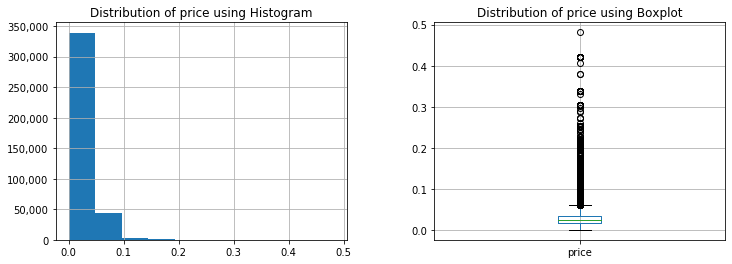

In [12]:
hist_boxplot(df_new, 'price')

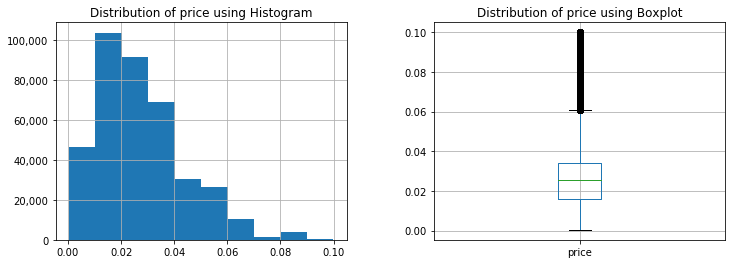

In [13]:
hist_boxplot(df_new, 'price', 0.1)

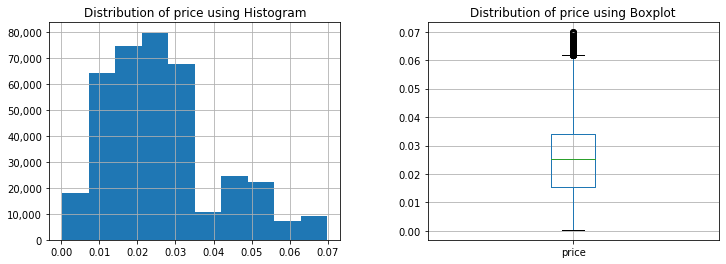

In [14]:
hist_boxplot(df_new, 'price', 0.07) # final distribution upon removal of outliers

Check number of transactions by each customer_id

In [15]:
# t_by_customer = df_new.groupby('customer_id', as_index=False).size()
t_by_customer = df_new.groupby('customer_id').size().reset_index(name='Number of transactions')
print(len(t_by_customer))
t_by_customer.head()

15538


,customer_id,Number of transactions
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13
4,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,3


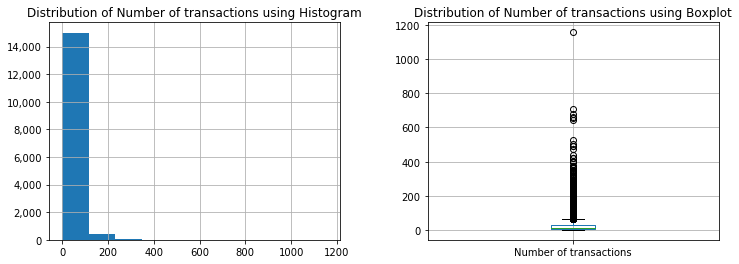

In [16]:
hist_boxplot(t_by_customer, 'Number of transactions')

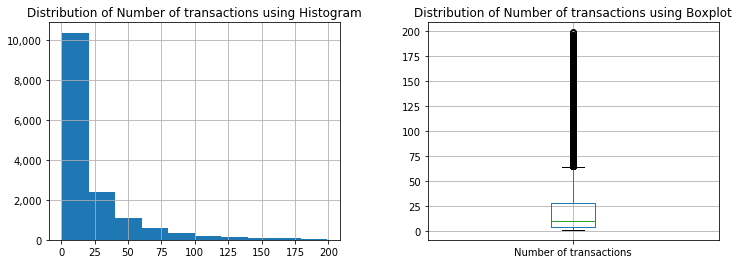

In [17]:
hist_boxplot(t_by_customer, 'Number of transactions', 200)

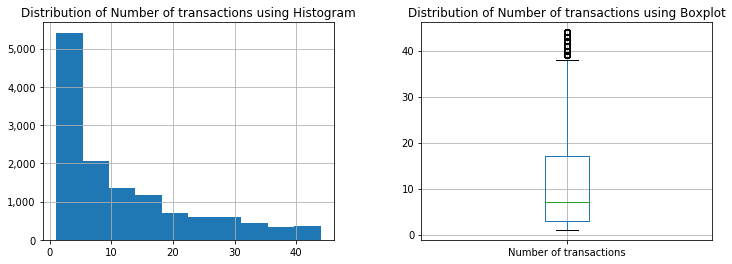

In [18]:
hist_boxplot(t_by_customer, 'Number of transactions', 45) # final distribution upon removal of outliers

Check articles purchased in transactions

In [19]:
# t_by_article = df_new.groupby('article_id', as_index=False).size()
t_by_article = df_new.groupby('article_id').size().reset_index(name='Number of purchases')
print(len(t_by_article))
t_by_article.head()

55031


,article_id,Number of purchases
0,108775015,139
1,108775044,93
2,108775051,4
3,110065001,15
4,110065002,5


In [20]:
t_by_article.describe()

,Number of purchases
count,55031.000000
mean,7.044175
std,12.690393
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,637.000000


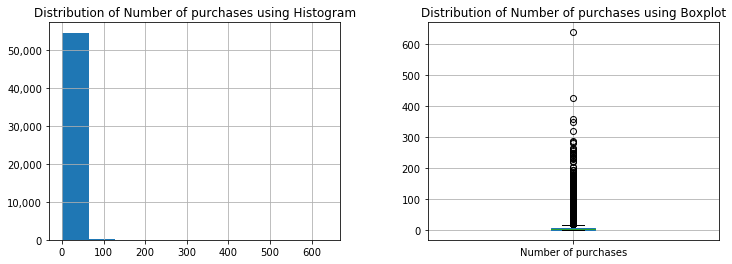

In [21]:
hist_boxplot(t_by_article, 'Number of purchases')

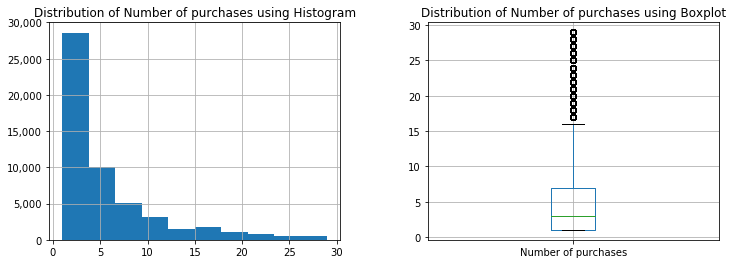

In [22]:
hist_boxplot(t_by_article, 'Number of purchases', 30)

In [23]:
# Filter out customer_ids with number of transactions too high or spend too little money
# > Filter out transactions with price <= 0.1
# > Filter out customer_ids with number of transactions <= 50

len1 = len(df_new)
print('Original length of transactions df:', len1)

df_new = df_new[df_new['price'] < 0.07]
len2 = len(df_new)
print('Length of transactions df after removing transactions with price >=0.07:', len2)

t_by_customer = df_new.groupby('customer_id').size().reset_index(name='Number of transactions')
t_by_customer = t_by_customer[t_by_customer['Number of transactions'] < 45]
filtered_cust = list(t_by_customer['customer_id'].unique())
df_new = df_new[df_new['customer_id'].isin(filtered_cust)]
len3 = len(df_new)
print('Length of transactions df after removing customers >=45 trans:', len3)

Original length of transactions df: 387648
Length of transactions df after removing transactions with price >=0.07: 377928
Length of transactions df after removing customers >=45 trans: 150636


In [24]:
print('Proportion of data kept: '+str((len3/len1) * 100)+'%')
print('Number of rows left: '+str(len3))

Proportion of data kept: 38.858964834076275%
Number of rows left: 150636


### 2.2 Create dataframe for RFM analysis

#### Check number of unique customers

In [25]:
# Check number of unique customers BEFORE removing outliers
len(df['customer_id'].unique())

15538

In [26]:
# Check number of unique customers AFTER removing outliers
len(df_new['customer_id'].unique())

12925

#### Only keep customers left from undersampling

In [27]:
df_sample = df_new[df_new['customer_id'].isin(sampled_cust['customer_id'])]
print(df_sample.shape)
df_sample.head()

(150636, 5)


,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
47,001fd23db1109a94bba1319bb73df0b479059027c182da...,2018-09-20,0.016932,631744002,1
48,001fd23db1109a94bba1319bb73df0b479059027c182da...,2018-09-20,0.021593,562252035,1
49,0021da829b898f82269fc51feded4eac2129058ee95bd7...,2018-09-20,0.027441,649356002,1


#### Recency

In [28]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df_new)) # check
# df_recency.head()

True


##### Recency for undersampled case

In [29]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_sample.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df_sample)) # check
# df_recency.head()

True


In [30]:
print(df_recency['t_dat'].max())

2020-09-22 00:00:00


In [31]:
# Get last date of purchase
df_recency = pd.DataFrame(df_recency.groupby('customer_id')['t_dat'].max()).reset_index()
print(len(df_recency) == len(df_recency['customer_id'].unique()))
# df_recency.head()

True


In [32]:
# Calculate recency based on 2020-10-01
date = dt.datetime(2020, 10, 1)
df_recency['Recency'] = df_recency.t_dat.apply(lambda x:(date - x).days)
df_recency.head()

,customer_id,t_dat,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,26
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,16
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,50
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,2020-07-21,72
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,2018-11-03,698


#### Frequency

In [33]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df_new)) # check
# df_frequency.head()

True


##### Frequency for undersampled case

In [34]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_sample.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df_sample)) # check
# df_frequency.head()

True


In [35]:
# Calculate frequency based on total number of purchases
df_frequency = pd.DataFrame(df_frequency.groupby('customer_id')['t_dat'].count()).reset_index()
print(len(df_frequency) == len(df_sample['customer_id'].unique()))
df_frequency.columns = ['customer_id', 'Frequency']
df_frequency.head()

True


,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,3
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,15


(array([5350., 2054., 1337., 1182.,  704.,  593.,  605.,  412.,  339.,
         349.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <a list of 10 Patch objects>)

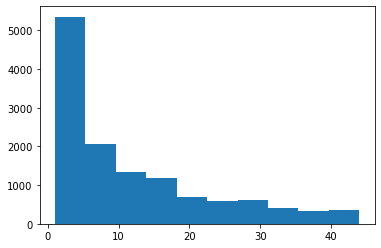

In [36]:
plt.hist(df_frequency['Frequency'])

#### Monetary

In [37]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_new.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df_new)) # check
# df_monetary.head()

True


##### Monetary for undersampled case

In [38]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_sample.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df_sample)) # check
# df_monetary.head()

True


In [39]:
# Calculate monetary based on average amount spent per transaction
df_monetary = pd.DataFrame(df_monetary.groupby('customer_id')['price'].mean()).reset_index()
print(len(df_monetary) == len(df_sample['customer_id'].unique()))
df_monetary.columns = ['customer_id', 'Monetary']
df_monetary.head()

True


,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030904
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.039154
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.036130
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,0.031056
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,0.014833


In [40]:
# Multiply by 1000
df_monetary['Monetary'] = df_monetary['Monetary']*1000
df_monetary.head()

,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,30.903955
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,39.154426
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,36.130378
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,31.056497
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,14.832768


(array([ 120.,  966., 3058., 4077., 2710.,  993.,  543.,  283.,   95.,
          80.]),
 array([ 1.50847458,  8.22033898, 14.93220339, 21.6440678 , 28.3559322 ,
        35.06779661, 41.77966102, 48.49152542, 55.20338983, 61.91525424,
        68.62711864]),
 <a list of 10 Patch objects>)

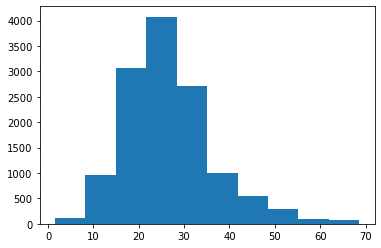

In [41]:
plt.hist(df_monetary['Monetary'])

## 3 RFM analysis
https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

### 3.1 Combine RFM into a single dataframe
- `Recency`: Number of days from latest transaction date to 2020-10-1 (because the latest t_dat in dataset is 2020-9-22 so chose 2020-10-1 as a reasonable benchmark)
- `Frequency`: Number of transactions per customer_id
- `Money`: Average spending per transaction

In [42]:
df_rfm = pd.merge(df_recency, df_frequency, on='customer_id')
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id')
df_rfm = df_rfm.drop(['t_dat'], axis=1)
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (12925, 4)


,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,72,3,31.056497
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,698,15,14.832768


#### Normalize by scaling

In [43]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

rfm = df_rfm.drop(['customer_id'], axis=1)

scaler = StandardScaler()
scaler.fit(rfm)
customers_normalized = scaler.transform(rfm)

rfm = pd.DataFrame(customers_normalized, columns=['Recency_norm','Frequency_norm','Monetary_norm'])
rfm.head()

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0. -0.]
[1. 1. 1.]


In [44]:
rfm.insert(0, "customer_id", df_rfm.customer_id)
rfm.head()

,customer_id,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.075046,0.844638,0.436269
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.120024,0.573497,1.270816
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-0.967099,0.121596,0.964929
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,-0.868148,-0.782208,0.451699
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,1.947460,0.302356,-1.189356


In [45]:
df_rfm['Recency_norm'] = rfm['Recency_norm']
df_rfm['Frequency_norm'] = rfm['Frequency_norm']
df_rfm['Monetary_norm'] = rfm['Monetary_norm']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955,-1.075046,0.844638,0.436269
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426,-1.120024,0.573497,1.270816
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378,-0.967099,0.121596,0.964929
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,72,3,31.056497,-0.868148,-0.782208,0.451699
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,698,15,14.832768,1.947460,0.302356,-1.189356


In [46]:
# Check
print(min(df_rfm['Recency_norm']), max(df_rfm['Recency_norm']))
print(min(df_rfm['Frequency_norm']), max(df_rfm['Frequency_norm']))
print(min(df_rfm['Monetary_norm']), max(df_rfm['Monetary_norm']))

-1.1515082890659178 2.1453626046053036
-0.9629681625531813 2.9233853643473156
-2.5371288253882116 4.252024151902273


(array([5350., 2054., 1337., 1182.,  704.,  593.,  605.,  412.,  339.,
         349.]),
 array([-0.96296816, -0.57433281, -0.18569746,  0.2029379 ,  0.59157325,
         0.9802086 ,  1.36884395,  1.75747931,  2.14611466,  2.53475001,
         2.92338536]),
 <a list of 10 Patch objects>)

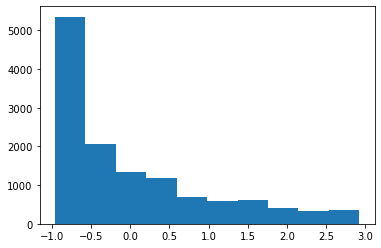

In [47]:
plt.hist(df_rfm['Frequency_norm'])

(array([ 120.,  966., 3058., 4077., 2711.,  992.,  543.,  283.,   95.,
          80.]),
 array([-2.53712883, -1.85821353, -1.17929823, -0.50038293,  0.17853237,
         0.85744766,  1.53636296,  2.21527826,  2.89419356,  3.57310885,
         4.25202415]),
 <a list of 10 Patch objects>)

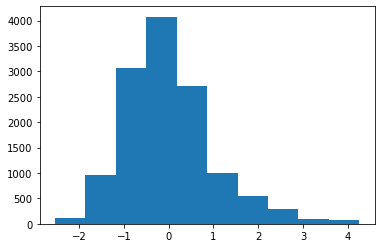

In [48]:
plt.hist(df_rfm['Monetary_norm'])

### 3.2 Conduct RFM Analysis by grouping customers into segments
- Recency: (shortened interval because shopping for clothes is a necessity)
    - Active: Purchase within past 6 months
    - Warm: Purchase within past 1 year
    - Cold/Lost: Purchase beyond 1 year
- Frequency:
    - Frequent: Top 20%
    - Less frequent: Bottom 80%
- Monetary:
    - Valuable: Top 20%
    - Less valuable: Bottom 80%

In [49]:
# assign recency label
bins = [0,6*30,12*30,1000]

r_labels = ['Active','Warm','Cold/Lost']
df_rfm['r_label'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_labels, right=False)

In [50]:
# assign frequency label
#bins = [0, np.percentile(df_rfm.Frequency_norm,20), 1.1]
bins = [min(df_rfm.Frequency_norm)-0.01, np.percentile(df_rfm.Frequency_norm,20), max(df_rfm.Frequency_norm)+0.01]

f_labels = ['Less frequent','Frequent']
df_rfm['f_label'] = pd.cut(df_rfm['Frequency_norm'], bins=bins, labels=f_labels, right=False)

In [51]:
# assign monetary label
#bins = [0, np.percentile(df_rfm.Monetary_norm,20), 1.1]
bins = [min(df_rfm.Monetary_norm)-0.01, np.percentile(df_rfm.Monetary_norm,20), max(df_rfm.Monetary_norm)+0.01]

m_labels = ['Less valuable','Valuable']
df_rfm['m_label'] = pd.cut(df_rfm['Monetary_norm'], bins=bins, labels=m_labels, right=False)

In [52]:
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,r_label,f_label,m_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955,-1.075046,0.844638,0.436269,Active,Frequent,Valuable
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426,-1.120024,0.573497,1.270816,Active,Frequent,Valuable
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378,-0.967099,0.121596,0.964929,Active,Frequent,Valuable
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,72,3,31.056497,-0.868148,-0.782208,0.451699,Active,Frequent,Valuable
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,698,15,14.832768,1.947460,0.302356,-1.189356,Cold/Lost,Frequent,Less valuable


#### RFM Customer Segments
- Champions: High on all RFM factors
- Loyal: May not have high Monetary, but high on Recency and Frequency (i.e. visits stores often, maybe to check out new goods)
- Provide attention: Customers who have at least 1 high but not more than 2 high out of the RFM attributes (these customers are either willing to pay, willing to visit the store or show interest with their recent visit > therefore, we could try to capture these customers to earn profits from them)
- Unprofitable: No point in investing in these customers as they demonstrate low interest via their visits to the store or amount of purchase made

Using RFM

In [53]:
def assign_label(df, r_label, f_label, m_label, label, colname='rfm_label'):
    df.loc[(df['r_label']==r_label) & (df['f_label']==f_label)
              & (df['m_label']==m_label), colname] = label
    return df

# def assign_label(df, r_rule, f_rule, m_rule, label, colname='rfm_label'):
#     df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
#             & (df['f_score'].between(f_rule[0], f_rule[1]))
#             & (df['m_score'].between(m_rule[0], m_rule[1])), colname] = label
#     return df

In [54]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Valuable', 'Champions')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Less valuable', 'Loyal')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Less valuable', 'Provide attention')

df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Less valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Less valuable', 'Provide attention')

df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Less valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Less valuable', 'Unprofitable')

In [55]:
# print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,r_label,f_label,m_label,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955,-1.075046,0.844638,0.436269,Active,Frequent,Valuable,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426,-1.120024,0.573497,1.270816,Active,Frequent,Valuable,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378,-0.967099,0.121596,0.964929,Active,Frequent,Valuable,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,72,3,31.056497,-0.868148,-0.782208,0.451699,Active,Frequent,Valuable,Champions
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,698,15,14.832768,1.947460,0.302356,-1.189356,Cold/Lost,Frequent,Less valuable,Unprofitable


In [56]:
df_rfm['rfm_label'].unique()

array(['Champions', 'Unprofitable', 'Provide attention', 'Loyal'],
      dtype=object)

#### Export clusters

In [57]:
df_clusters = df_rfm.loc[:,['customer_id','rfm_label']]
df_clusters.rename({'rfm_label': 'cluster'}, axis=1, inplace=True)
df_clusters.head()

,customer_id,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,Champions
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,Unprofitable


In [58]:
# df_clusters.to_csv('clusters_4.csv', index=False)

### 3.3 RFM Segment Analysis

### 3.3.1 General Analysis on RFM Segments

#### Number of customers in each RFM Segment defined

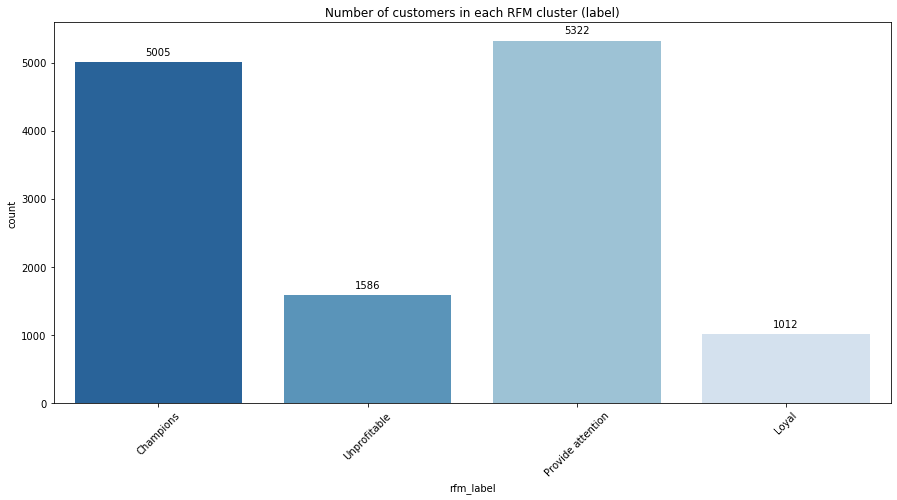

In [59]:
palette = sns.color_palette("Blues_r", n_colors=4)

for rfm_type in ['label']:
    fig, ax = plt.subplots(figsize=(15,7))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=45)
    plt.show()

#### Proportion of customers in each RFM Segment & Proportion of monetary amount by customers in each RFM Segment

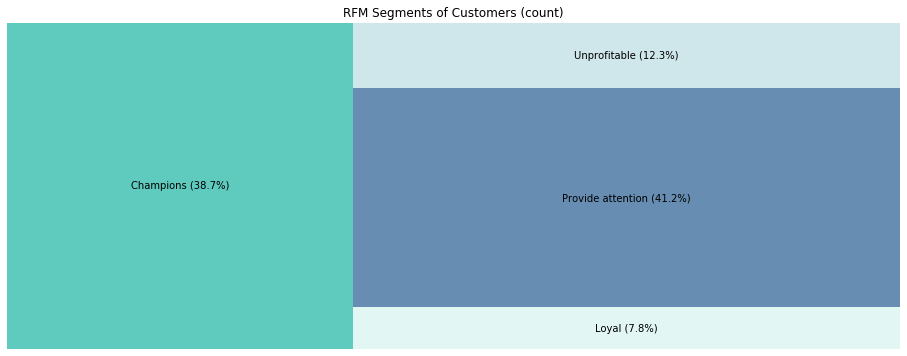

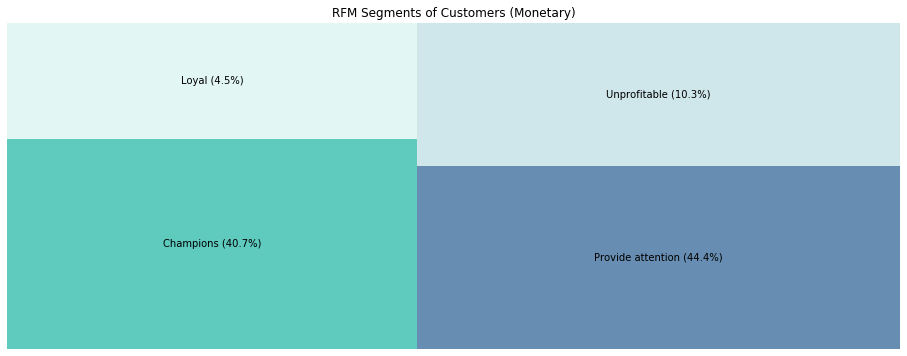

In [60]:
import squarify
agg_dict2 = {
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum',
    'Recency_norm': 'mean',
    'Frequency_norm': 'mean',
    'Monetary_norm': 'mean'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['Monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'Monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

#### View Recency vs Frequency for each RFM Segment for comparison

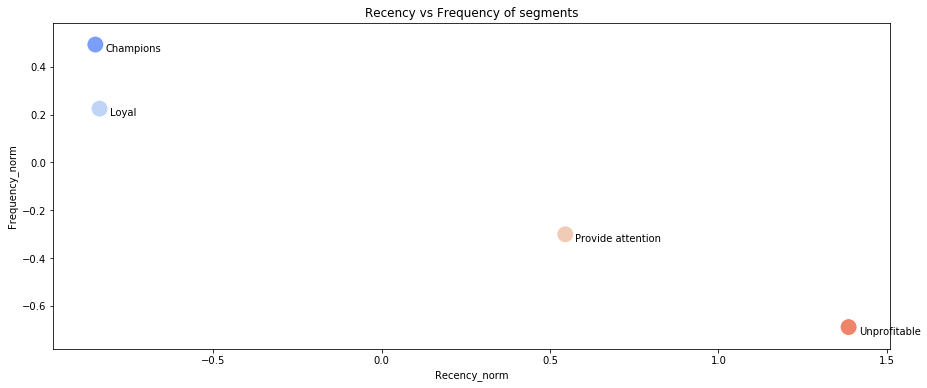

In [61]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Frequency_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Frequency_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Frequency of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Recency vs Monetary of each RFM Segment for comparison

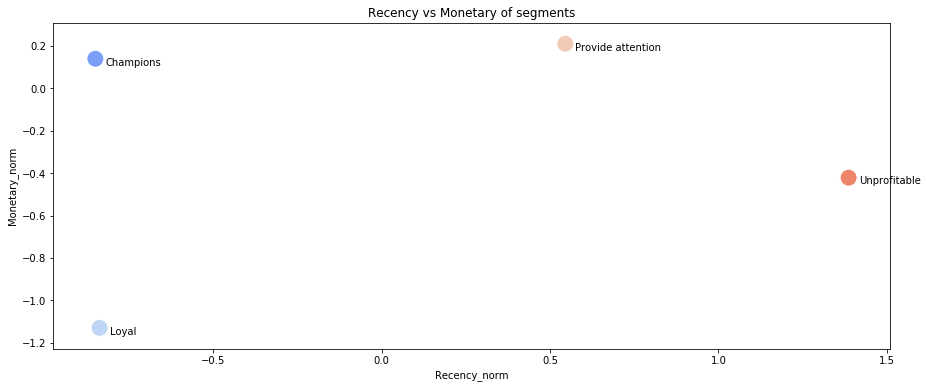

In [62]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Monetary_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Frequency vs Monetary of each RFM Segment for comparison

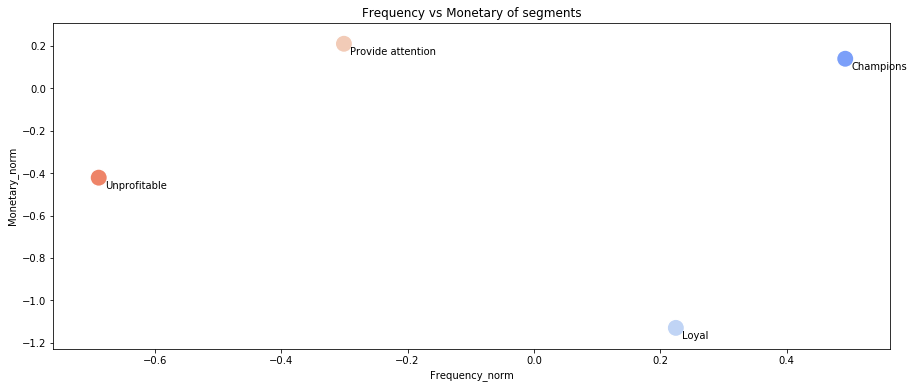

In [63]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Frequency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Frequency_norm'][i]+0.01, #+0.0008,
               df_analysis['Monetary_norm'][i]-0.05, #-0.003,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Frequency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### Visualize all elements together - Snakeplot

In [64]:
df_snake = df_rfm.loc[:,['customer_id','Recency_norm','Frequency_norm','Monetary_norm','rfm_label']]
df_snake.rename({'Recency_norm':'recency',
                 'Frequency_norm':'frequency',
                 'Monetary_norm':'monetary',
                 'rfm_label': 'cluster'}, axis=1, inplace=True)
df_snake.head()
df_melt = pd.melt(df_snake.reset_index(), 
                  id_vars=['customer_id','cluster'],
                  value_vars=['recency','frequency','monetary'],
                  #value_vars=['frequency','monetary'],
                  var_name='Attribute',
                  value_name='Value')
df_melt.head()

,customer_id,cluster,Attribute,Value
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions,recency,-1.075046
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions,recency,-1.120024
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions,recency,-0.967099
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,Champions,recency,-0.868148
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,Unprofitable,recency,1.947460


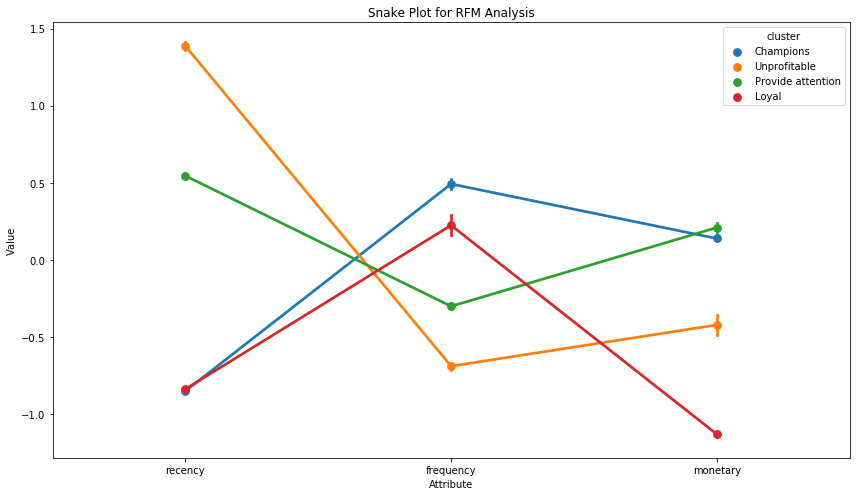

In [65]:
plt.figure(figsize=(12, 7))
plt.title('Snake Plot for RFM Analysis')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Attribute', y='Value', hue='cluster')

plt.tight_layout()

### 3.3.2 Demographic Analysis of RFM Segments

#### Read in CSV and Conduct Basic Analysis

In [66]:
# customers = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/customers.csv')
customers = pd.read_csv('data/customers.csv')
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [67]:
customers = customers[customers['customer_id'].isin(sampled_cust['customer_id'])]
print(customers.shape)
customers.head()

(15538, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
10,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,NaN,NaN,ACTIVE,NONE,29.0,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...


In [68]:
customers = customers.loc[:,['customer_id','Active','club_member_status','fashion_news_frequency','age','postal_code']]
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (15538, 6)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
10,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,NaN,ACTIVE,NONE,29.0,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...


In [69]:
# Basic data check: Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))

Number of Null Values in customer_id  :  0 / 15538
Number of Null Values in Active  :  7769 / 15538
Number of Null Values in club_member_status  :  31 / 15538
Number of Null Values in fashion_news_frequency  :  129 / 15538
Number of Null Values in age  :  0 / 15538
Number of Null Values in postal_code  :  0 / 15538


In [70]:
# Handle null values
customers['Active'] = customers['Active'].fillna(0)
customers['club_member_status'] = customers['club_member_status'].fillna('NONE')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace(['NONE'],'None')
customers = customers.dropna(subset=['age'])

# Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))
    
customers.dtypes

Number of Null Values in customer_id  :  0 / 15538
Number of Null Values in Active  :  0 / 15538
Number of Null Values in club_member_status  :  0 / 15538
Number of Null Values in fashion_news_frequency  :  0 / 15538
Number of Null Values in age  :  0 / 15538
Number of Null Values in postal_code  :  0 / 15538


customer_id                object
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [71]:
# Convert datatypes to suitable datatypes
customers = customers.astype({'customer_id':'str',
                              'Active':'category',
                              'club_member_status':'category',
                              'fashion_news_frequency':'category',
                              'age':'int64',
                              'postal_code':'category'})
customers.dtypes

customer_id                 object
Active                    category
club_member_status        category
fashion_news_frequency    category
age                          int64
postal_code               category
dtype: object

In [72]:
rfm_customers = customers.merge(df_rfm[['customer_id','Recency', 'Frequency','Monetary','rfm_label']], on='customer_id')
print('Dataframe shape:',rfm_customers.shape)
rfm_customers.head()

Dataframe shape: (12925, 10)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code,Recency,Frequency,Monetary,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,26,21,30.903955,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,16,18,39.154426,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,50,13,36.130378,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,0.0,ACTIVE,None,29,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...,72,3,31.056497,Champions
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,0.0,ACTIVE,None,31,2c29ae653a9282cce4151bd87643c907644e09541abc28...,698,15,14.832768,Unprofitable


#### Demographic Analysis 0: Getting the average values for each variable (via one-hot encoding)

In [73]:
rfm_customers_OHE = pd.get_dummies(rfm_customers, columns = ['Active','club_member_status', 'fashion_news_frequency'])
rfm_customers_OHE.head()

,customer_id,age,postal_code,Recency,Frequency,Monetary,rfm_label,Active_0.0,Active_1.0,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NONE,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,26,21,30.903955,Champions,1,0,1,0,0,0,0,1,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,16,18,39.154426,Champions,1,0,1,0,0,0,0,1,0
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,50,13,36.130378,Champions,0,1,1,0,0,0,0,0,1
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,29,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...,72,3,31.056497,Champions,1,0,1,0,0,0,0,1,0
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,31,2c29ae653a9282cce4151bd87643c907644e09541abc28...,698,15,14.832768,Unprofitable,1,0,1,0,0,0,0,1,0


--- OVERALL ANALYSIS ---

In [74]:
rfm_customers_OHE.describe()

,age,Recency,Frequency,Monetary,Active_0.0,Active_1.0,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NONE,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_None,fashion_news_frequency_Regularly
count,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000,12925.000000
mean,36.549710,265.017176,11.654623,26.590933,0.517369,0.482631,0.937331,0.000464,0.002244,0.059961,0.000696,0.510793,0.488511
std,14.725449,222.340632,11.064784,9.886541,0.499718,0.499718,0.242376,0.021542,0.047317,0.237424,0.026380,0.499903,0.499887
min,16.000000,9.000000,1.000000,1.508475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,74.000000,3.000000,20.010169,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,187.000000,7.000000,25.406780,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,49.000000,442.000000,17.000000,31.621469,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,90.000000,742.000000,44.000000,68.627119,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


--- ANALYSIS BY CLUSTERS ---

In [75]:
rfm_customers_OHE.groupby('rfm_label')[rfm_customers_OHE.columns].describe()

age                                                      \
                    count       mean        std   min   25%   50%   75%   max   
rfm_label                                                                       
Champions          5005.0  35.494905  14.743525  17.0  23.0  30.0  49.0  90.0   
Loyal              1012.0  32.559289  13.851603  17.0  21.0  27.0  43.0  74.0   
Provide attention  5322.0  37.817362  14.698271  16.0  25.0  34.0  50.0  90.0   
Unprofitable       1586.0  38.170870  14.576518  18.0  25.0  36.0  50.0  85.0   

                  Recency                                                      \
                    count        mean         std    min    25%    50%    75%   
rfm_label                                                                       
Champions          5005.0   76.090110   47.644807    9.0   33.0   70.0  111.0   
Loyal              1012.0   78.876482   44.281332    9.0   42.0   77.0  105.0   
Provide attention  5322.0  386.240135  174.637681    9.0  250.0  347.0  518.0   
Unprofitable       1586.0  573.217528  114.314994  360.0  468.0  587.0  676.0   

                         Frequency                                        \
                     max     count       mean        std  min  25%   50%   
rfm_label                                                                  
Champions          179.0    5005.0  17.103497  12.004182  2.0  6.0  15.0   
Loyal              179.0    1012.0  14.138340  11.048165  2.0  5.0  11.0   
Provide attention  742.0    5322.0   8.328448   8.557223  1.0  2.0   5.0   
Unprofitable       742.0    1586.0   4.035939   5.170833  1.0  1.0   2.0   

                              Monetary                                   \
                    75%   max    count       mean        std        min   
rfm_label                                                                 
Champions          26.0  44.0   5005.0  27.965215   6.872201  18.752668   
Loyal              21.0  44.0   1012.0  15.424877   2.826750   3.033898   
Provide attention  11.0  44.0   5322.0  28.663614   9.959791   2.762712   
Unprofitable        5.0  42.0   1586.0  22.423820  13.871271   1.508475   

                                                              Active_0.0  \
                         25%        50%        75%        max      count   
rfm_label                                                                  
Champions          22.864407  26.569007  31.407696  67.779661     5005.0   
Loyal              13.996704  16.254237  17.461864  18.748184     1012.0   
Provide attention  22.016949  26.988701  33.881356  68.627119     5322.0   
Unprofitable       13.725636  16.932203  27.101695  68.627119     1586.0   

                                                               Active_1.0  \
                       mean       std  min  25%  50%  75%  max      count   
rfm_label                                                                   
Champions          0.464136  0.498762  0.0  0.0  0.0  1.0  1.0     5005.0   
Loyal              0.456522  0.498352  0.0  0.0  0.0  1.0  1.0     1012.0   
Provide attention  0.562758  0.496092  0.0  0.0  1.0  1.0  1.0     5322.0   
Unprofitable       0.571879  0.494963  0.0  0.0  1.0  1.0  1.0     1586.0   

                                                                \
                       mean       std  min  25%  50%  75%  max   
rfm_label                                                        
Champions          0.535864  0.498762  0.0  0.0  1.0  1.0  1.0   
Loyal              0.543478  0.498352  0.0  0.0  1.0  1.0  1.0   
Provide attention  0.437242  0.496092  0.0  0.0  0.0  1.0  1.0   
Unprofitable       0.428121  0.494963  0.0  0.0  0.0  1.0  1.0   

                  club_member_status_ACTIVE                                \
                                      count      mean       std  min  25%   
rfm_label                                                                   
Champions                            5005.0  0.970030  0.170

#### Demographic Analysis 1: Descriptive analysis

#### - Demographic Analysis 1.1: Descriptive analysis by Recency, Frequency and Monetary

--- OVERALL ANALYSIS ---

In [76]:
rfm_customers[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,12925.000000,12925.000000,12925.000000
mean,265.017176,11.654623,26.590933
std,222.340632,11.064784,9.886541
min,9.000000,1.000000,1.508475
25%,74.000000,3.000000,20.010169
50%,187.000000,7.000000,25.406780
75%,442.000000,17.000000,31.621469
max,742.000000,44.000000,68.627119


--- ANALYSIS BY CLUSTERS ---

In [77]:
rfm_customers.groupby('rfm_label')['Recency', 'Frequency', 'Monetary'].describe()

Recency                                                      \
                    count        mean         std    min    25%    50%    75%   
rfm_label                                                                       
Champions          5005.0   76.090110   47.644807    9.0   33.0   70.0  111.0   
Loyal              1012.0   78.876482   44.281332    9.0   42.0   77.0  105.0   
Provide attention  5322.0  386.240135  174.637681    9.0  250.0  347.0  518.0   
Unprofitable       1586.0  573.217528  114.314994  360.0  468.0  587.0  676.0   

                         Frequency                                        \
                     max     count       mean        std  min  25%   50%   
rfm_label                                                                  
Champions          179.0    5005.0  17.103497  12.004182  2.0  6.0  15.0   
Loyal              179.0    1012.0  14.138340  11.048165  2.0  5.0  11.0   
Provide attention  742.0    5322.0   8.328448   8.557223  1.0  2.0   5.0   
Unprofitable       742.0    1586.0   4.035939   5.170833  1.0  1.0   2.0   

                              Monetary                                   \
                    75%   max    count       mean        std        min   
rfm_label                                                                 
Champions          26.0  44.0   5005.0  27.965215   6.872201  18.752668   
Loyal              21.0  44.0   1012.0  15.424877   2.826750   3.033898   
Provide attention  11.0  44.0   5322.0  28.663614   9.959791   2.762712   
Unprofitable        5.0  42.0   1586.0  22.423820  13.871271   1.508475   

                                                               
                         25%        50%        75%        max  
rfm_label                                                      
Champions          22.864407  26.569007  31.407696  67.779661  
Loyal              13.996704  16.254237  17.461864  18.748184  
Provide attention  22.016949  26.988701  33.881356  68.627119  
Unprofitable       13.725636  16.932203  27.101695  68.627119

#### - Demographic Analysis 1.2: Descriptive analysis by customers demographics

--- OVERALL ANALYSIS ---

In [78]:
rfm_customers[['Active','club_member_status','fashion_news_frequency','age','postal_code']].describe()

,age
count,12925.000000
mean,36.549710
std,14.725449
min,16.000000
25%,24.000000
50%,32.000000
75%,49.000000
max,90.000000


--- ANALYSIS BY CLUSTERS ---

In [79]:
rfm_customers.groupby('rfm_label')['Active','club_member_status','fashion_news_frequency','age','postal_code'].describe()

age                                                    
                    count       mean        std   min   25%   50%   75%   max
rfm_label                                                                    
Champions          5005.0  35.494905  14.743525  17.0  23.0  30.0  49.0  90.0
Loyal              1012.0  32.559289  13.851603  17.0  21.0  27.0  43.0  74.0
Provide attention  5322.0  37.817362  14.698271  16.0  25.0  34.0  50.0  90.0
Unprofitable       1586.0  38.170870  14.576518  18.0  25.0  36.0  50.0  85.0

#### Demographic Analysis 2: Graphic analysis for the different RFM segments (Bottom 2 analyses are the same just displayed in different sequences)

In [80]:
def countplot(df, var_col, xticklabels, rotate=False):
    plt.figure(figsize=(12,5))
    ax = sns.countplot(x=var_col, data=df)
    ax.set(xlabel=var_col, ylabel='Count')
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])
    plt.ylim(0, max_height*1.25)
    plt.title(f'Distribution of {var_col}')
    plt.show()

#### - Demographic Analysis 2.1: View graphs by RFM Segments (Compare within RFM Segments)

In [81]:
# labels = list(rfm_customers['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_customers[rfm_customers['rfm_label']==label]
#     for col in ['Active','club_member_status','fashion_news_frequency','age']:
#         print('Plotting countplot...')
#         print('RFM Segment:',label)
#         print('Variable:',col)
#         if col=='age':
#             sorted_x = list(subset_df[col].unique())
#             sorted_x.sort()
#             countplot(subset_df, col, sorted_x, rotate=True)
#         else:
#             countplot(subset_df, col, list(subset_df[col].unique()))

#### - Demographic Analysis 2.2: View graphs by Variables (Compare across RFM Segments)

Demographic Analysis 2.2.1: Using bar charts

--- OVERALL ANALYSIS ---

----- Variable: Active -----
Plotting countplot...
Variable: Active


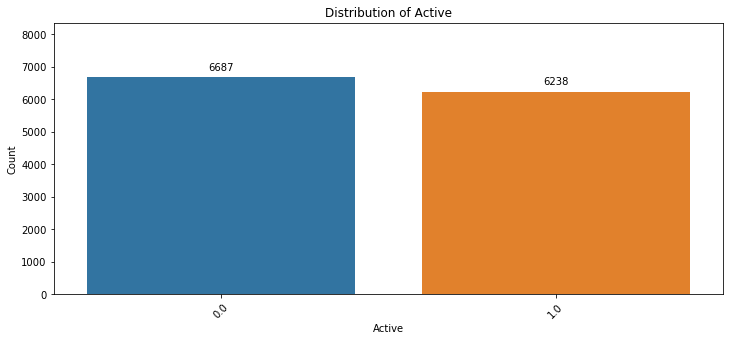

----- Variable: club_member_status -----
Plotting countplot...
Variable: club_member_status


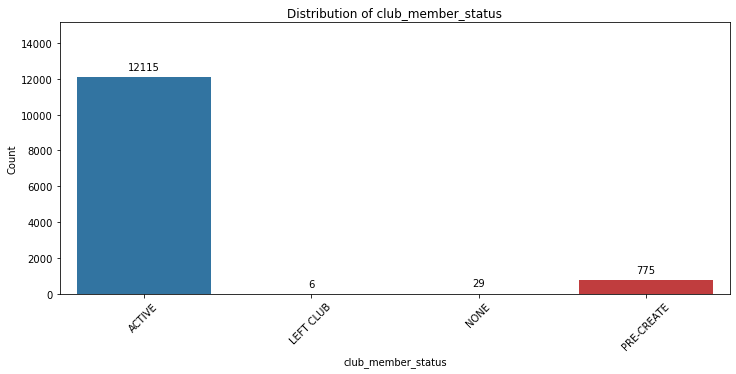

----- Variable: fashion_news_frequency -----
Plotting countplot...
Variable: fashion_news_frequency


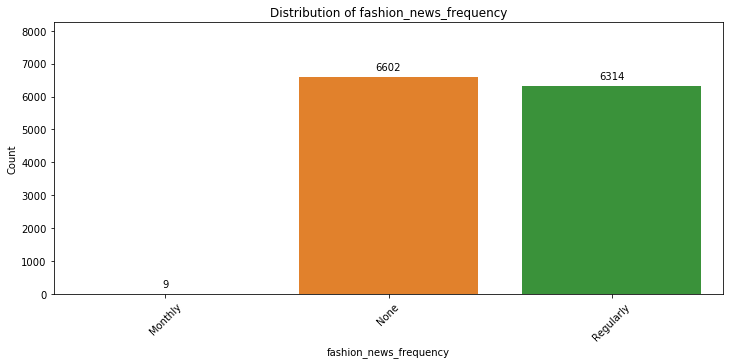

----- Variable: age -----
Plotting countplot...
Variable: age


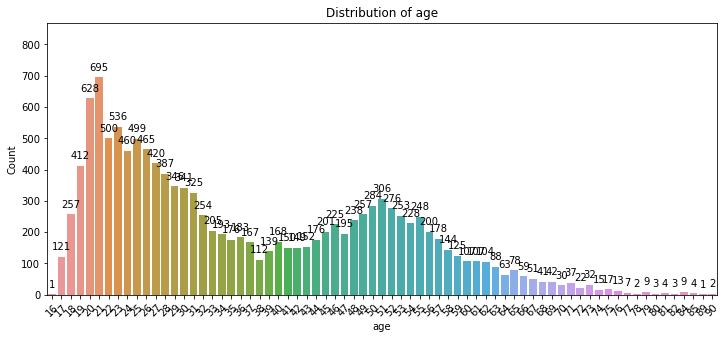

In [82]:
for col in ['Active','club_member_status','fashion_news_frequency','age']:
    print('----- Variable:',col,'-----')
    print('Plotting countplot...')
    print('Variable:',col)
    sorted_x = list(rfm_customers[col].unique())
    countplot(rfm_customers, col, sorted_x, rotate=True)

  age_bucket  Number of customers
0    (10,20)                  791
1    (20,30)                 4936
2    (30,40)                 2095
3    (40,50)                 1911
4    (50,60)                 2242
5    (60,70)                  740
6    (70,80)                  184
7    (80,90)                   24
8   (90,100)                    2 

----- Variable: age_bucket -----
Plotting countplot...
Variable: age_bucket


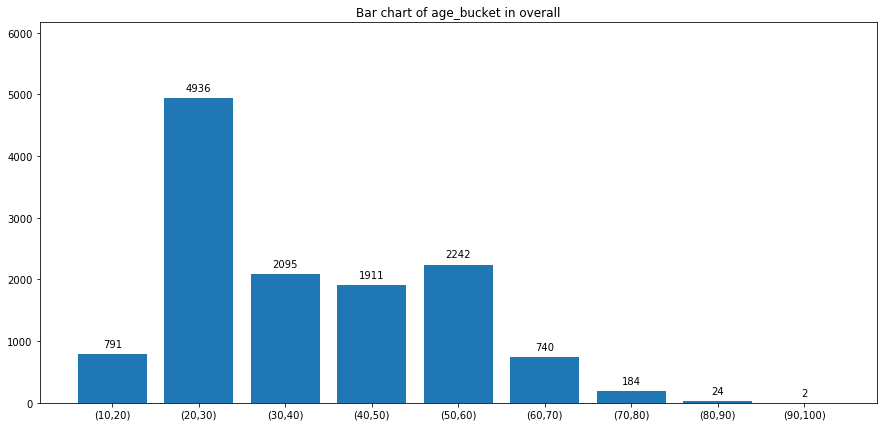

In [83]:
# Looking at age by buckets

# 1. create age buckets
def age_range_minima(age_num):
    age_num = age_num // 10
    age_num = age_num * 10
    return age_num

def age_range_maxima(age_num):
    age_num = age_range_minima(age_num) + 10
    return age_num

def create_age_bins(age_minima, age_maxima):
    bins = []
    age_limit = age_minima
    while age_limit <= age_maxima:
        bins.append(age_limit)
        age_limit += 10
        age_limit = age_range_minima(age_limit)
    return bins

def create_age_labels(bins):
    age_labels = []
    for i in range(len(bins)-1):
        start, end = bins[i], bins[i+1]
        age_range = f'({start},{end})'
        age_labels.append(age_range)
    return age_labels

age_minima = age_range_minima(min(rfm_customers['age']))
age_maxima = age_range_maxima(max(rfm_customers['age']))
bins = create_age_bins(age_minima, age_maxima)
age_labels = create_age_labels(bins)
rfm_customers['age_bucket'] = pd.cut(rfm_customers['age'], bins=bins, labels=age_labels, right=False)

# # 2. group by age bucket
age_by_bucket = rfm_customers.groupby(['age_bucket']).size().reset_index(name='Number of customers')
print(age_by_bucket, '\n')

# # 3. plot graph
col = 'age_bucket'
print('----- Variable:',col,'-----')

fig, ax = plt.subplots(figsize=(15,7))
print('Plotting countplot...')
print('Variable:',col)
sorted_x = list(age_by_bucket[col].unique())
plt.bar(age_by_bucket[col], age_by_bucket['Number of customers'])
for p in ax.patches:
    ax.annotate(p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
max_height = max([x.get_height() for x in ax.patches])    
plt.ylim(0, max_height*1.25)
plt.title(f'Bar chart of {col} in overall')
plt.show()

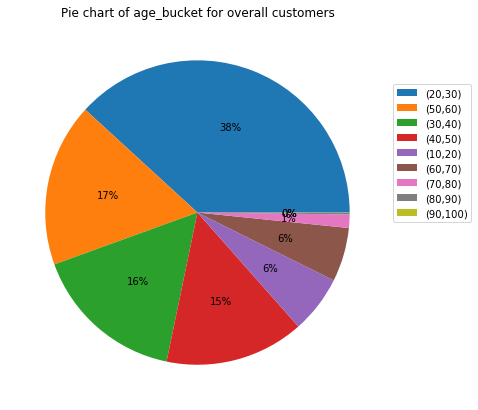

In [84]:
fig, axes = plt.subplots(figsize=(15, 7))
plt.pie(rfm_customers['age_bucket'].value_counts(), autopct='%.0f%%')
plt.title(f'Pie chart of age_bucket for overall customers' )
plt.legend(rfm_customers['age_bucket'].value_counts().index, bbox_to_anchor = (1, 0.85))
plt.show()

--- ANALYSIS BY CLUSTERS ---

----- Variable: Active -----
Plotting countplot...
Variable: Active
RFM Segment: Champions


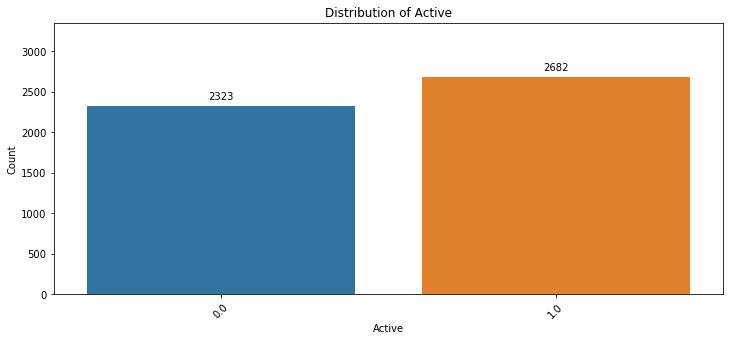

Plotting countplot...
Variable: Active
RFM Segment: Unprofitable


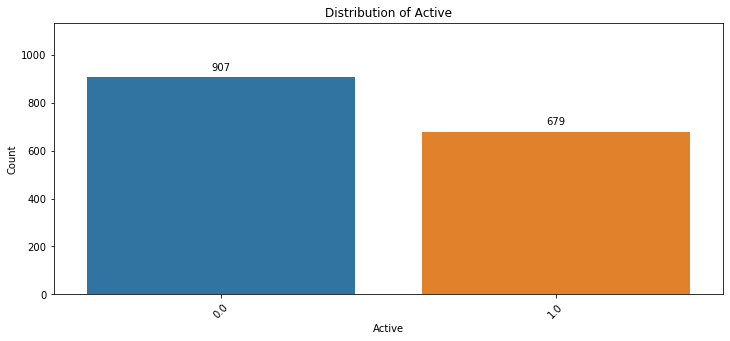

Plotting countplot...
Variable: Active
RFM Segment: Provide attention


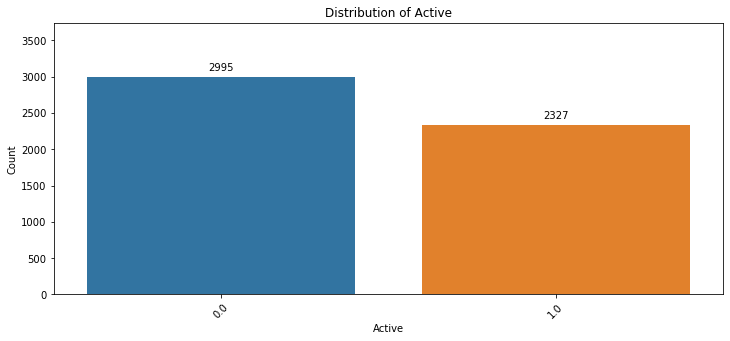

Plotting countplot...
Variable: Active
RFM Segment: Loyal


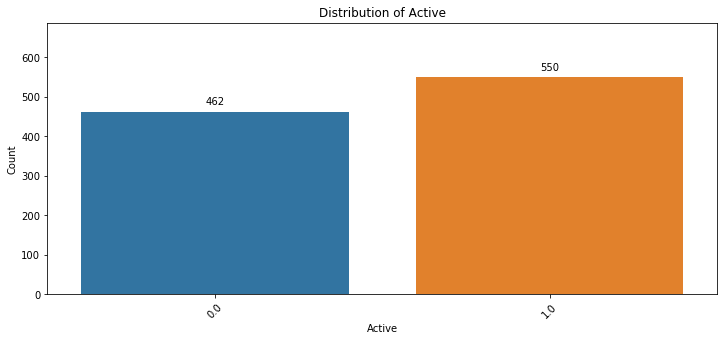

----- Variable: club_member_status -----
Plotting countplot...
Variable: club_member_status
RFM Segment: Champions


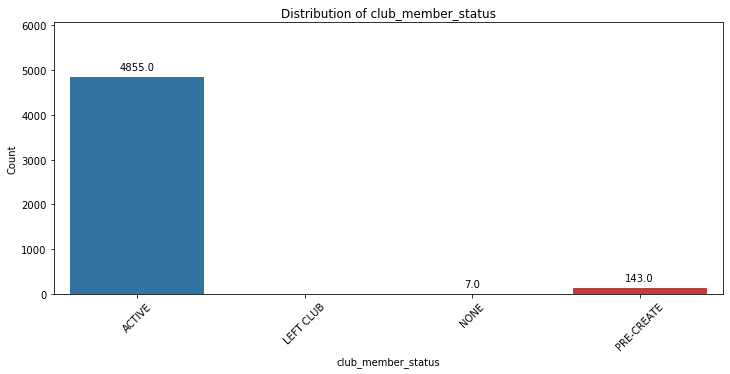

Plotting countplot...
Variable: club_member_status
RFM Segment: Unprofitable


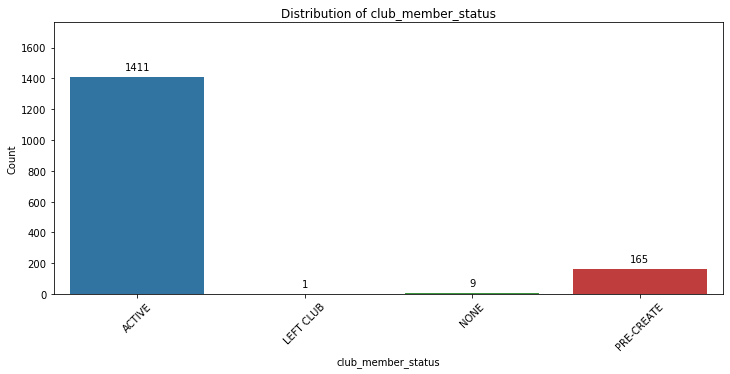

Plotting countplot...
Variable: club_member_status
RFM Segment: Provide attention


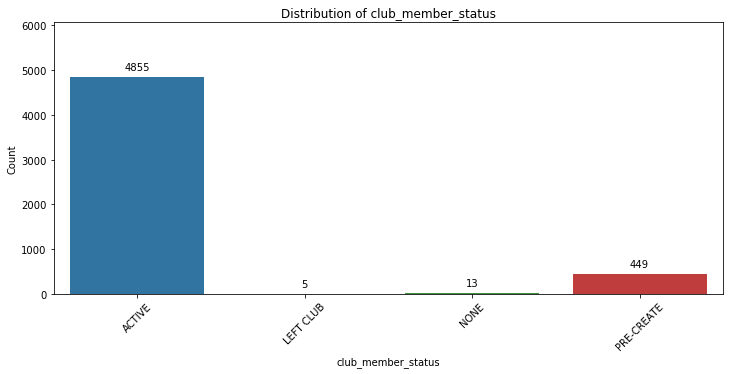

Plotting countplot...
Variable: club_member_status
RFM Segment: Loyal


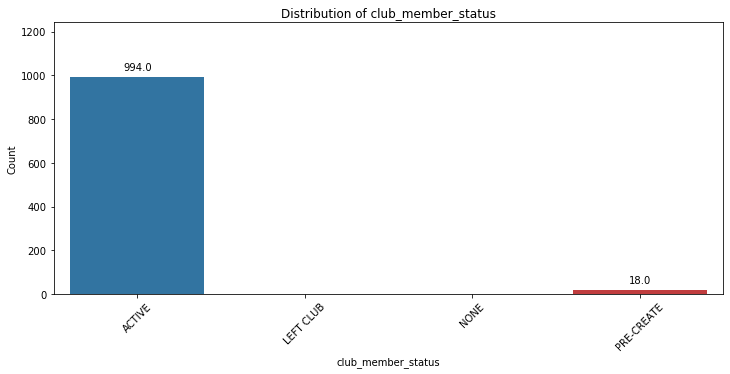

----- Variable: fashion_news_frequency -----
Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Champions


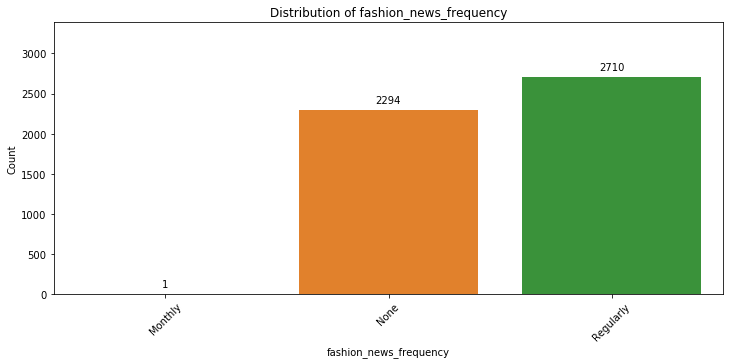

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Unprofitable


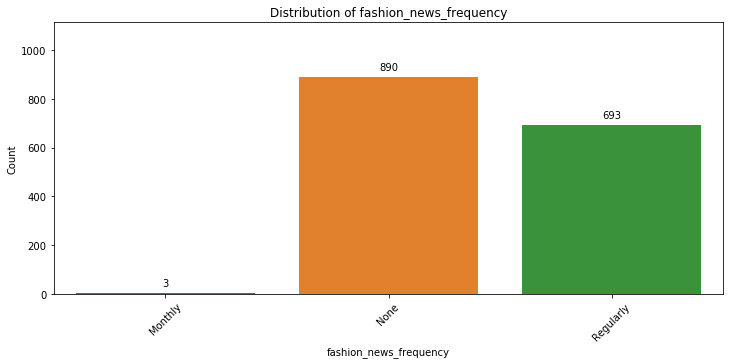

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Provide attention


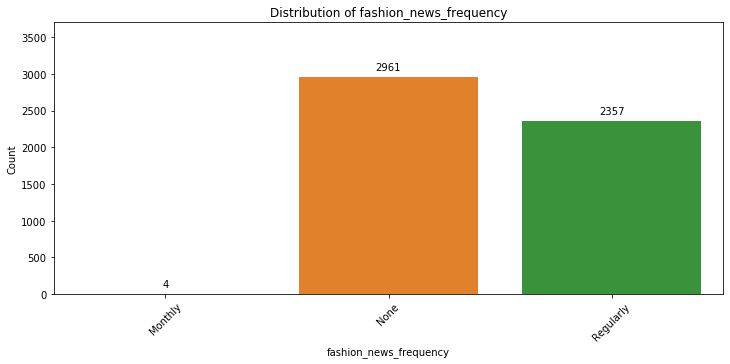

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Loyal


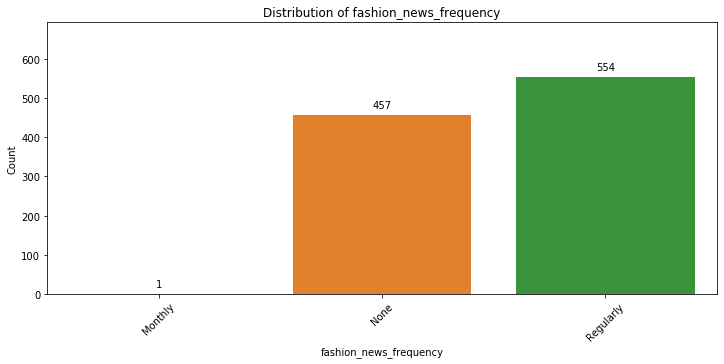

----- Variable: age -----
Plotting countplot...
Variable: age
RFM Segment: Champions


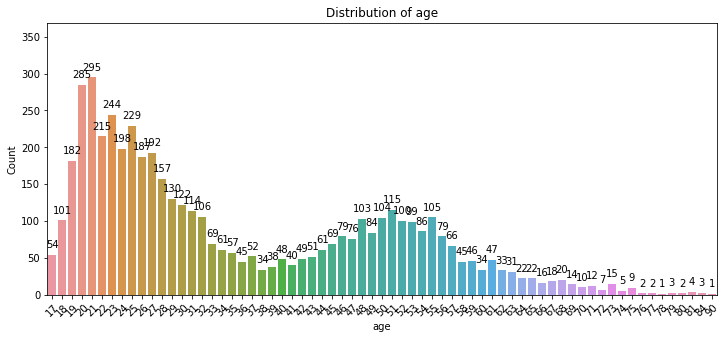

Plotting countplot...
Variable: age
RFM Segment: Unprofitable


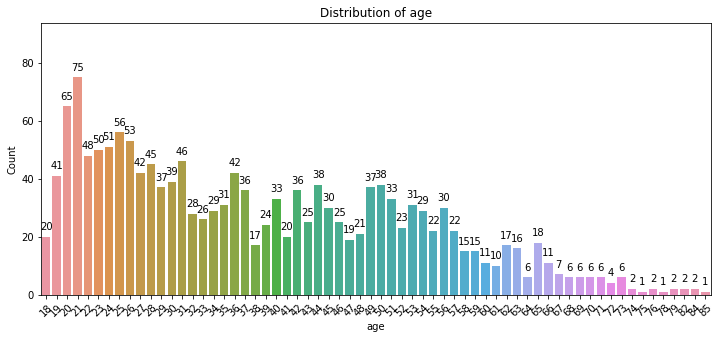

Plotting countplot...
Variable: age
RFM Segment: Provide attention


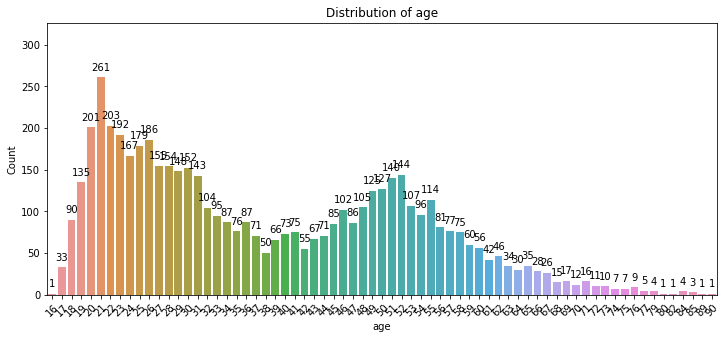

Plotting countplot...
Variable: age
RFM Segment: Loyal


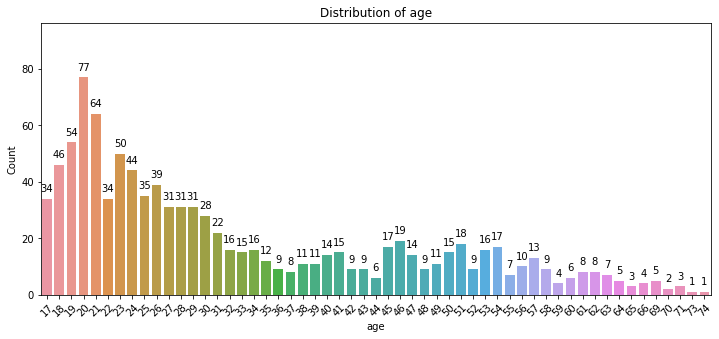

In [85]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency','age']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        print('Plotting countplot...')
        print('Variable:',col)
        print('RFM Segment:',label)
        sorted_x = list(subset_df[col].unique())
        countplot(subset_df, col, sorted_x, rotate=True)

Variable: age
RFM Segment: Champions


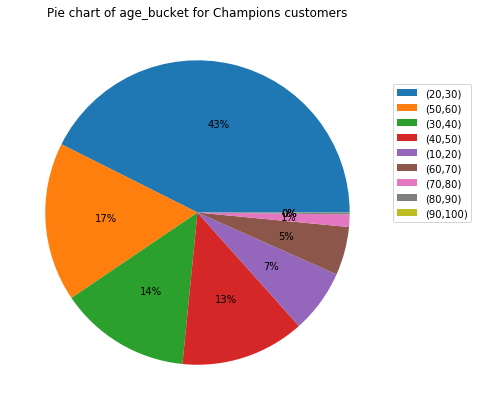

Variable: age
RFM Segment: Unprofitable


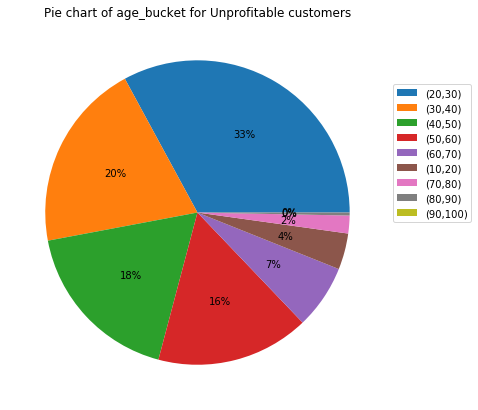

Variable: age
RFM Segment: Provide attention


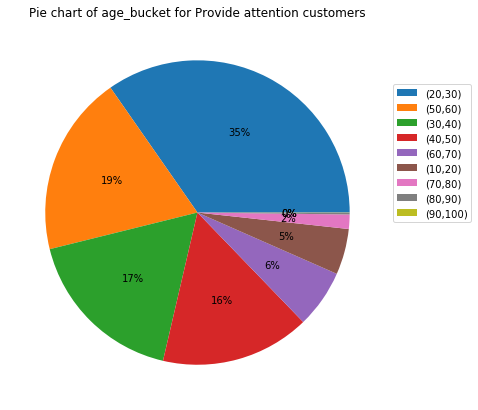

Variable: age
RFM Segment: Loyal


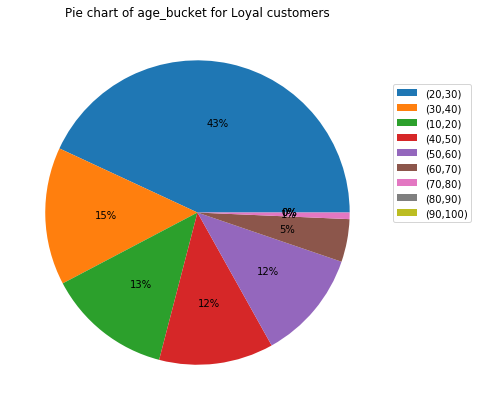

In [86]:
for label in labels:
    fig, ax = plt.subplots(figsize=(15,7))
    print('Variable:',col)
    print('RFM Segment:',label)
    subset_df = rfm_customers[rfm_customers['rfm_label']==label]
    plt.pie(subset_df['age_bucket'].value_counts(), autopct='%.0f%%')
    plt.title(f'Pie chart of age_bucket for {label} customers' )
    plt.legend(subset_df['age_bucket'].value_counts().index, bbox_to_anchor = (1, 0.85))
    plt.show()

Demographic Analysis 2.2.2: Using pie charts (to better see the proportion) *excluded age variable here

--- OVERALL ANALYSIS ---

----- Variable: Active -----


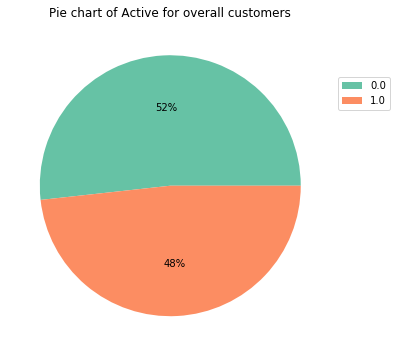

----- Variable: club_member_status -----


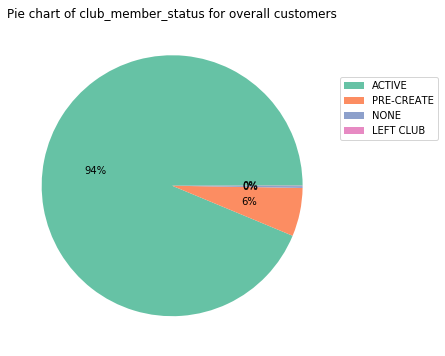

----- Variable: fashion_news_frequency -----


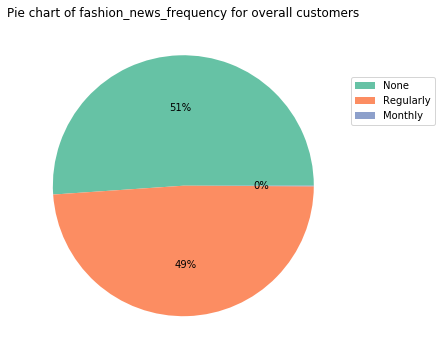

In [87]:
for col in ['Active','club_member_status','fashion_news_frequency']:
    print('----- Variable:',col,'-----')
    fig, axes = plt.subplots(figsize=(13, 6))
    colors = sns.color_palette('Set2')
    plt.pie(rfm_customers[col].value_counts(), colors=colors, autopct='%.0f%%')
    plt.title(f'Pie chart of {col} for overall customers' )
    plt.legend(rfm_customers[col].value_counts().index, bbox_to_anchor = (1, 0.85))
    plt.show()

--- ANALYSIS BY CLUSTERS ---

----- Variable: Active -----


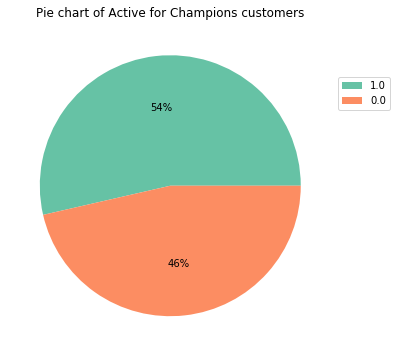

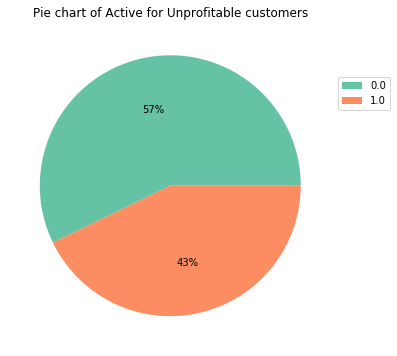

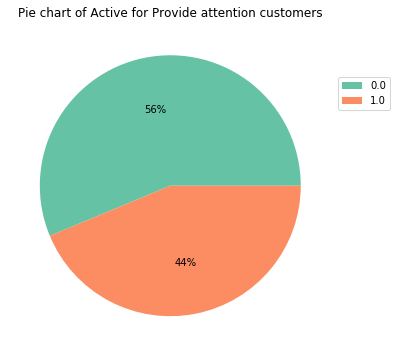

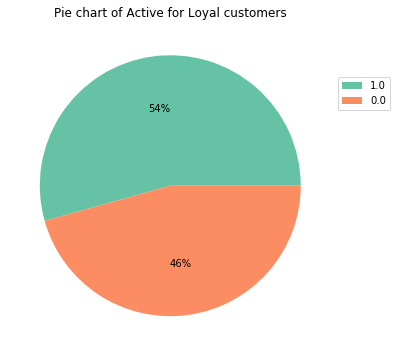

----- Variable: club_member_status -----


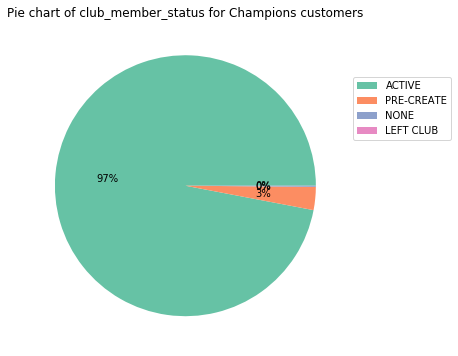

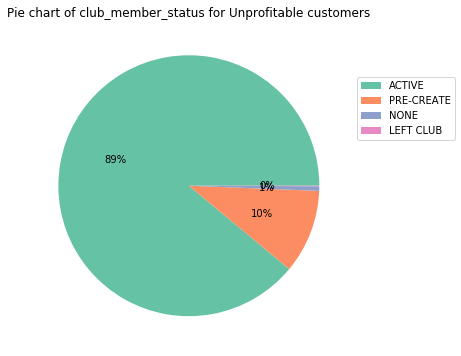

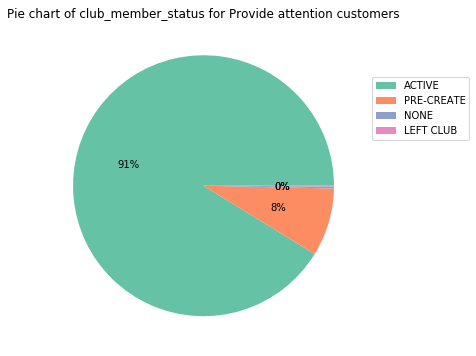

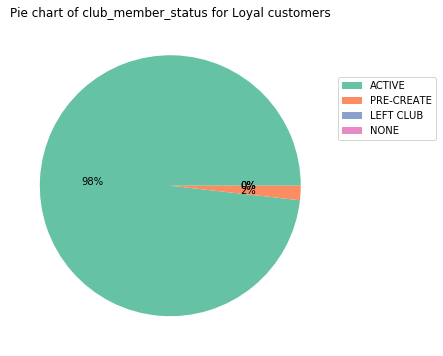

----- Variable: fashion_news_frequency -----


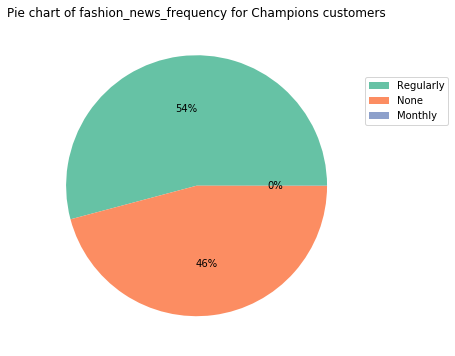

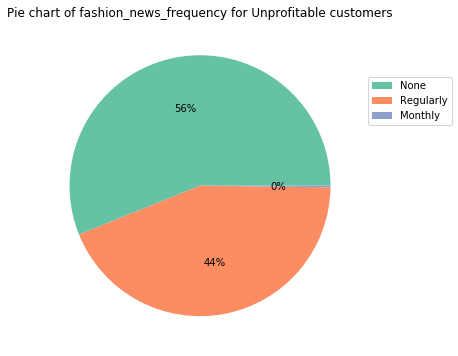

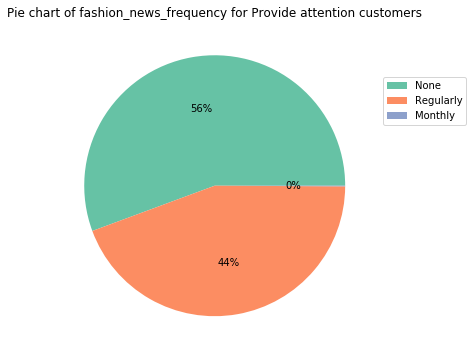

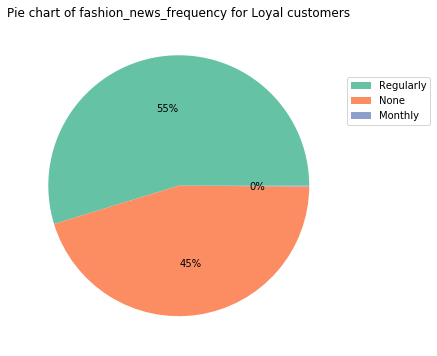

In [88]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency']:
    print('----- Variable:',col,'-----')
    for label in labels:
        fig, axes = plt.subplots(figsize=(13, 6))
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        colors = sns.color_palette('Set2')
        plt.pie(subset_df[col].value_counts(), colors=colors, autopct='%.0f%%')
        plt.title(f'Pie chart of {col} for {label} customers' )
        plt.legend(subset_df[col].value_counts().index, bbox_to_anchor = (1, 0.85))
        plt.show()

### 3.3.3 Comparing Demographics Across Variables

In [89]:
# Find number of unique values in each column
for col in customers.columns[1:]:
    print('Number of unique values in ' + col + ': ' + str(len(customers[col].unique())) + ' / ' + str(len(customers)))

Number of unique values in Active: 2 / 15538
Number of unique values in club_member_status: 4 / 15538
Number of unique values in fashion_news_frequency: 3 / 15538
Number of unique values in age: 71 / 15538
Number of unique values in postal_code: 13798 / 15538


#### Age vs Columns

--- OVERALL ANALYSIS ---

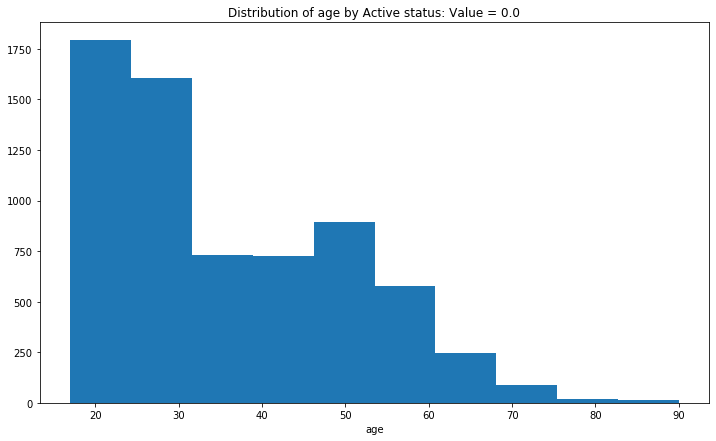

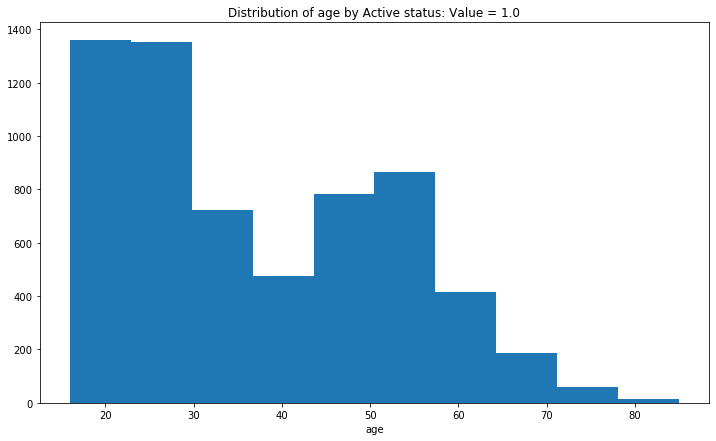

In [90]:
# For Active column
common_col = 'age'
col = 'Active'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    plt.hist(common_col, data=subset_by_item_df)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.show()

--- ANALYSIS BY CLUSTERS ---

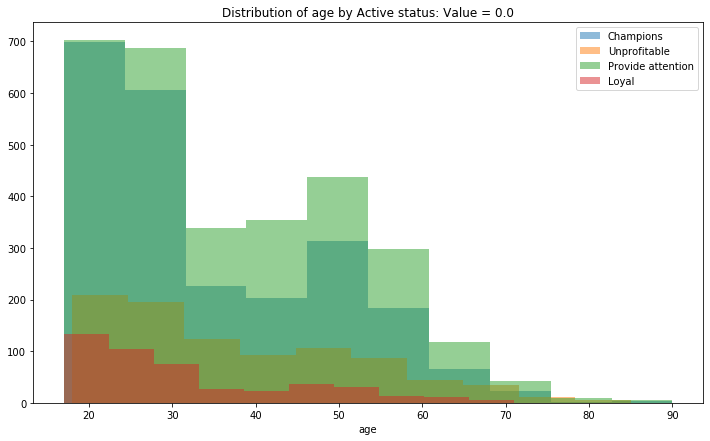

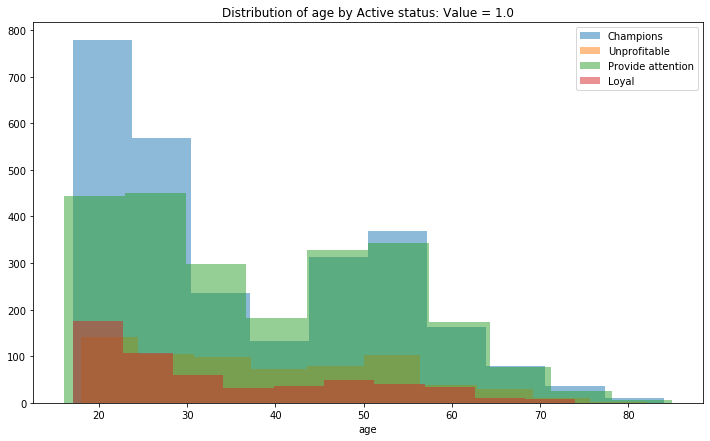

In [91]:
# For Active column
common_col = 'age'
col = 'Active'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

--- OVERALL ANALYSIS ---

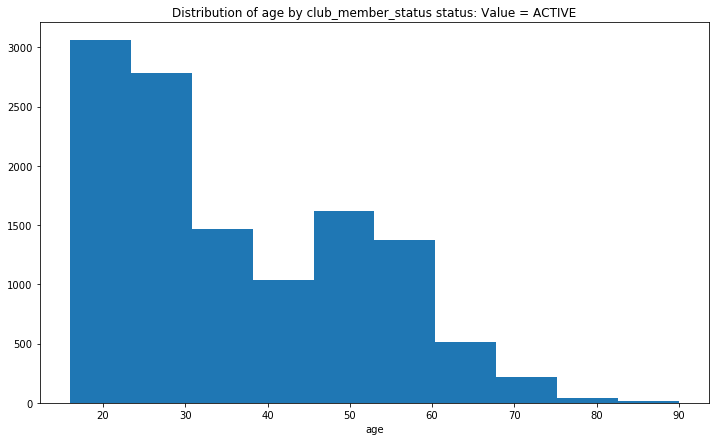

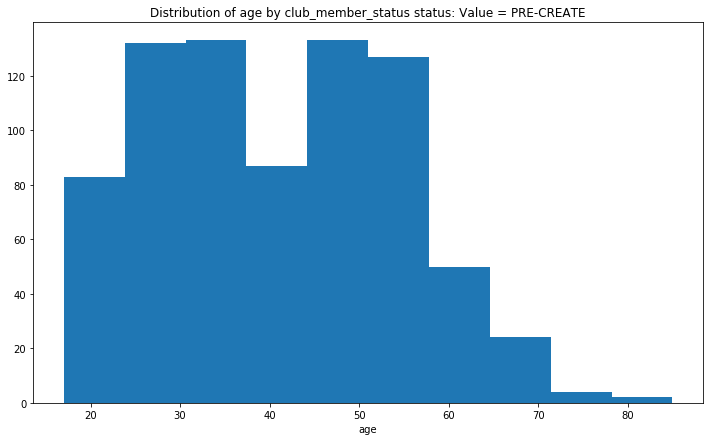

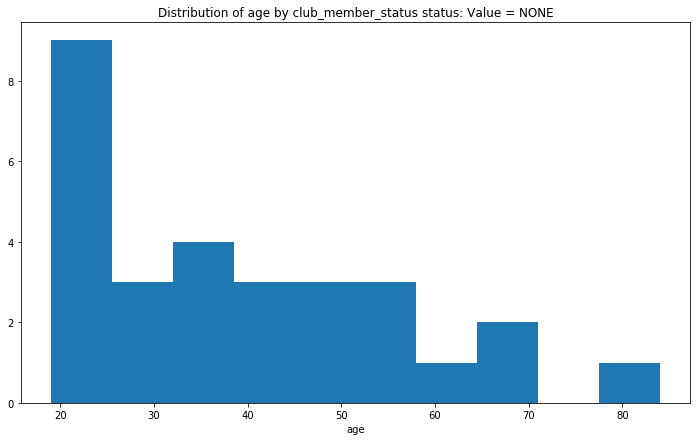

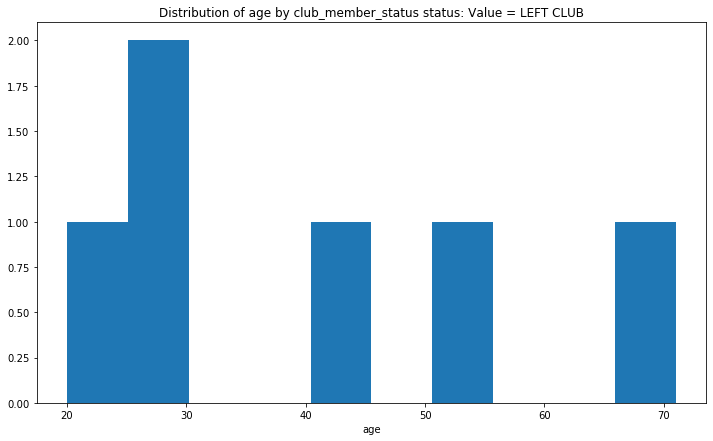

In [92]:
# For club_member_status column
common_col = 'age'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    plt.hist(common_col, data=subset_by_item_df)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.show()

--- ANALYSIS BY CLUSTERS ---

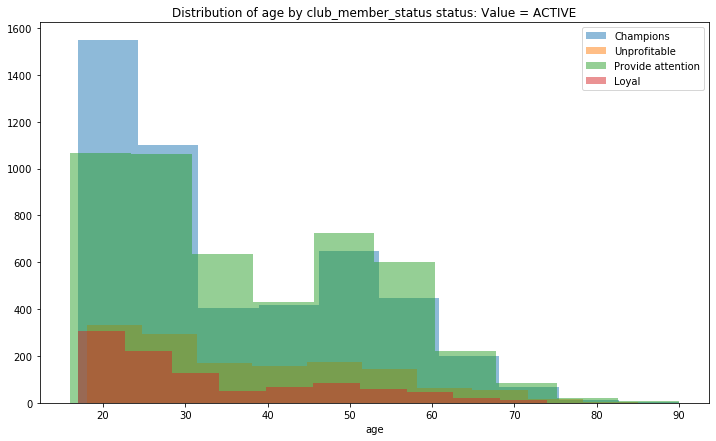

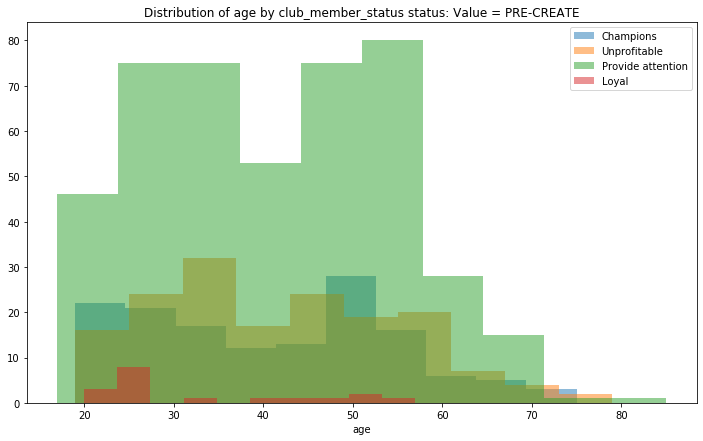

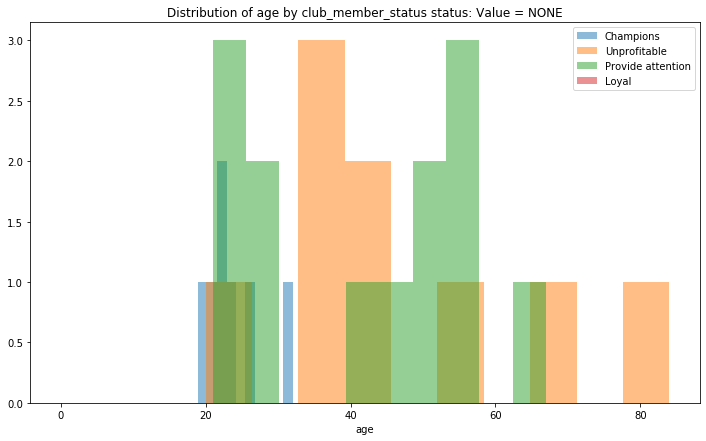

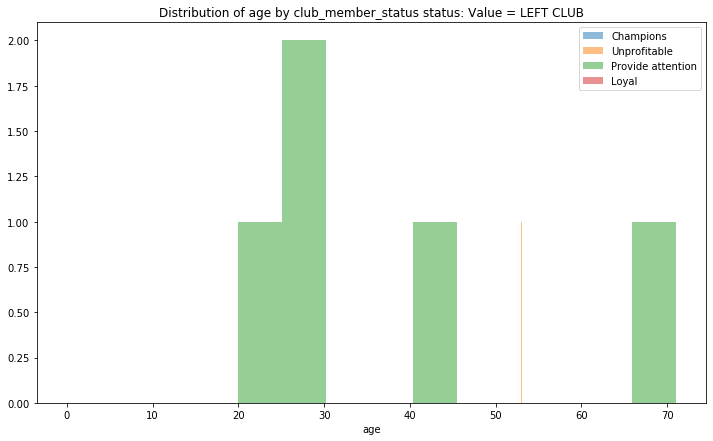

In [93]:
# For club_member_status column
common_col = 'age'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

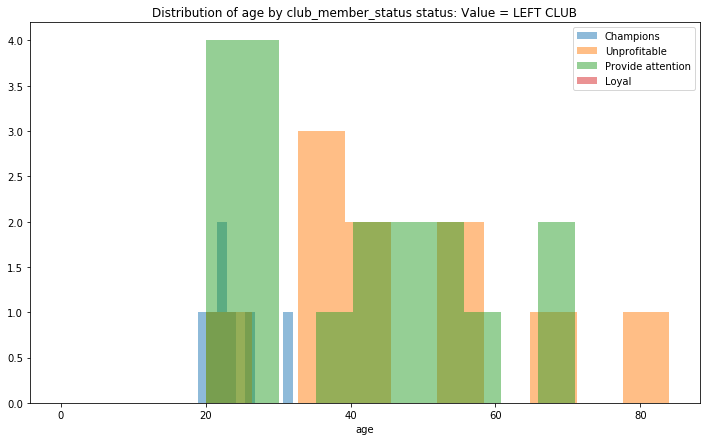

In [94]:
plt.figure(figsize=(12,7))
subset_by_item_df = rfm_customers[rfm_customers['club_member_status'].isin(['LEFT CLUB', 'NONE'])]

for label in rfm_customers['rfm_label'].unique():
    subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
    plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
plt.xlabel(f'{common_col}')
plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
plt.show()

--- OVERALL ANALYSIS ---

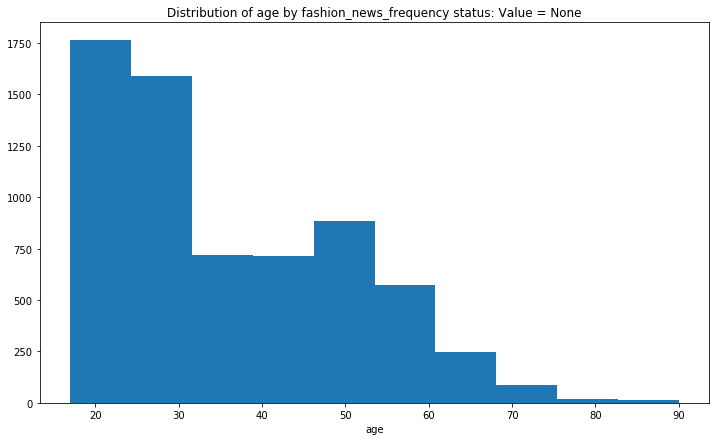

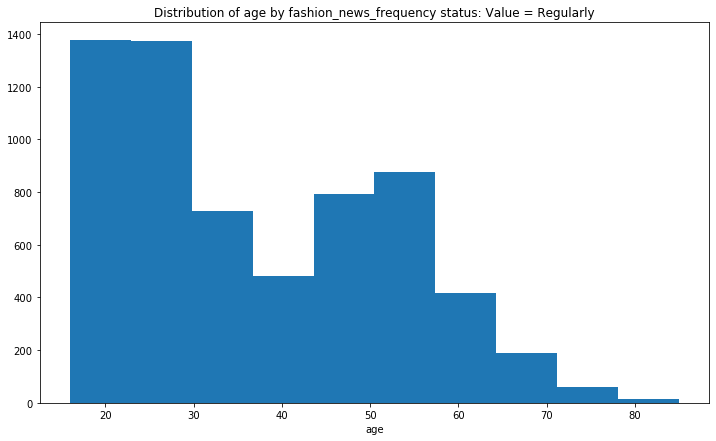

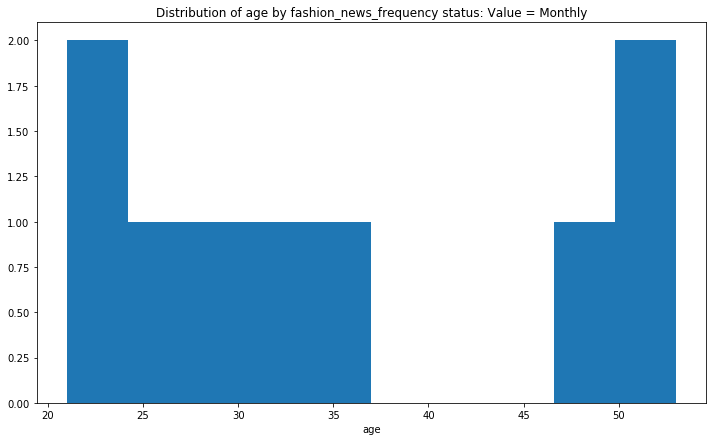

In [95]:
# For fashion_news_frequency column
common_col = 'age'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    plt.hist(common_col, data=subset_by_item_df)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.show()

--- ANALYSIS BY CLUSTERS ---

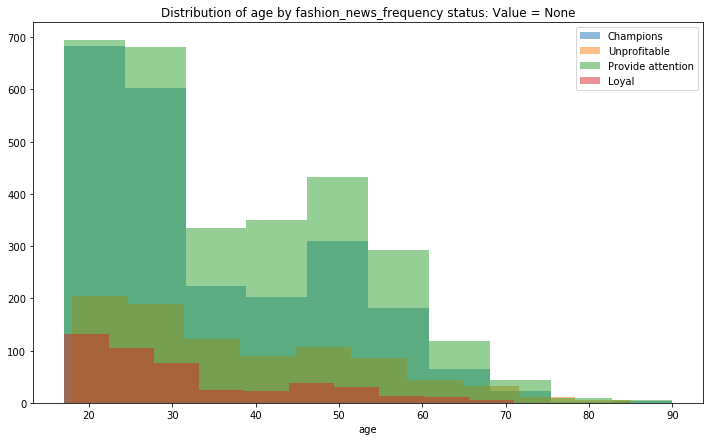

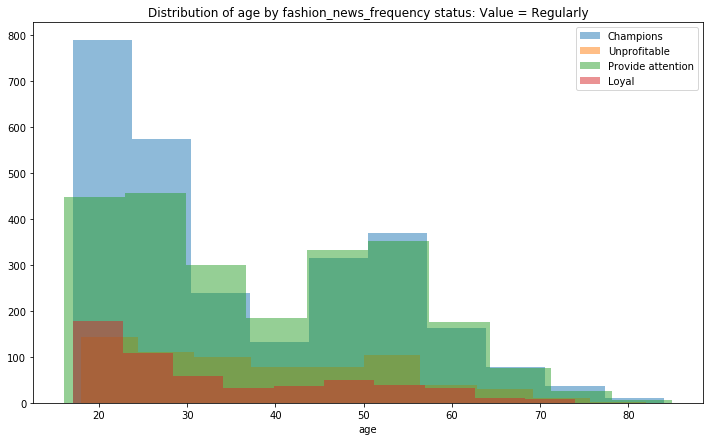

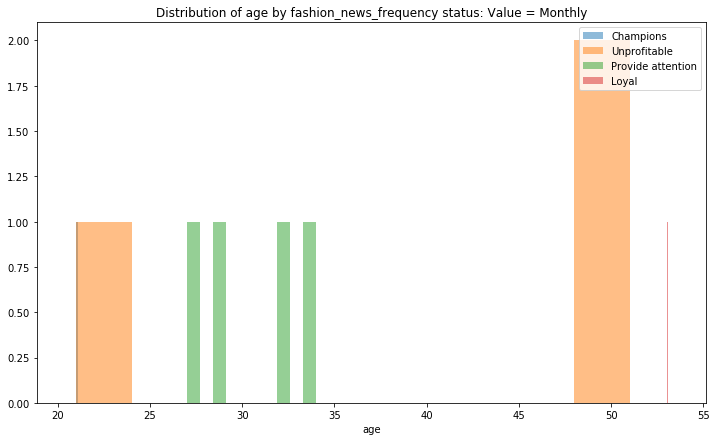

In [96]:
# For fashion_news_frequency column
common_col = 'age'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### Active vs Columns

--- OVERALL ANALYSIS ---

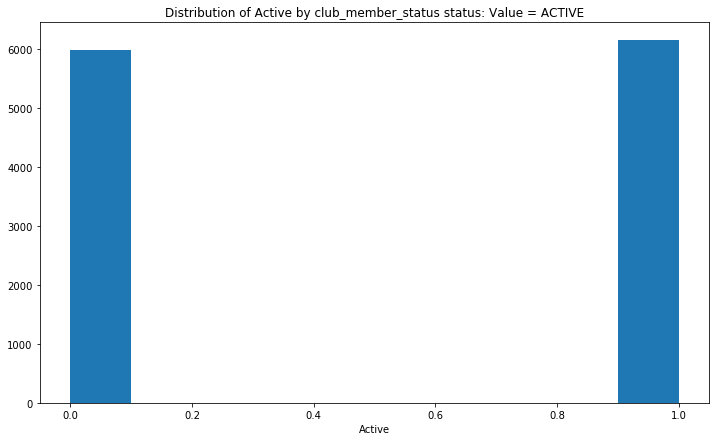

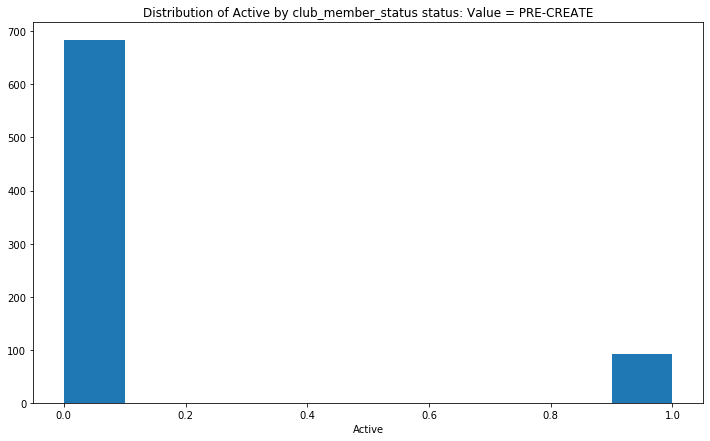

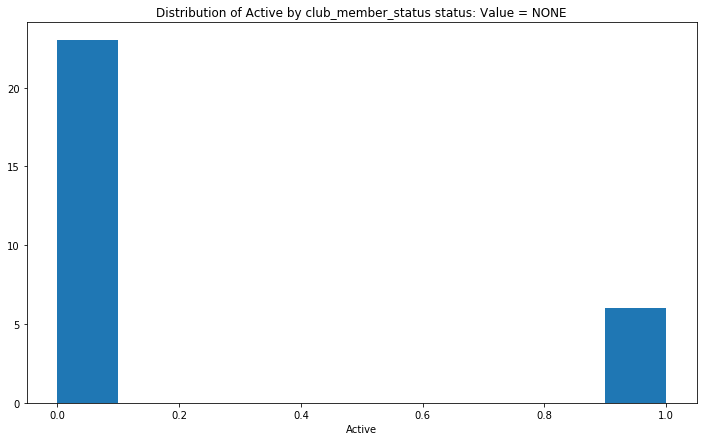

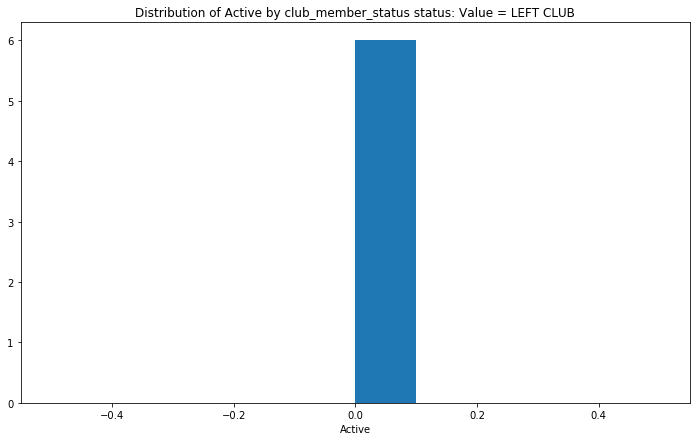

In [97]:
# For club_member_status column
common_col = 'Active'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    plt.hist(common_col, data=subset_by_item_df)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.show()

--- ANALYSIS BY CLUSTERS ---

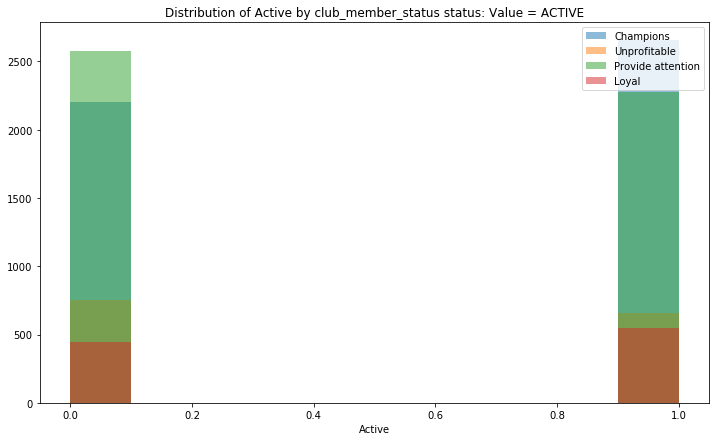

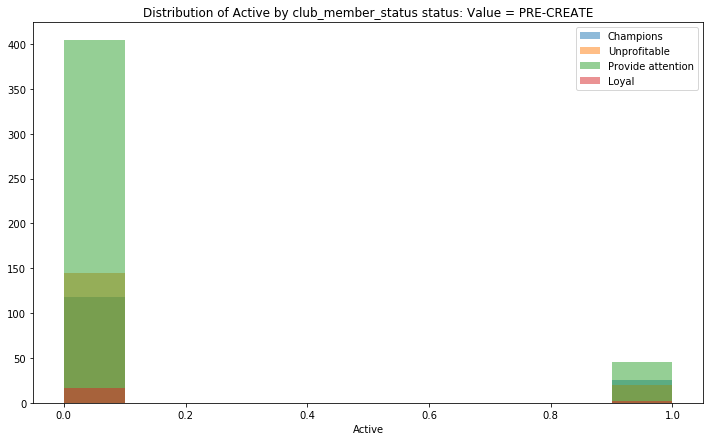

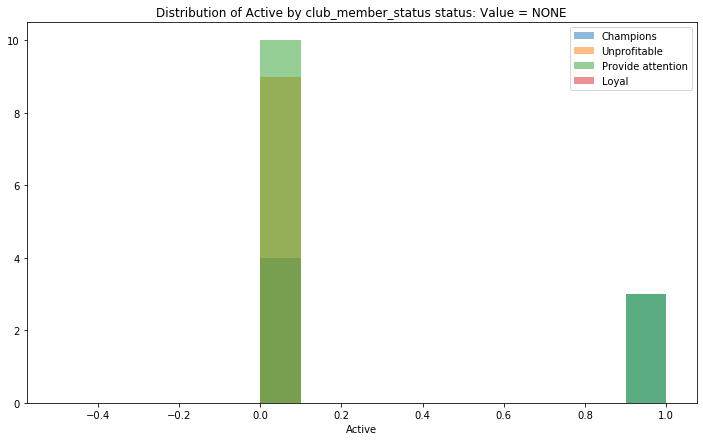

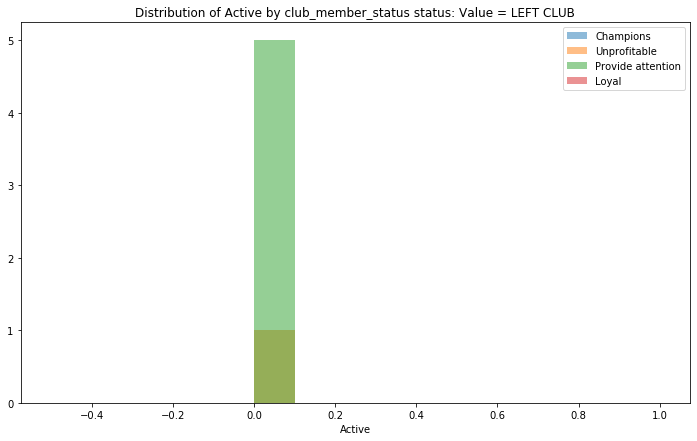

In [98]:
# For club_member_status column
common_col = 'Active'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

--- OVERALL ANALYSIS ---

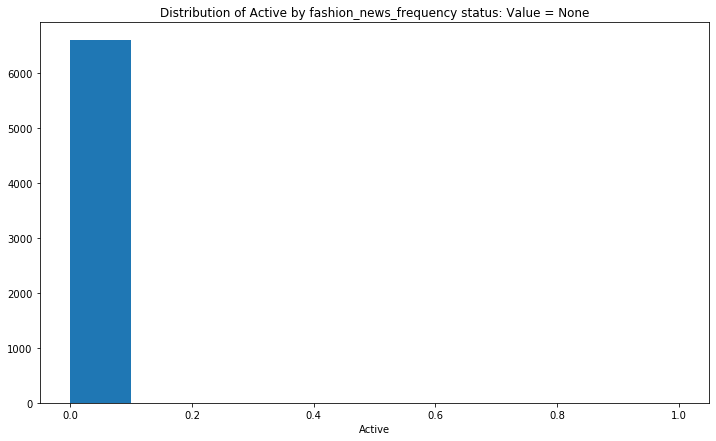

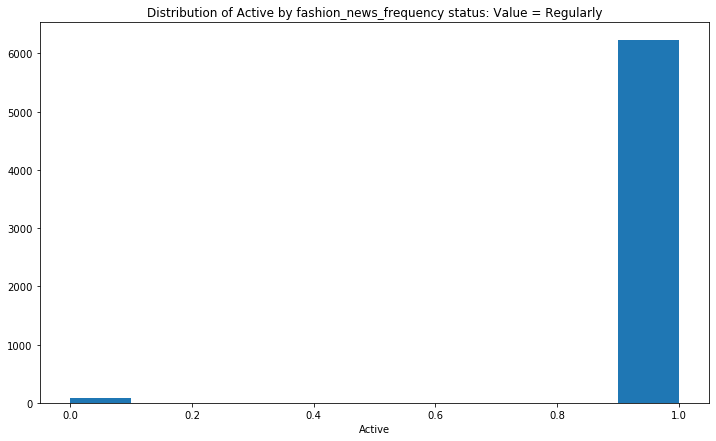

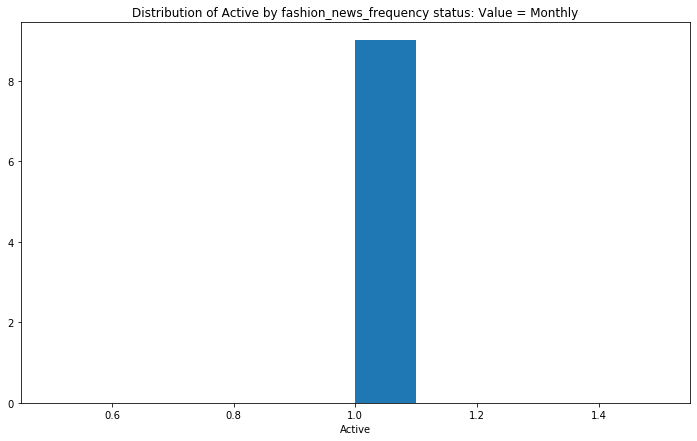

In [99]:
# For fashion_news_frequency column
common_col = 'Active'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    plt.hist(common_col, data=subset_by_item_df)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.show()

--- ANALYSIS BY CLUSTERS ---

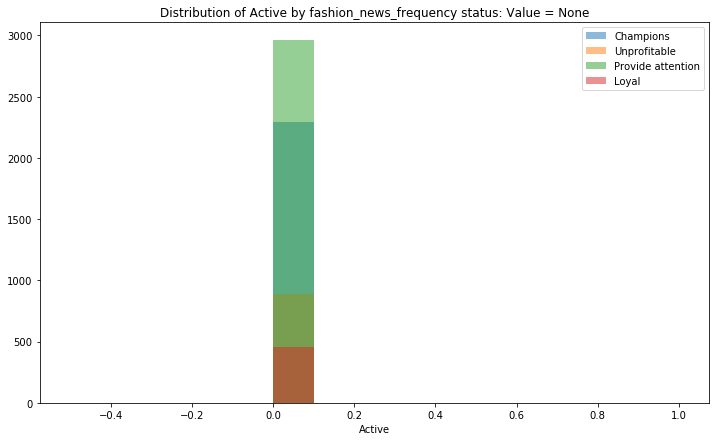

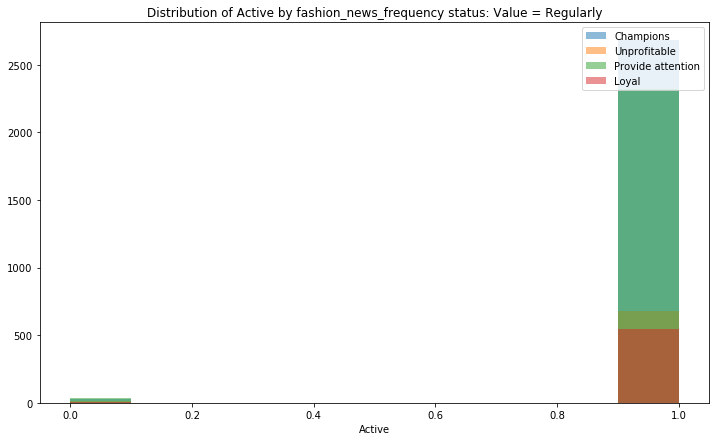

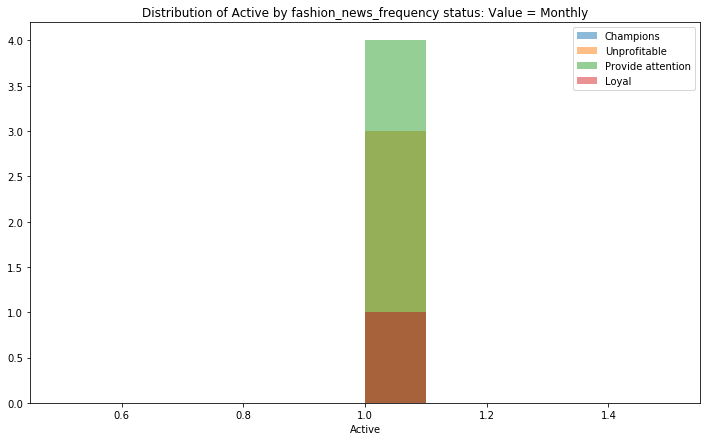

In [100]:
# For fashion_news_frequency column
common_col = 'Active'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### fashion_news_frequency vs club_member_status

--- OVERALL ANALYSIS ---

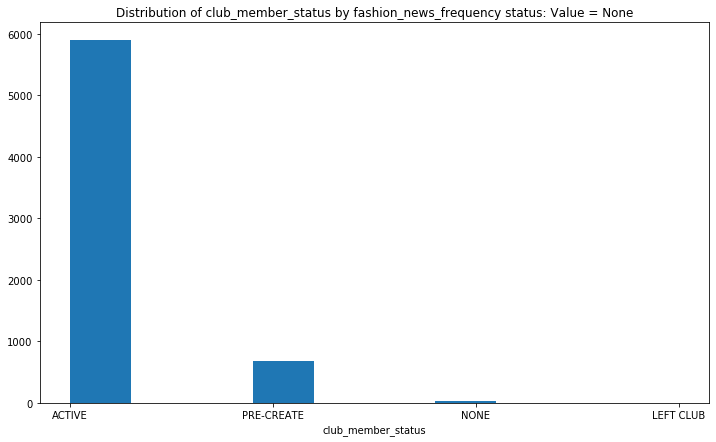

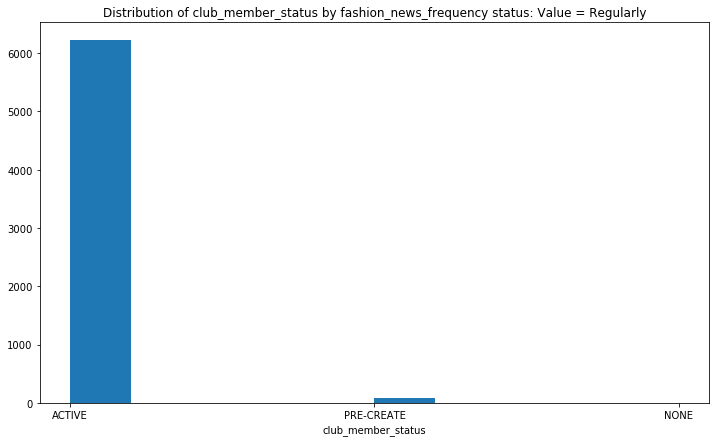

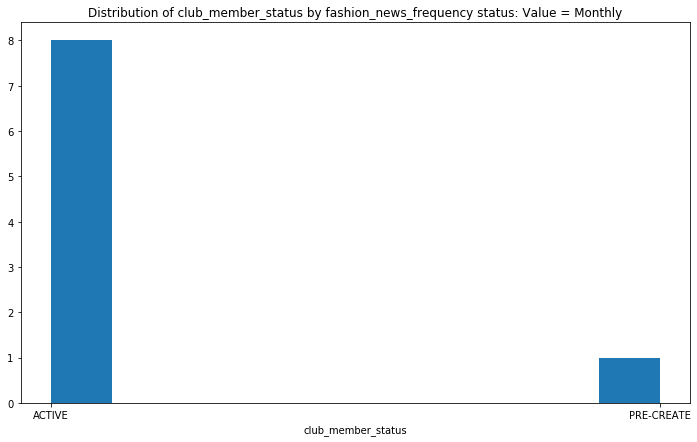

In [101]:
common_col = 'club_member_status'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    plt.hist(common_col, data=subset_by_item_df)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.show()

--- ANALYSIS BY CLUSTERS ---

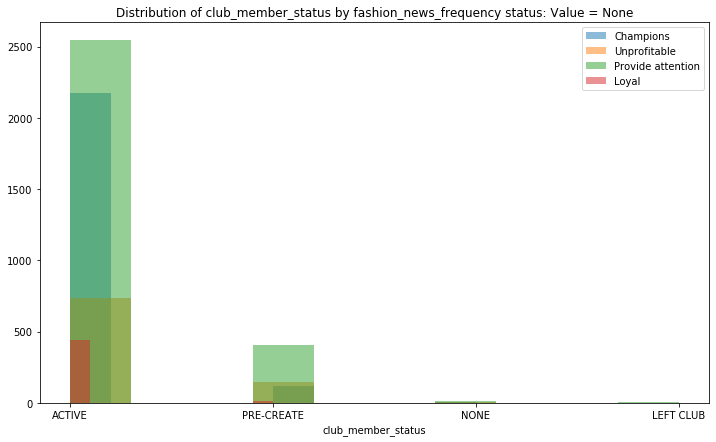

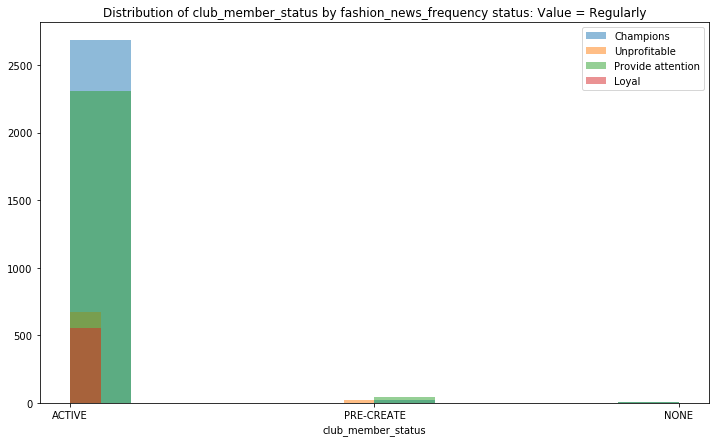

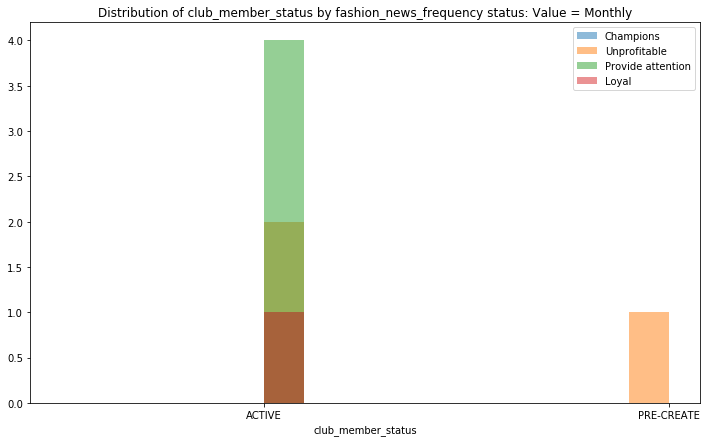

In [102]:
common_col = 'club_member_status'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

### 3.3.4 Purchase Behaviour Analysis of RFM Segments (with Transactions Data)

#### Read in CSV and Conduct Basic Analysis

In [103]:
# articles = pd.read_csv('/Users/admin/Desktop/Y4S2/BT4211/Project/articles.csv')
articles = pd.read_csv('data/articles.csv')
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [104]:
articles = articles.loc[:,['article_id','prod_name','product_type_name','product_group_name',
                          'graphical_appearance_name','colour_group_name','perceived_colour_value_name',
                          'perceived_colour_master_name','department_name','index_name','index_group_name',
                          'section_name','garment_group_name']]
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 13)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"


In [105]:
# Basic data check: Check for null values
for col in articles.columns:
    print("Number of Null Values in", col, " : ", len(articles[articles[col].isna()]), "/", len(articles))

Number of Null Values in article_id  :  0 / 105542
Number of Null Values in prod_name  :  0 / 105542
Number of Null Values in product_type_name  :  0 / 105542
Number of Null Values in product_group_name  :  0 / 105542
Number of Null Values in graphical_appearance_name  :  0 / 105542
Number of Null Values in colour_group_name  :  0 / 105542
Number of Null Values in perceived_colour_value_name  :  0 / 105542
Number of Null Values in perceived_colour_master_name  :  0 / 105542
Number of Null Values in department_name  :  0 / 105542
Number of Null Values in index_name  :  0 / 105542
Number of Null Values in index_group_name  :  0 / 105542
Number of Null Values in section_name  :  0 / 105542
Number of Null Values in garment_group_name  :  0 / 105542


In [106]:
# Convert datatypes to suitable datatypes
articles = articles.astype({'article_id':'str',
                            'prod_name':'category',
                            'product_type_name':'category',
                            'product_group_name':'category',
                            'graphical_appearance_name':'category',
                            'colour_group_name':'category',
                            'perceived_colour_value_name':'category',
                            'perceived_colour_master_name':'category',
                            'department_name':'category',
                            'index_name':'category',
                            'index_group_name':'category',
                            'section_name':'category',
                            'garment_group_name':'category'})
articles.dtypes

article_id                        object
prod_name                       category
product_type_name               category
product_group_name              category
graphical_appearance_name       category
colour_group_name               category
perceived_colour_value_name     category
perceived_colour_master_name    category
department_name                 category
index_name                      category
index_group_name                category
section_name                    category
garment_group_name              category
dtype: object

In [107]:
# Merge Articles with Transaction Data on article_id (Transations data is df_new subsetted at the start)
article_transaction = articles.merge(df_new, on='article_id')

# Merge Article+Transaction with RFM Data on customer_id
rfm_article_transact = article_transaction.merge(df_rfm[['customer_id','Frequency','Monetary','rfm_label']], on='customer_id')

print('Dataframe shape:',rfm_article_transact.shape)
rfm_article_transact.head()

Dataframe shape: (150636, 20)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,customer_id,t_dat,price,sales_channel_id,Frequency,Monetary,rfm_label
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,03de599982c9b24897413f3da2753e288f7605e52214a4...,2018-09-24,0.008458,2,39,25.233811,Champions
1,413029008,Skinny Ankle H.W,Trousers,Garment Lower body,Denim,White,Light,White,Denim Trousers,Divided,Divided,Ladies Denim,Trousers Denim,03de599982c9b24897413f3da2753e288f7605e52214a4...,2019-03-10,0.027102,2,39,25.233811,Champions
2,538598001,Spirit Split LS,Hoodie,Garment Upper body,Placement print,Black,Dark,Black,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,03de599982c9b24897413f3da2753e288f7605e52214a4...,2020-03-12,0.008458,2,39,25.233811,Champions
3,570489001,Dadi hood,Hoodie,Garment Upper body,Placement print,Black,Dark,Black,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,03de599982c9b24897413f3da2753e288f7605e52214a4...,2019-01-26,0.016932,2,39,25.233811,Champions
4,630319001,Jet tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,03de599982c9b24897413f3da2753e288f7605e52214a4...,2018-09-24,0.013542,2,39,25.233811,Champions


#### Remove irrelevant columns and put customer_id to the front of the dataframe

In [108]:
# Drop columns that are not needed
rfm_article_transact = rfm_article_transact.drop(['article_id','t_dat','Frequency','Monetary'], axis=1)

# Place customer_id in the 1st column
customer_id = rfm_article_transact['customer_id']
rfm_article_transact.drop(labels=['customer_id'], axis=1, inplace=True)
rfm_article_transact.insert(0, 'customer_id', customer_id)

rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,rfm_label
0,03de599982c9b24897413f3da2753e288f7605e52214a4...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,2,Champions
1,03de599982c9b24897413f3da2753e288f7605e52214a4...,Skinny Ankle H.W,Trousers,Garment Lower body,Denim,White,Light,White,Denim Trousers,Divided,Divided,Ladies Denim,Trousers Denim,0.027102,2,Champions
2,03de599982c9b24897413f3da2753e288f7605e52214a4...,Spirit Split LS,Hoodie,Garment Upper body,Placement print,Black,Dark,Black,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,0.008458,2,Champions
3,03de599982c9b24897413f3da2753e288f7605e52214a4...,Dadi hood,Hoodie,Garment Upper body,Placement print,Black,Dark,Black,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,0.016932,2,Champions
4,03de599982c9b24897413f3da2753e288f7605e52214a4...,Jet tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.013542,2,Champions


#### Purchase Behaviour Analysis 1: Descriptive analysis

--- OVERALL ANALYSIS ---

In [109]:
rfm_article_transact[['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
               'perceived_colour_value_name','perceived_colour_master_name','department_name',
               'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']].describe()

,prod_name,product_type_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,sales_channel_id
count,150636,150636,150636,150636,150636,150636,150636,150636,150636,150636,150636,150636
unique,18863,111,30,50,8,19,237,10,5,56,21,2
top,Jade HW Skinny Denim TRS,Trousers,Solid,Black,Dark,Black,Swimwear,Ladieswear,Ladieswear,Womens Everyday Collection,Jersey Fancy,2
freq,929,19466,83086,52671,74340,52311,12548,58307,95296,26744,25645,91710


--- ANALYSIS BY CLUSTERS ---

In [110]:
rfm_article_transact.groupby('rfm_label')['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
               'perceived_colour_value_name','perceived_colour_master_name','department_name',
               'index_name','index_group_name','section_name','garment_group_name','sales_channel_id'].describe()

prod_name                                        \
                      count unique                       top freq   
rfm_label                                                           
Champions             85603  14469  Jade HW Skinny Denim TRS  603   
Loyal                 14308   5458                 Tilly (1)  135   
Provide attention     44324  10583            Luna skinny RW  275   
Unprofitable           6401   3143                  Moa tank   39   

                  product_type_name                          \
                              count unique       top   freq   
rfm_label                                                     
Champions                     85603    107  Trousers  11226   
Loyal                         14308     96   T-shirt   1693   
Provide attention             44324    101  Trousers   6399   
Unprofitable                   6401     86   T-shirt    804   

                  graphical_appearance_name                       \
                                      count unique    top   freq   
rfm_label                                                          
Champions                             85603     30  Solid  48243   
Loyal                                 14308     28  Solid   8072   
Provide attention                     44324     29  Solid  23630   
Unprofitable                           6401     28  Solid   3141   

                  colour_group_name                       \
                              count unique    top   freq   
rfm_label                                                  
Champions                     85603     49  Black  29846   
Loyal                         14308     50  Black   4791   
Provide attention             44324     49  Black  16123   
Unprofitable                   6401     49  Black   1911   

                  perceived_colour_value_name                      \
                                        count unique   top   freq   
rfm_label                                                           
Champions                               85603      8  Dark  41369   
Loyal                                   14308      8  Dark   6543   
Provide attention                       44324      8  Dark  23417   
Unprofitable                             6401      7  Dark   3011   

                  perceived_colour_master_name                       \
                                         count unique    top   freq   
rfm_label                                                             
Champions                                85603     18  Black  29710   
Loyal                                    14308     18  Black   4755   
Provide attention                        44324     19  Black  15960   
Unprofitable                              6401     18  Black   1886   

                  department_name                        index_name         \
                            count unique       top  freq      count unique   
rfm_label                                                                    
Champions                   85603    234  Swimwear  7889      85603     10   
Loyal                       14308    205  Swimwear  1209      14308     10   
Provide attention           44324    224  Swimwear  2976      44324     10   
Unprofitable                 6401    194  Swimwear   474       6401     10   

                                     index_group_name                     \
                          top   freq            count unique         top   
rfm_label                                                                  
Champions          Ladieswear  34406            85603      5  Ladieswear   
Loyal              Ladieswear   4540            14308      5  Ladieswear   
Provide attention  Ladieswear  17595            44324      5  Ladieswear   
Unprofitable       Ladieswear   1766             6401      5  Ladieswear   

                         section_name                                     \
                    freq        count unique            

#### Purchase Behaviour Analysis 2: Analysis of purchase behaviour by segments (Bottom 2 analyses are the same just displayed in different sequences)

#### - Purchase Behaviour Analysis 2.1: Compare purchase behaviour within RFM segments (Same as Graphical Analysis but in number form)

In [111]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### - Purchase Behaviour Analysis 2.2: Compare purchase behaviour across RFM segments (Same as Graphical Analysis but in number form)

In [112]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#     print('----- Column:',col,'-----')
#     for label in labels:
#         print('RFM Segment:',label)
#         subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### Purchase Behaviour Analysis 3: Graphical Analysis for the different RFM Segments (Bottom 2 analyses are the same just displayed in different sequences)

In [113]:
def barplot(df, segment, var_col, xticklabels, rotate=False):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.bar(xticklabels, df[var_col])
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

#     ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Bar chart of {var_col} for {segment}')
    plt.show()

#### - Purchase Behaviour Analysis 3.1: View graphs by RFM Segments (Compare within RFM Segments) [Based on Top 10 categories]

In [114]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
#         if len(value_counts) > 10:
#             value_counts = value_counts[:10]
#         barplot(value_counts, label, col, value_counts.index, rotate=True)
#         print('\n')

#### - Purchase Behaviour Analysis 3.2: View graphs by Variables (Compare across RFM Segments)

--- OVERALL ANALYSIS ---

----- Variable: prod_name -----


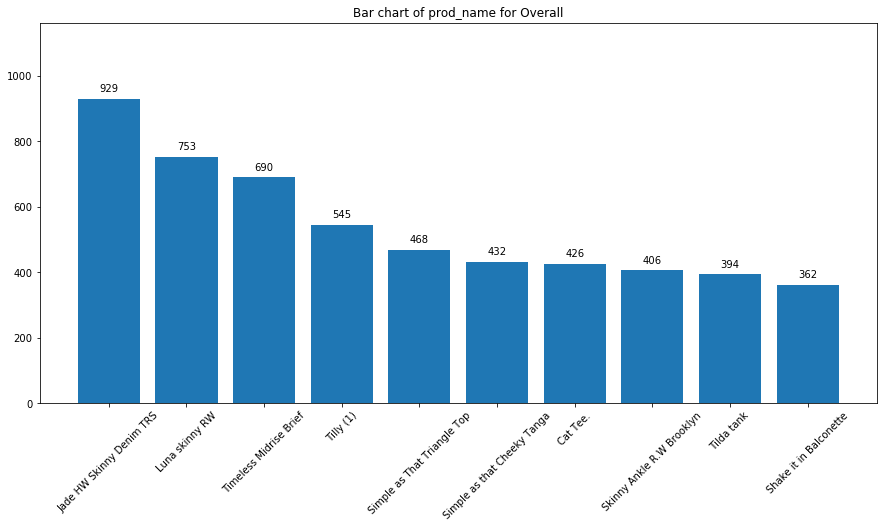



----- Variable: product_type_name -----


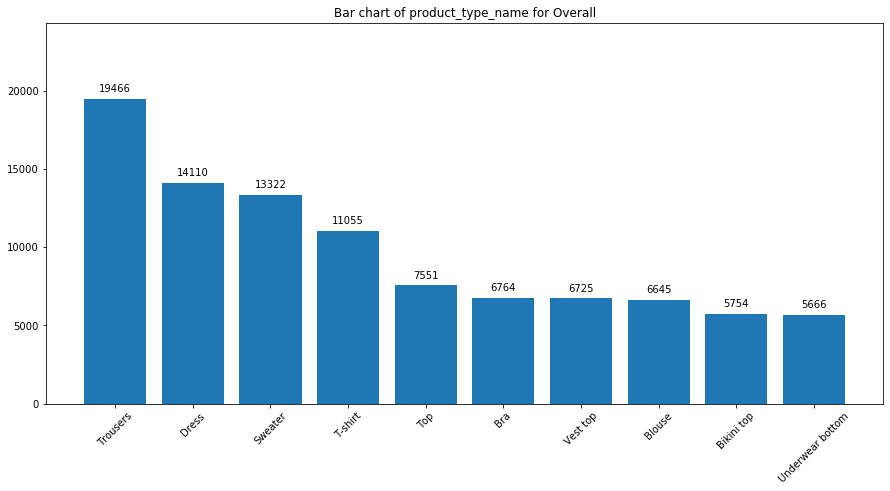



----- Variable: graphical_appearance_name -----


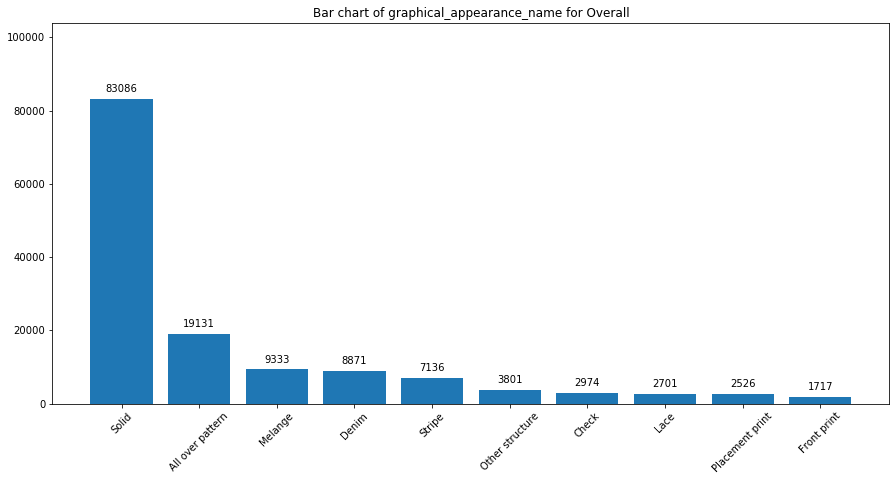



----- Variable: colour_group_name -----


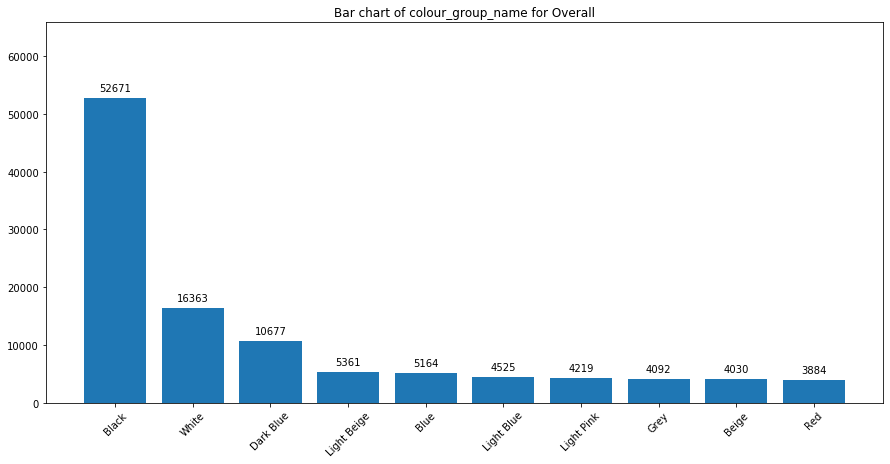



----- Variable: perceived_colour_value_name -----


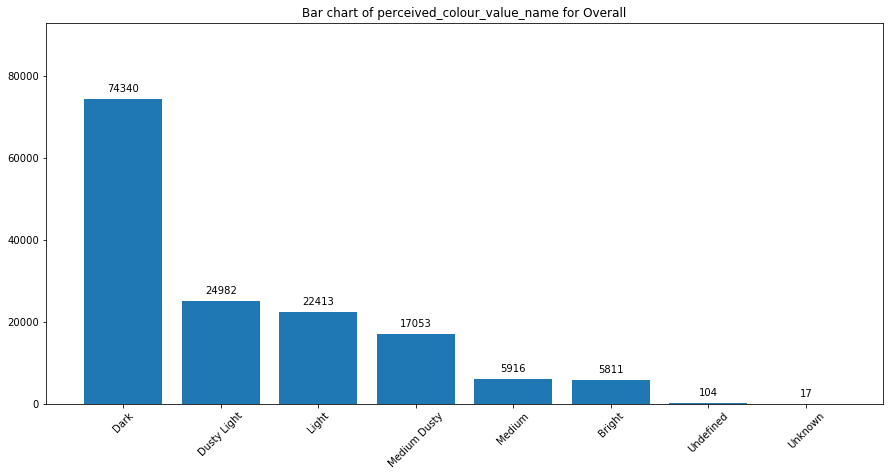



----- Variable: perceived_colour_master_name -----


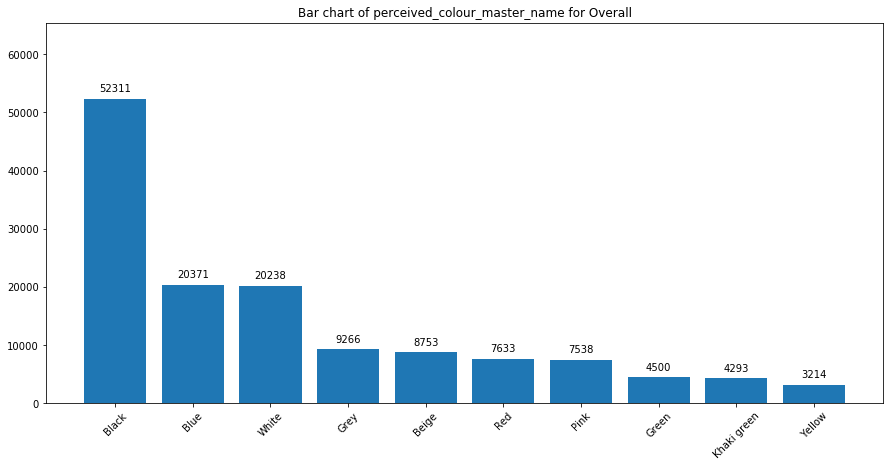



----- Variable: department_name -----


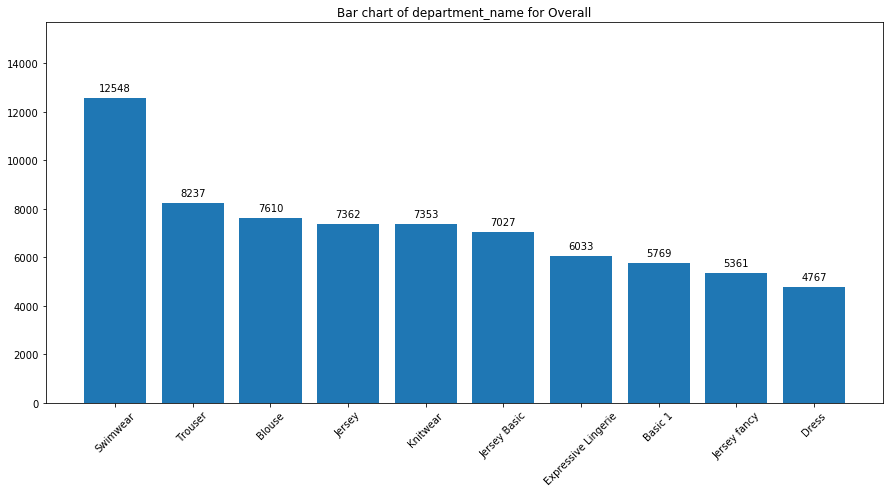



----- Variable: index_name -----


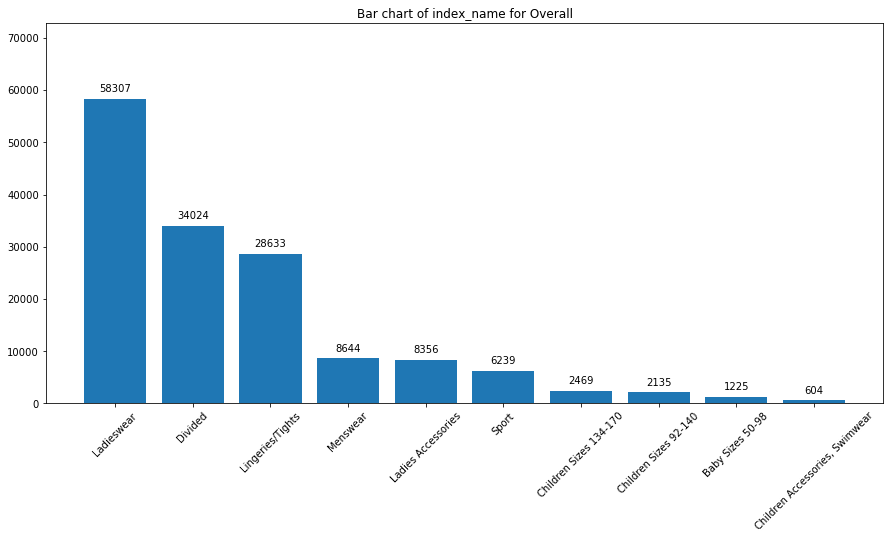



----- Variable: index_group_name -----


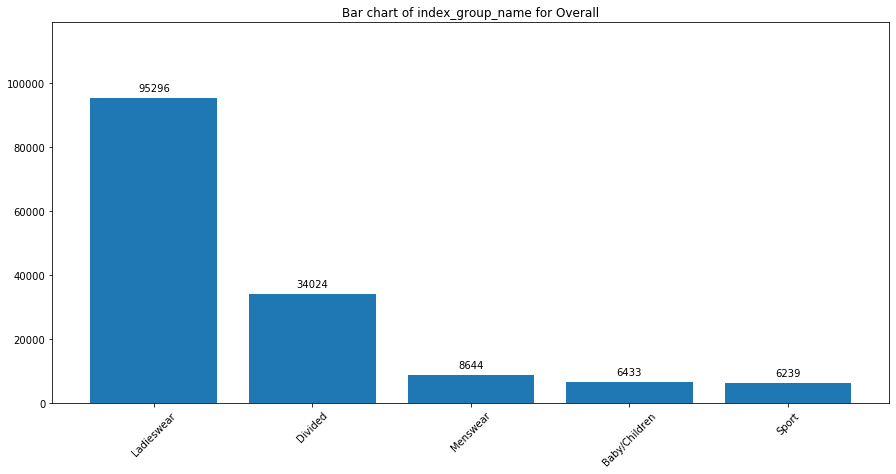



----- Variable: section_name -----


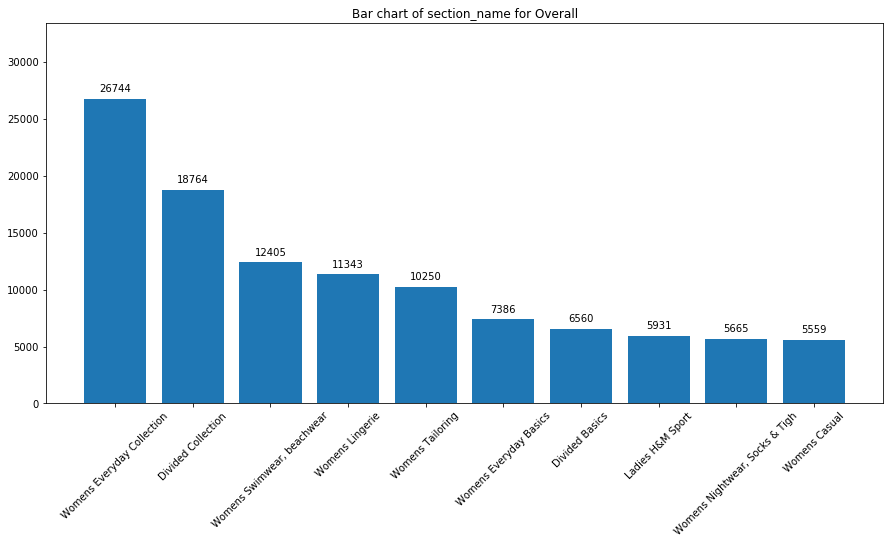



----- Variable: garment_group_name -----


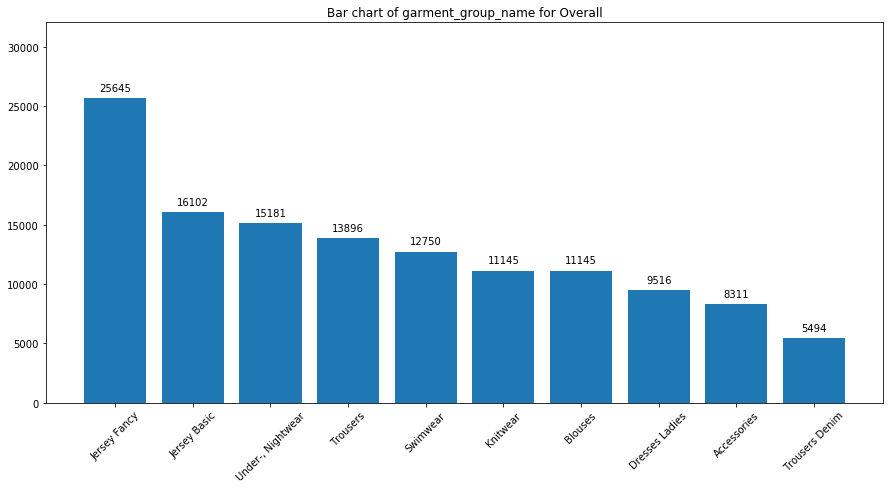



----- Variable: sales_channel_id -----


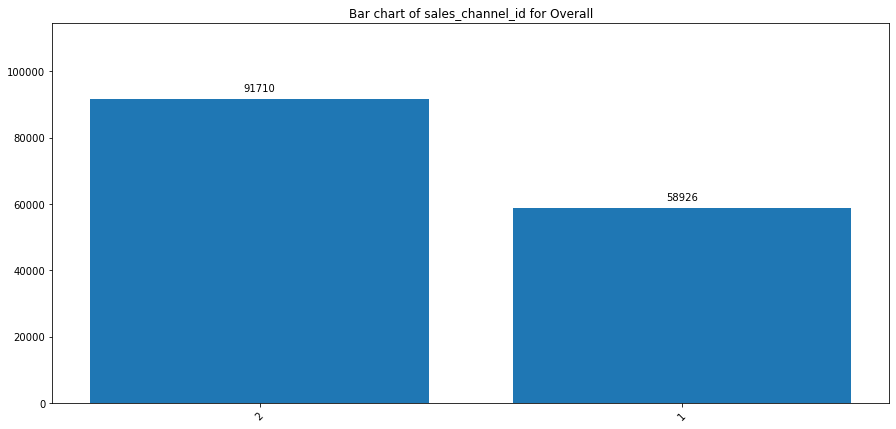

In [115]:
# Based on Top 10 categories in each column variable
label = 'Overall'
for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
           'perceived_colour_value_name','perceived_colour_master_name','department_name',
           'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
    print('----- Variable:',col,'-----')
    value_counts = rfm_article_transact[col].value_counts().loc[lambda x: x>0].to_frame()
    if len(value_counts) > 10:
        value_counts = value_counts[:10]
    barplot(value_counts, label, col, value_counts.index, rotate=True)
    print('\n')

--- ANALYSIS BY CLUSTERS ---

----- Variable: prod_name -----
RFM Segment: Champions


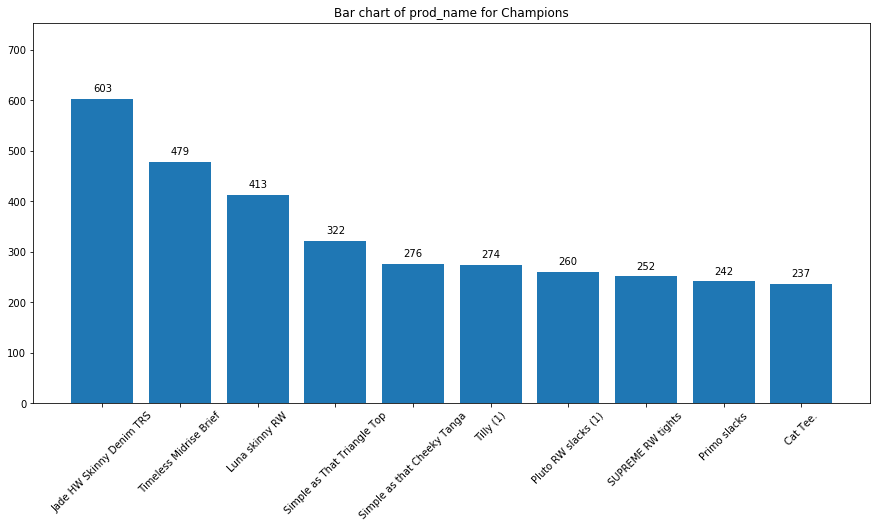



RFM Segment: Loyal


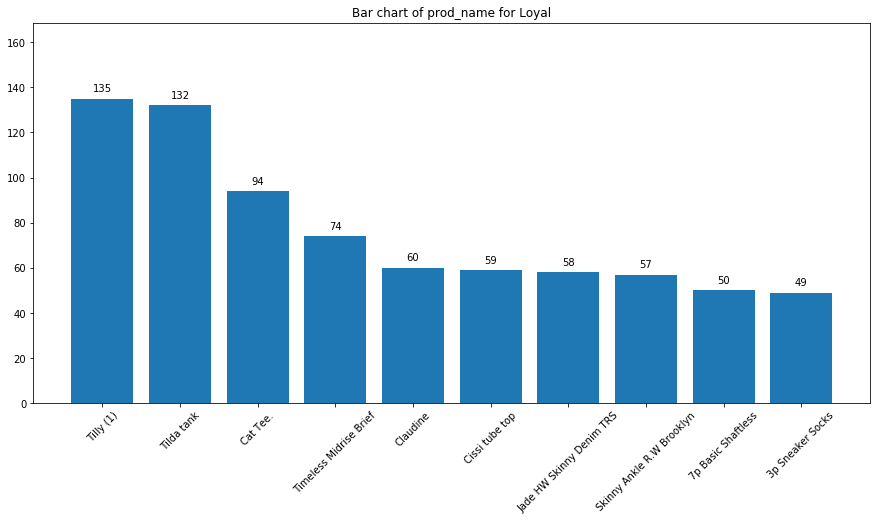



RFM Segment: Unprofitable


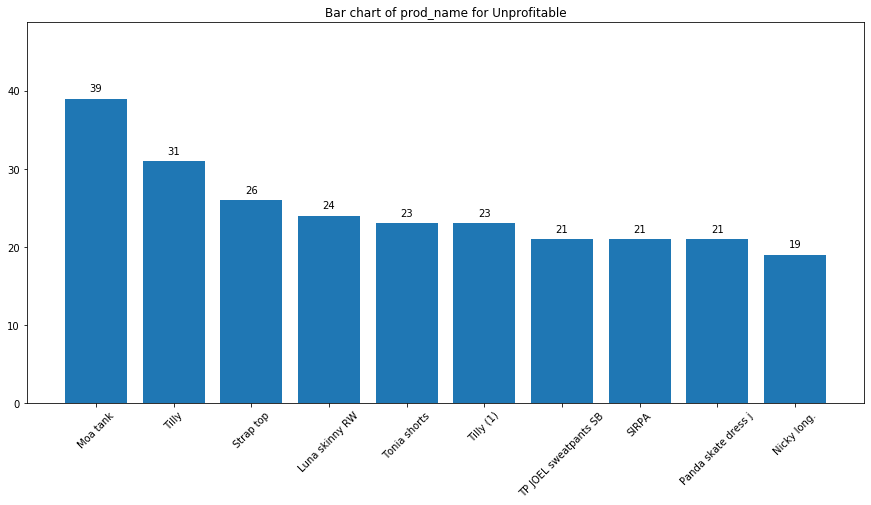



RFM Segment: Provide attention


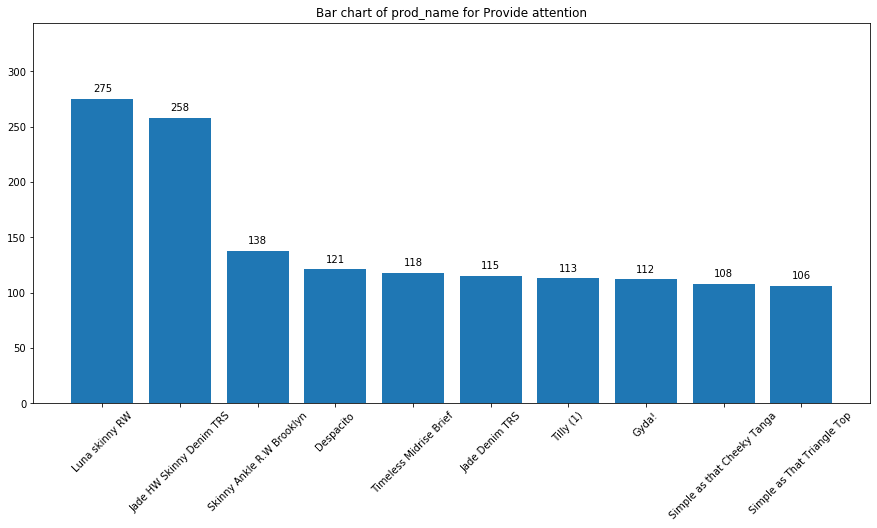



----- Variable: product_type_name -----
RFM Segment: Champions


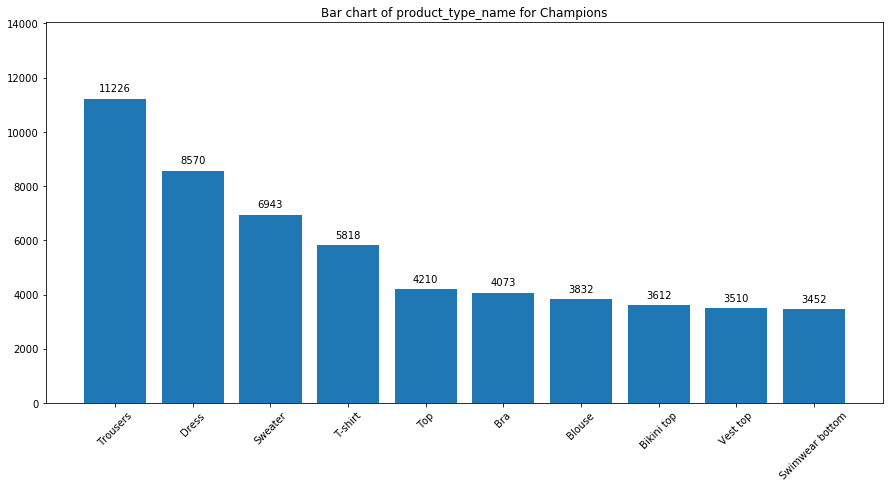



RFM Segment: Loyal


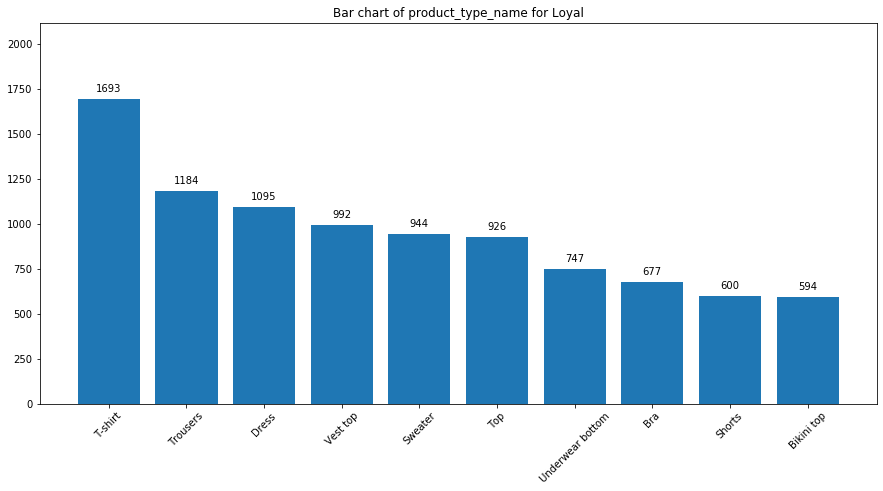



RFM Segment: Unprofitable


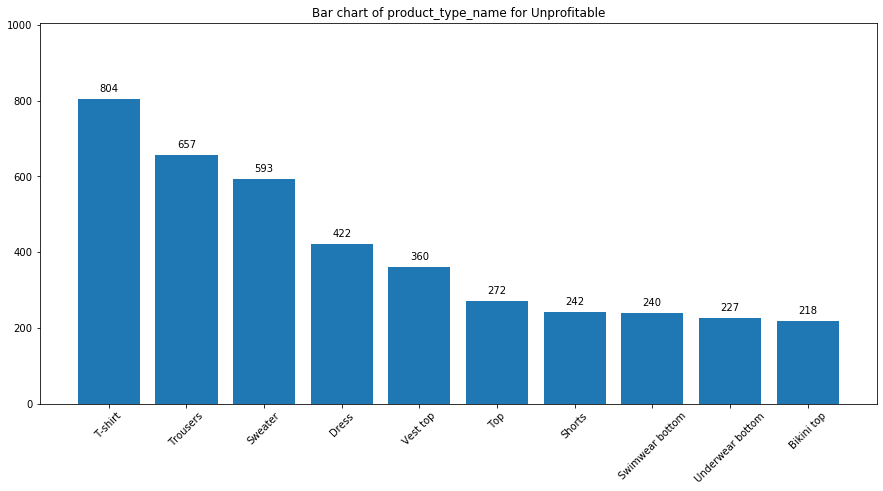



RFM Segment: Provide attention


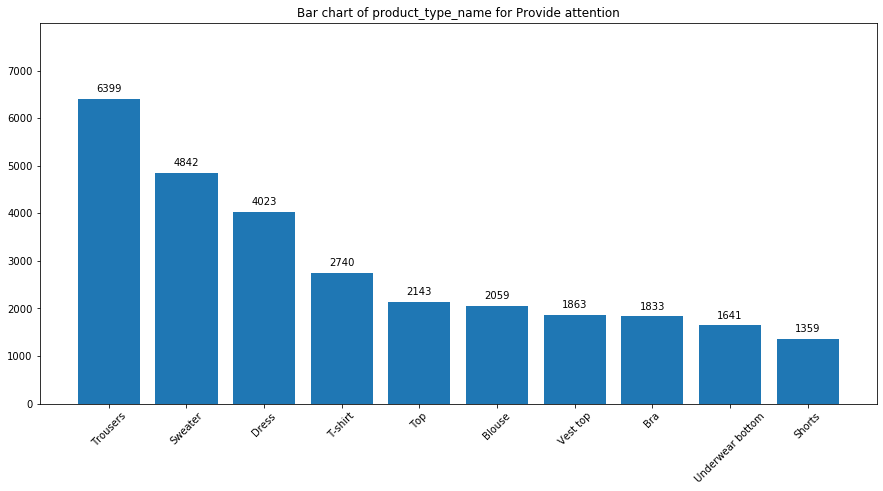



----- Variable: graphical_appearance_name -----
RFM Segment: Champions


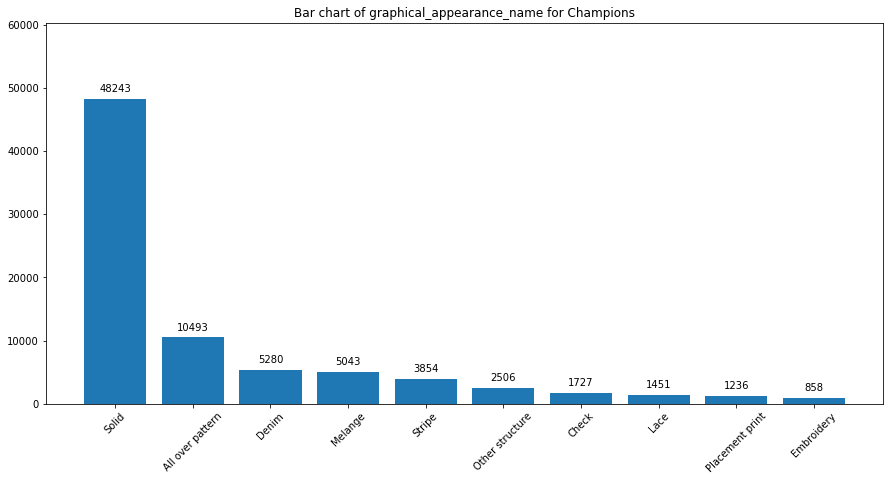



RFM Segment: Loyal


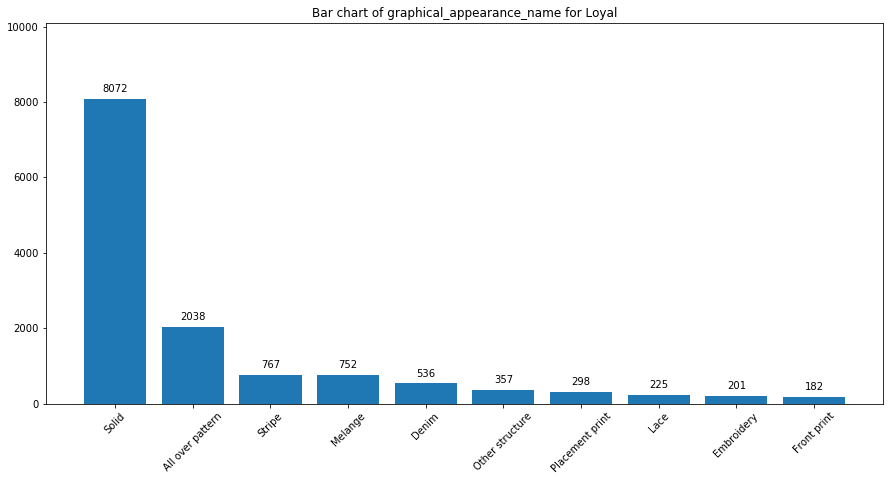



RFM Segment: Unprofitable


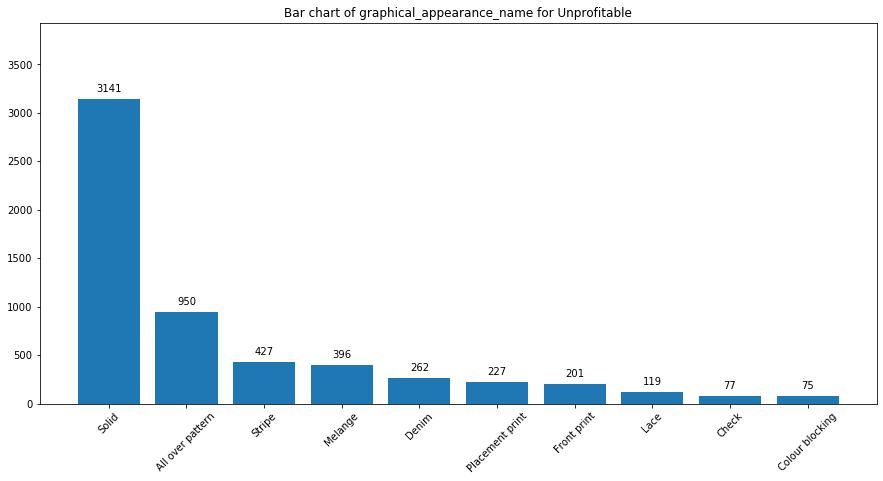



RFM Segment: Provide attention


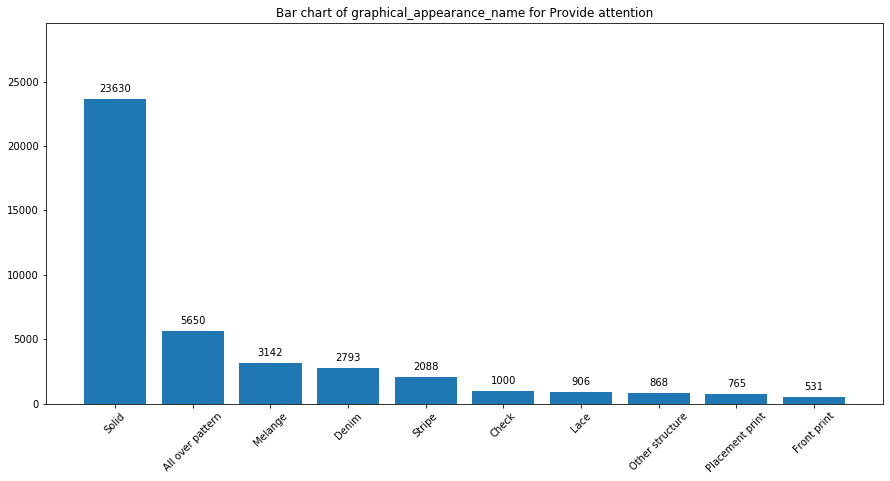



----- Variable: colour_group_name -----
RFM Segment: Champions


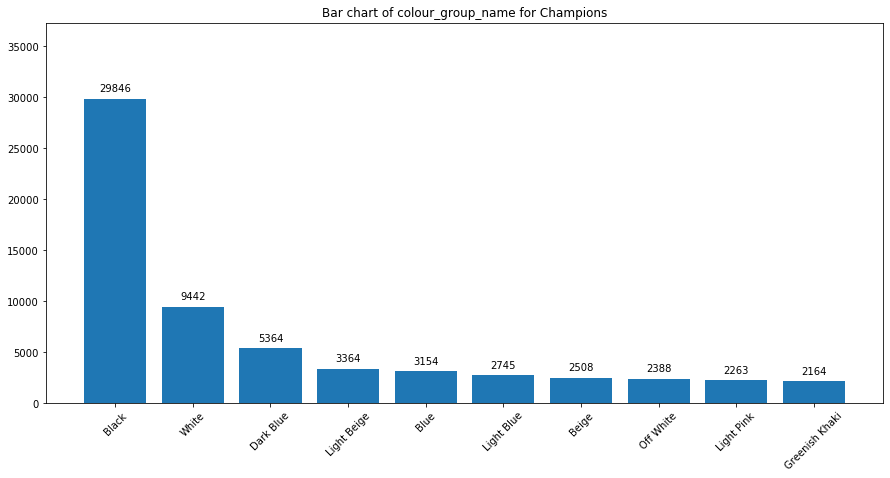



RFM Segment: Loyal


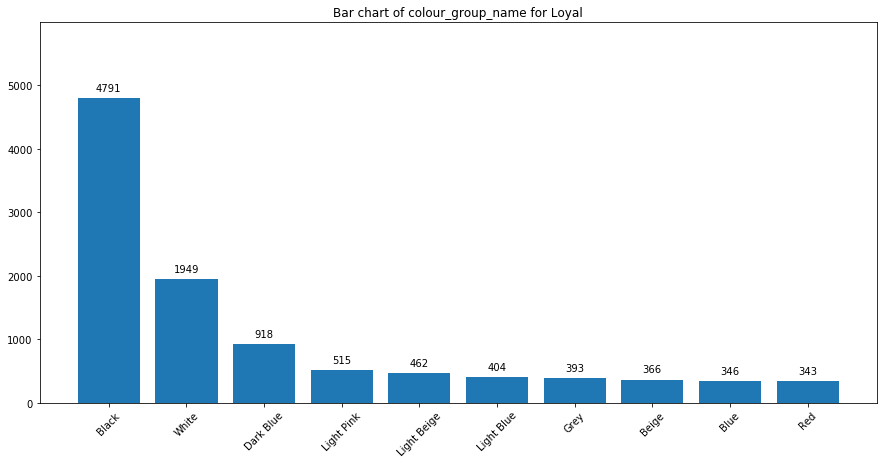



RFM Segment: Unprofitable


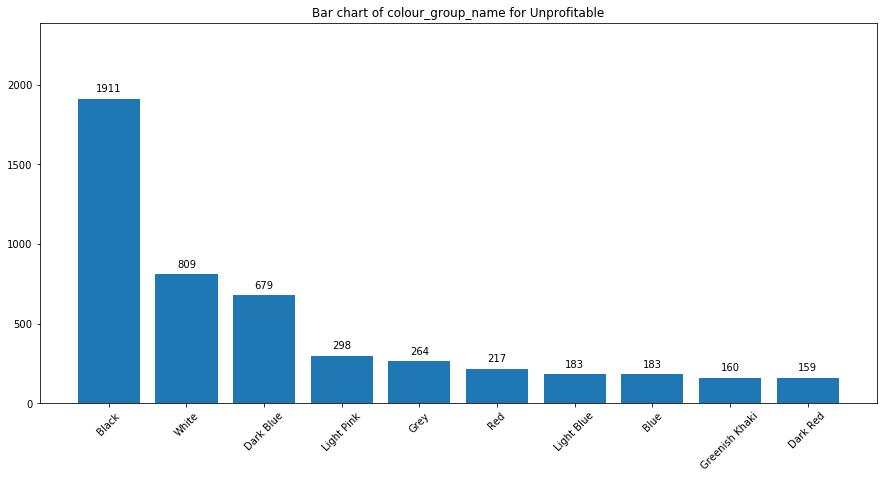



RFM Segment: Provide attention


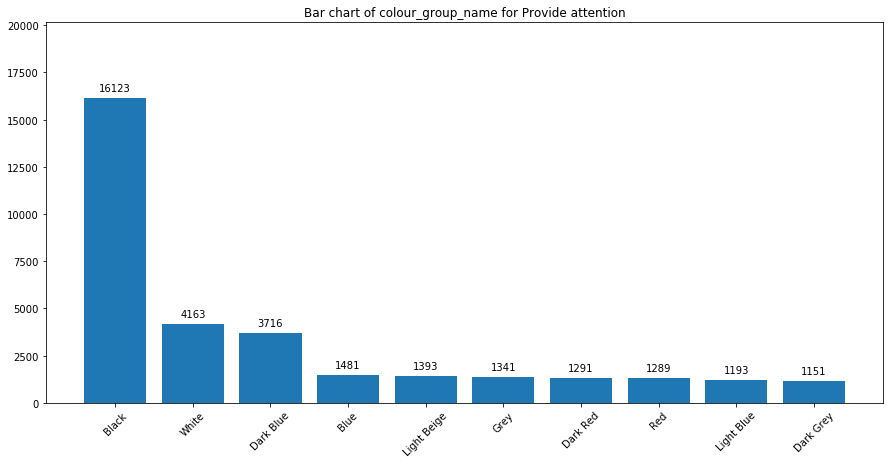



----- Variable: perceived_colour_value_name -----
RFM Segment: Champions


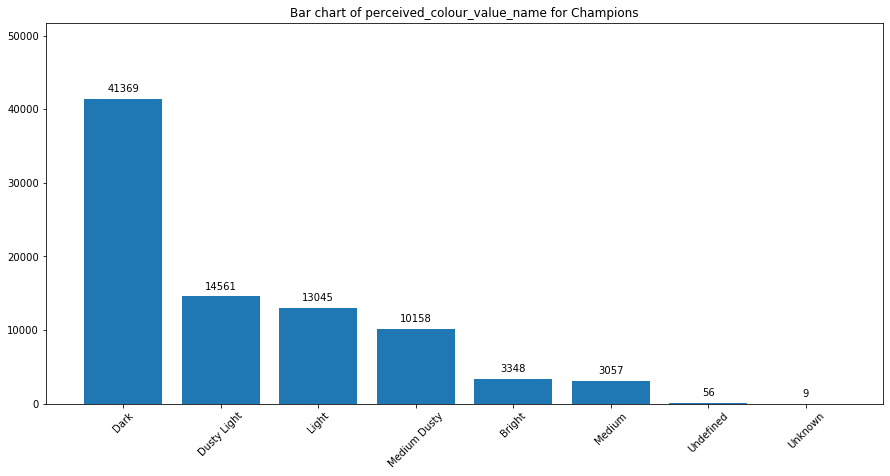



RFM Segment: Loyal


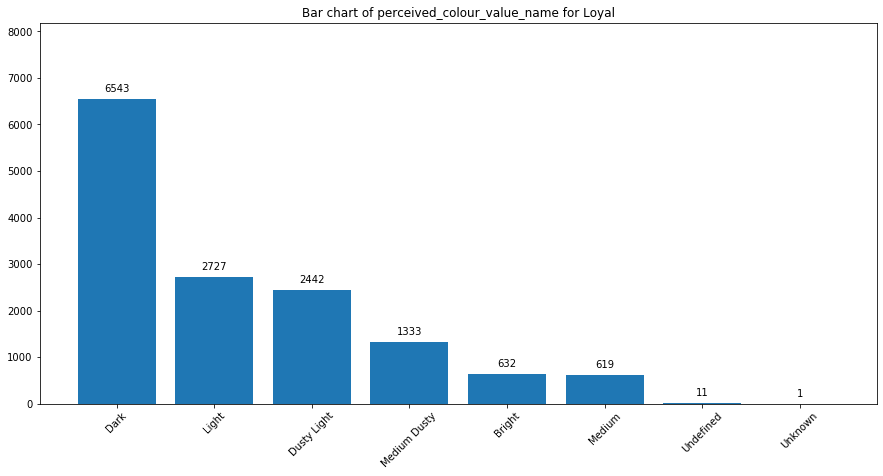



RFM Segment: Unprofitable


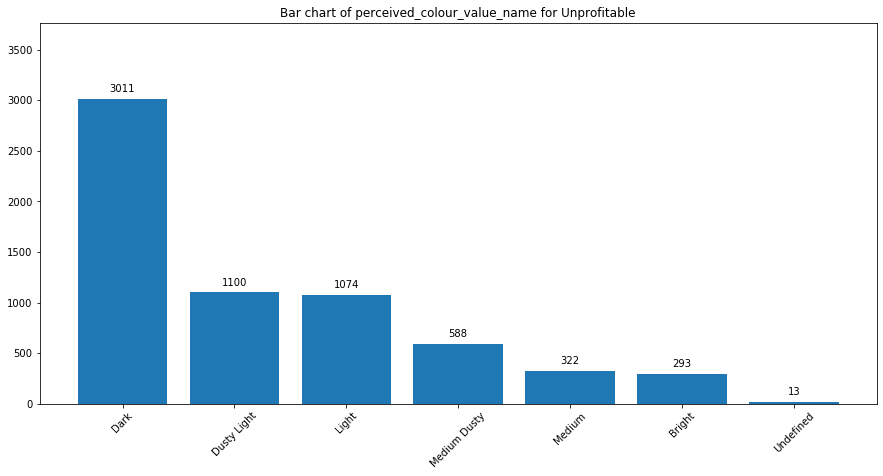



RFM Segment: Provide attention


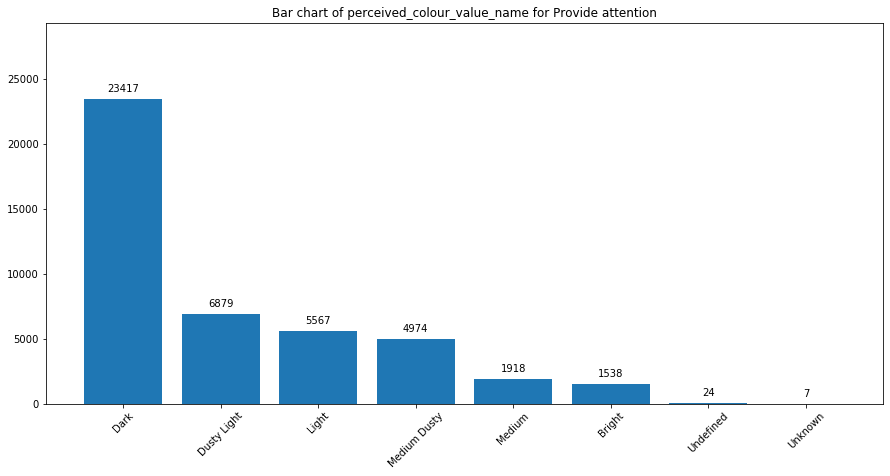



----- Variable: perceived_colour_master_name -----
RFM Segment: Champions


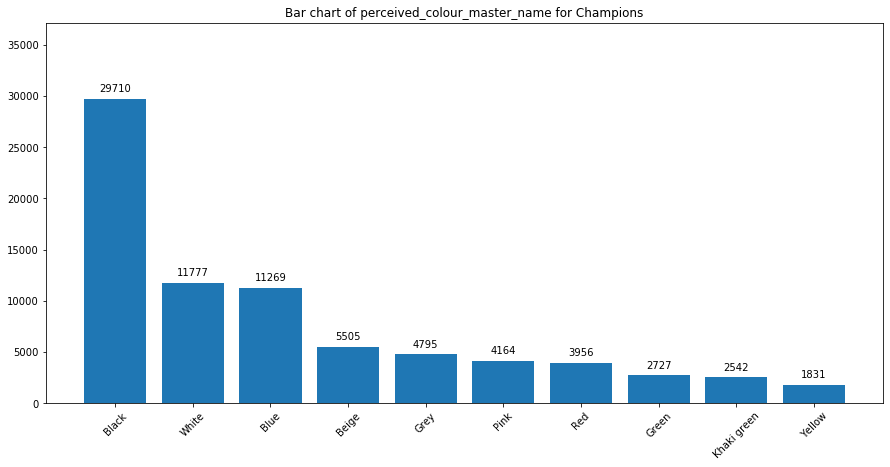



RFM Segment: Loyal


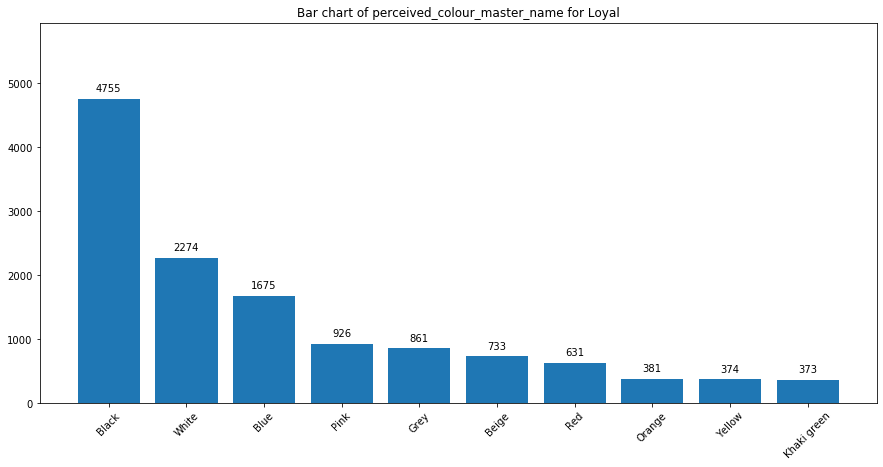



RFM Segment: Unprofitable


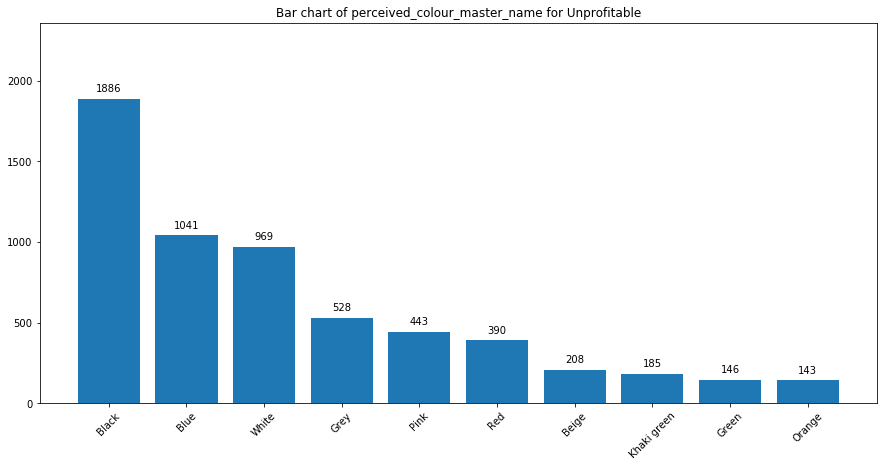



RFM Segment: Provide attention


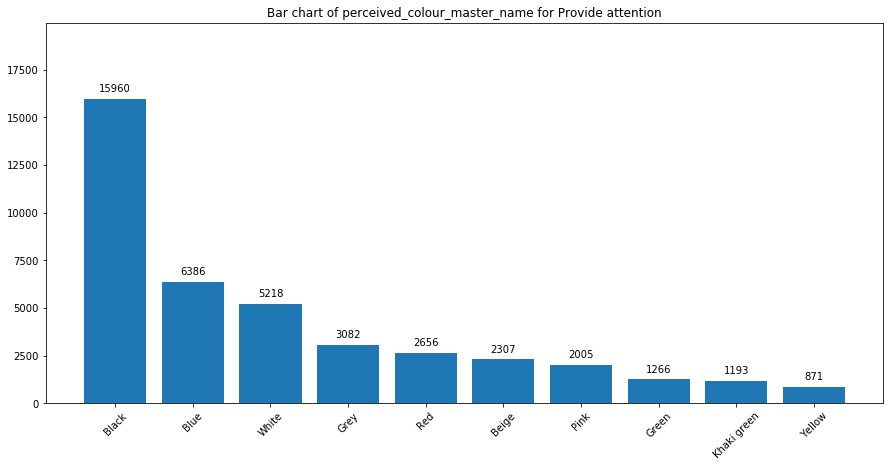



----- Variable: department_name -----
RFM Segment: Champions


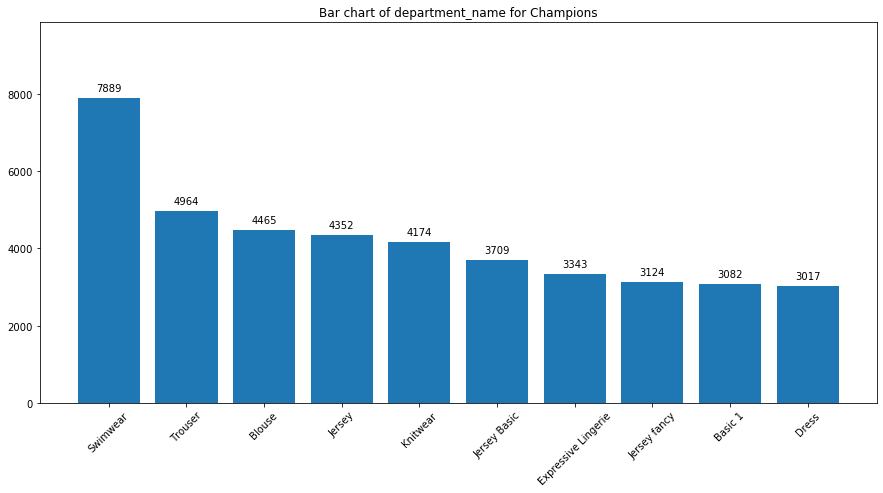



RFM Segment: Loyal


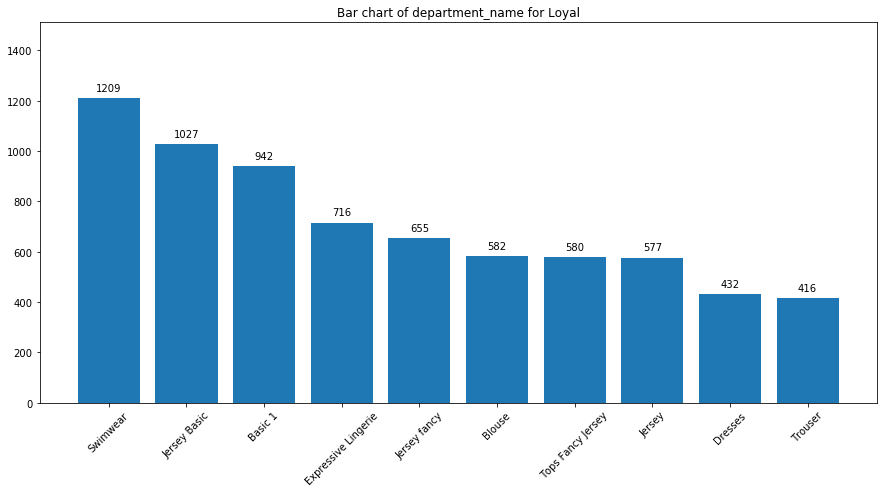



RFM Segment: Unprofitable


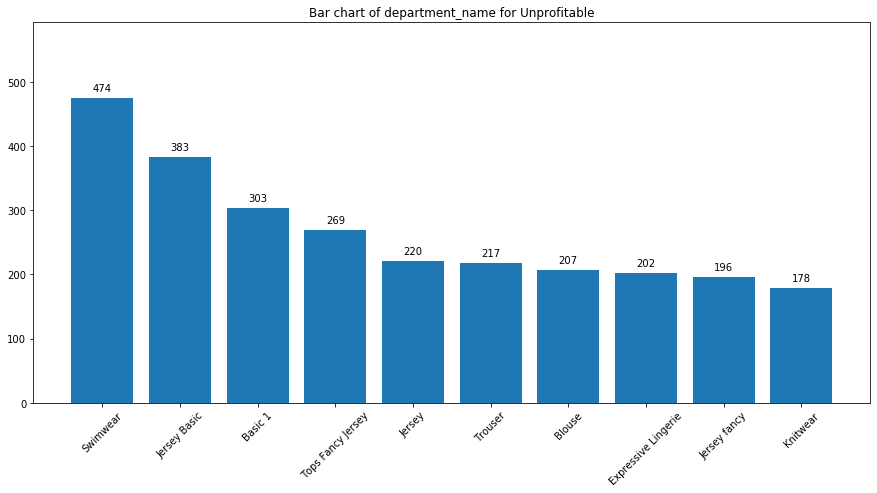



RFM Segment: Provide attention


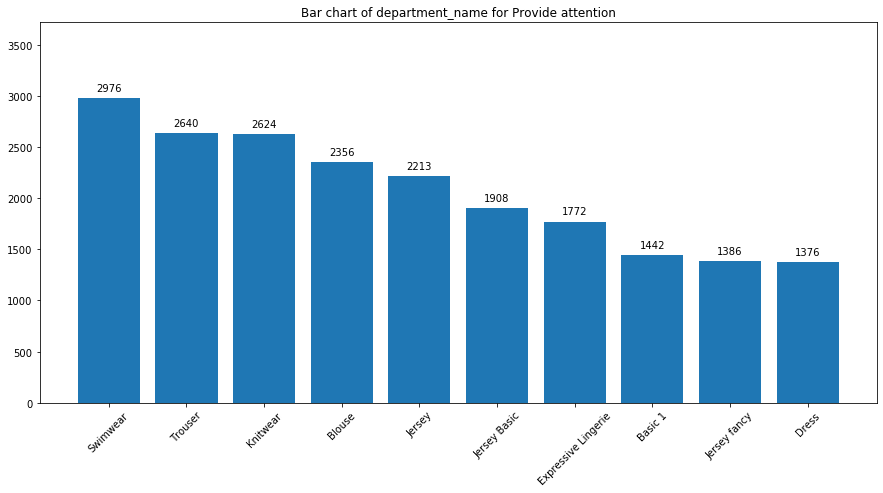



----- Variable: index_name -----
RFM Segment: Champions


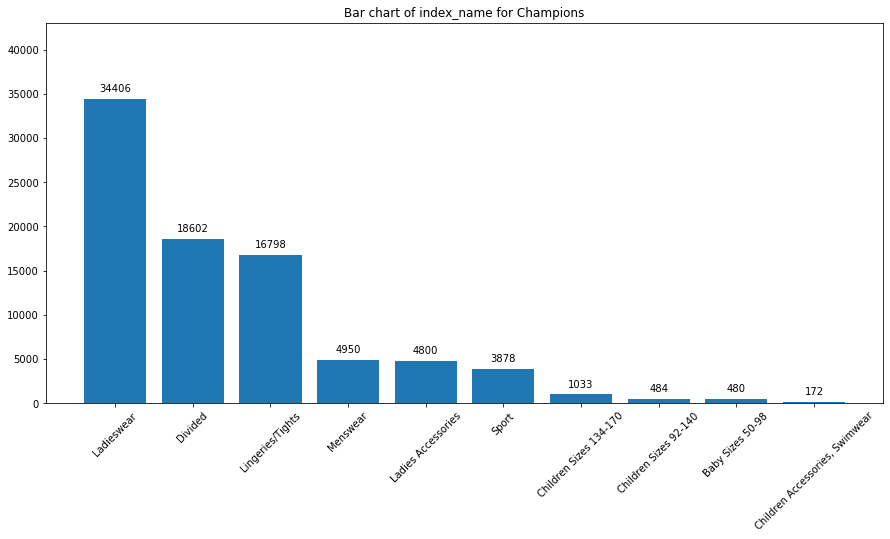



RFM Segment: Loyal


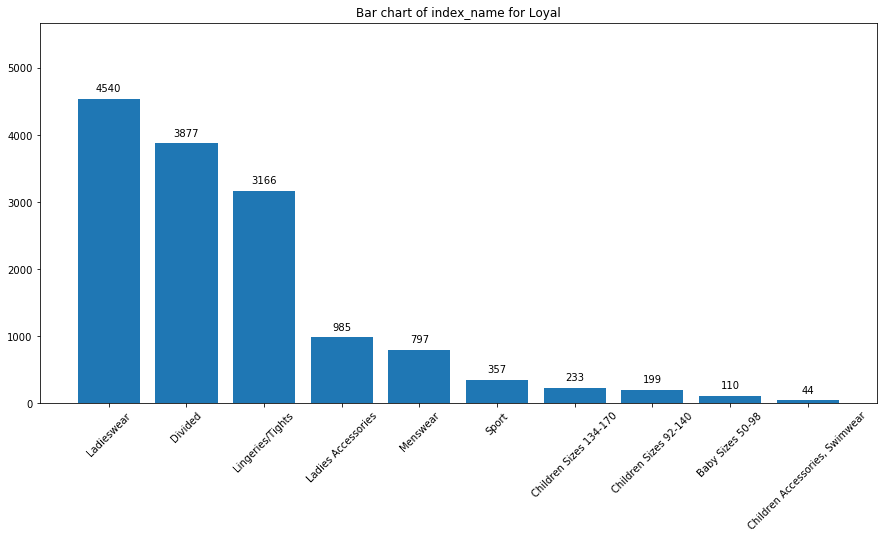



RFM Segment: Unprofitable


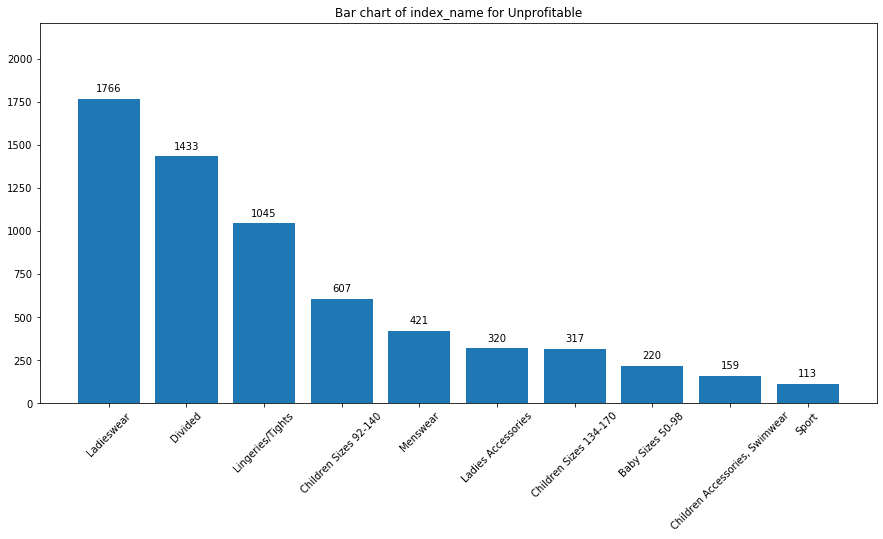



RFM Segment: Provide attention


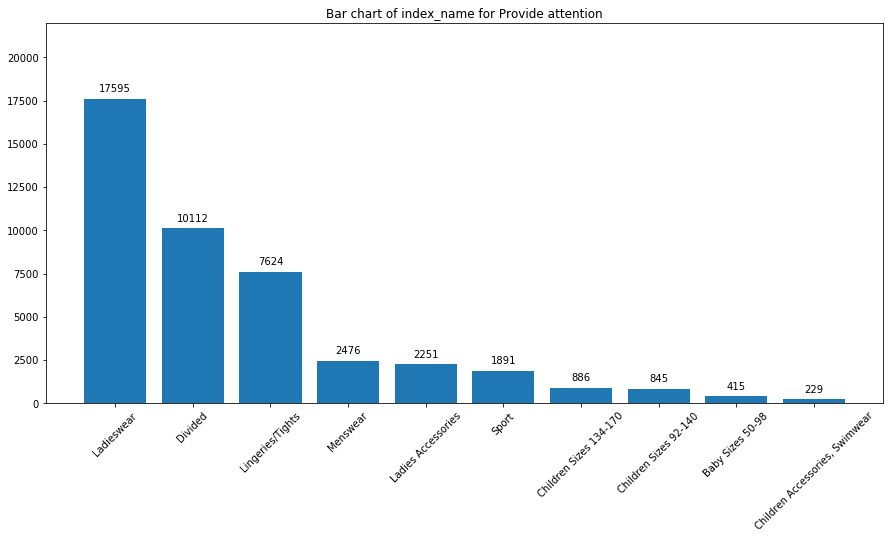



----- Variable: index_group_name -----
RFM Segment: Champions


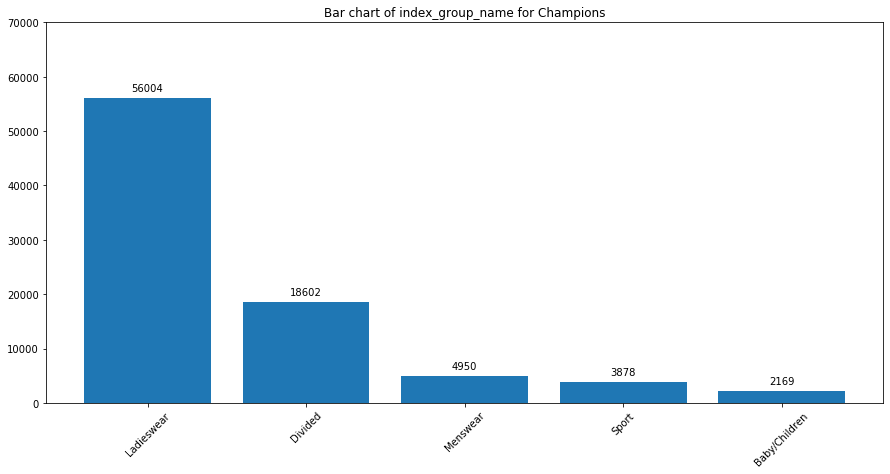



RFM Segment: Loyal


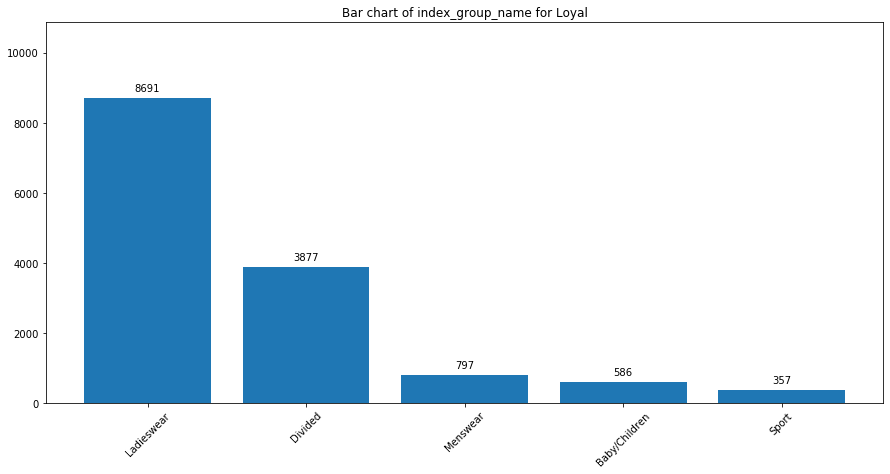



RFM Segment: Unprofitable


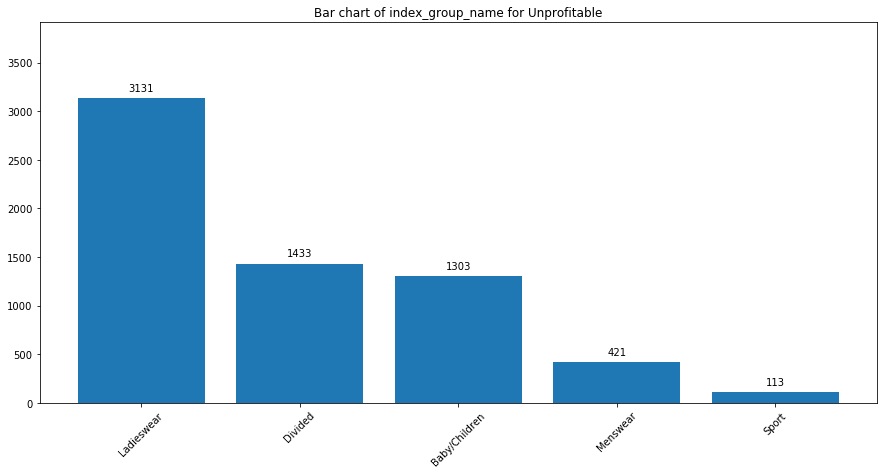



RFM Segment: Provide attention


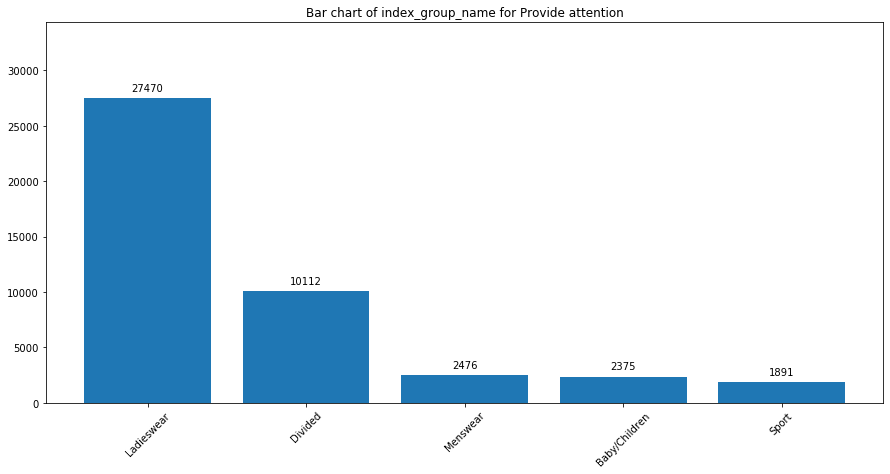



----- Variable: section_name -----
RFM Segment: Champions


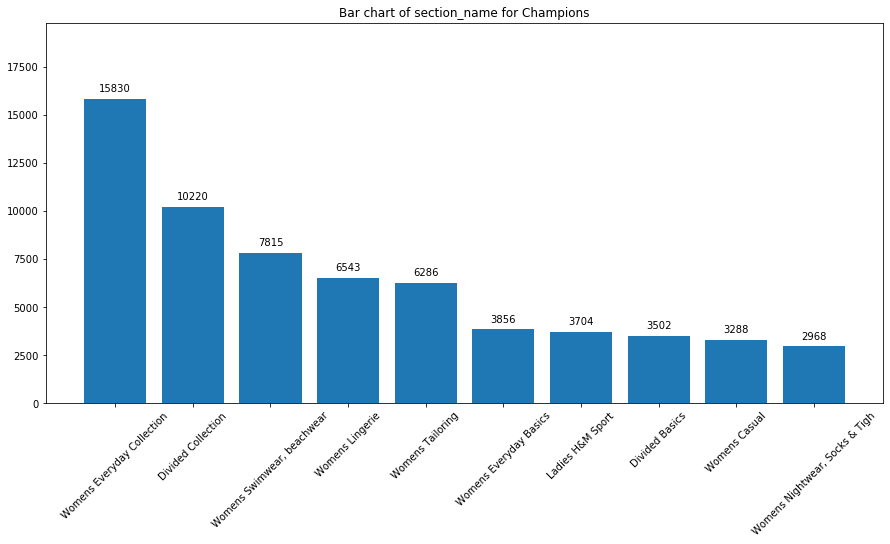



RFM Segment: Loyal


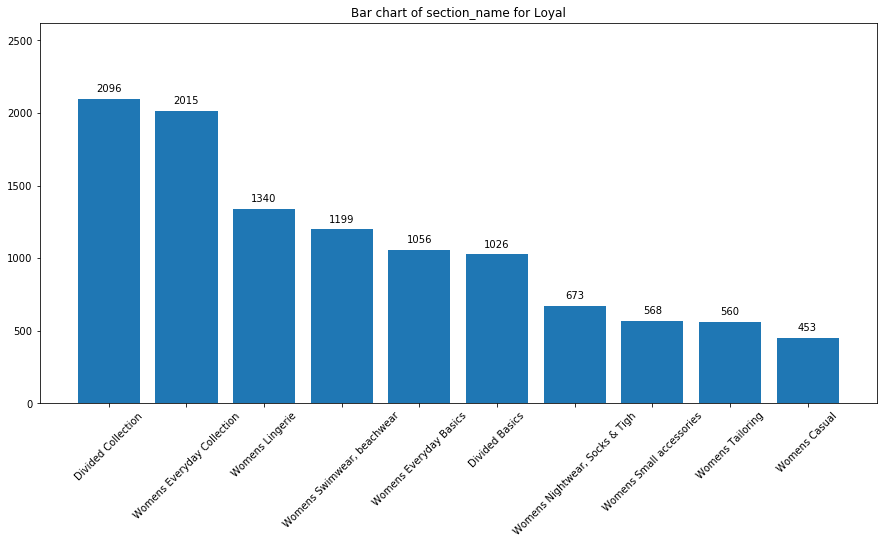



RFM Segment: Unprofitable


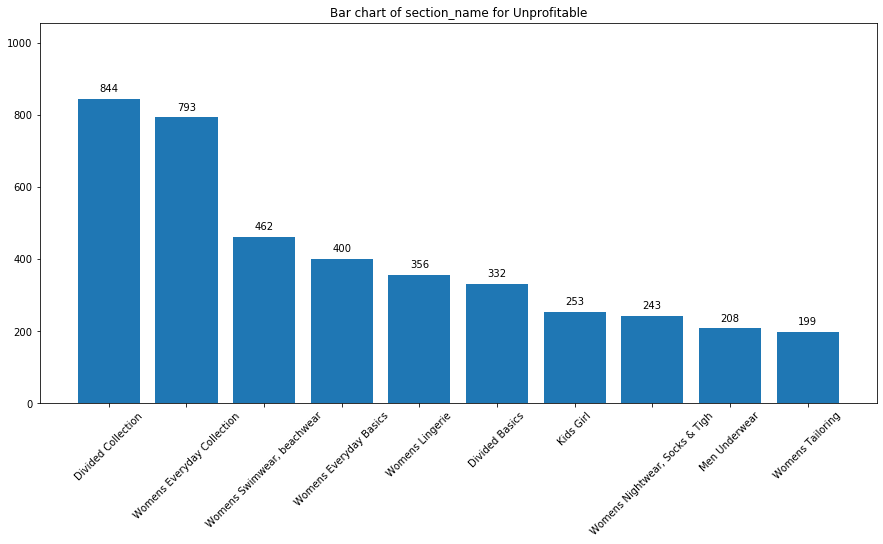



RFM Segment: Provide attention


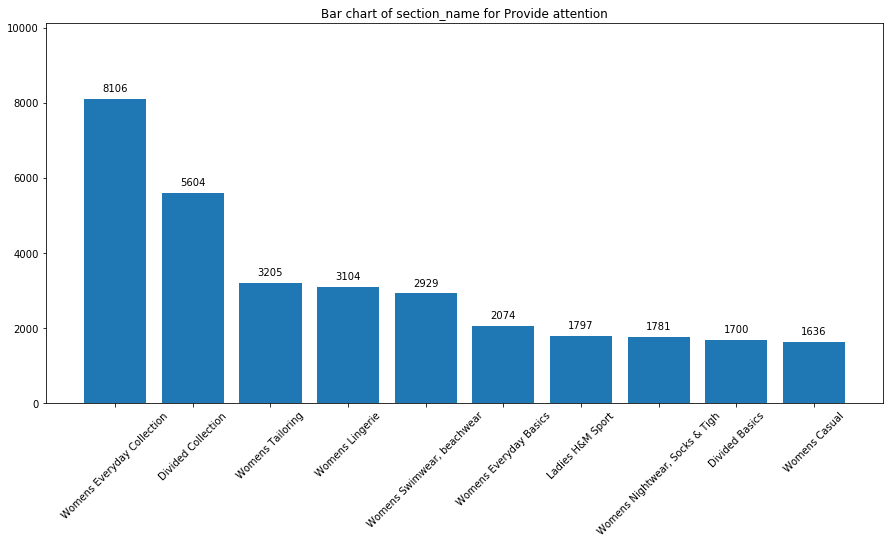



----- Variable: garment_group_name -----
RFM Segment: Champions


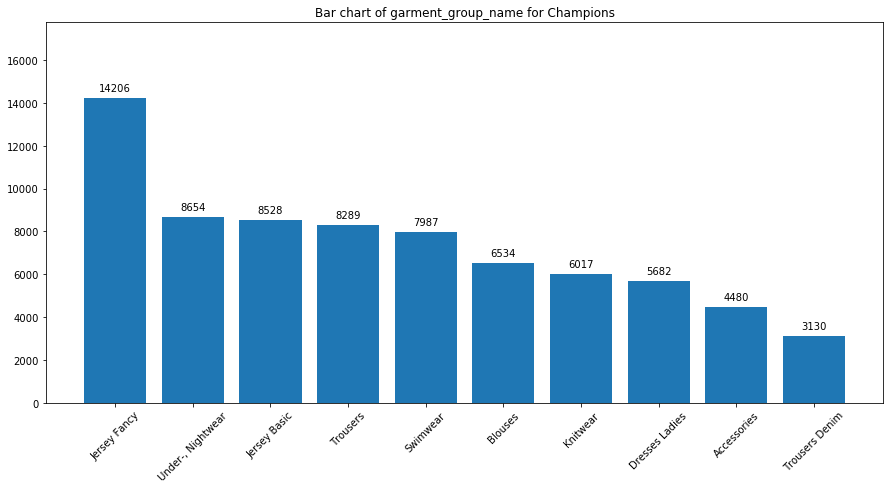



RFM Segment: Loyal


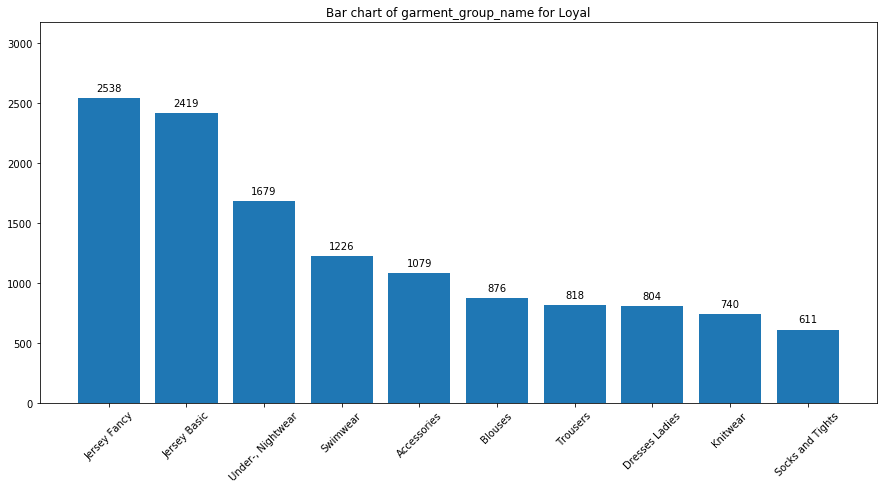



RFM Segment: Unprofitable


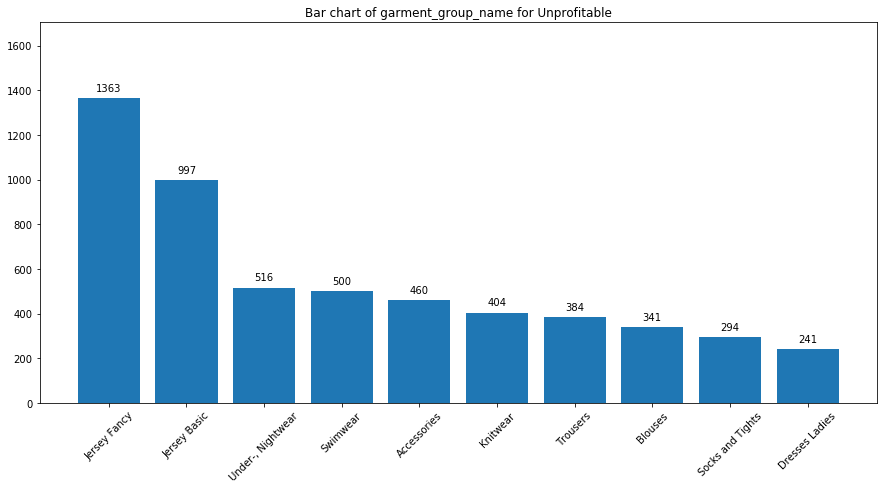



RFM Segment: Provide attention


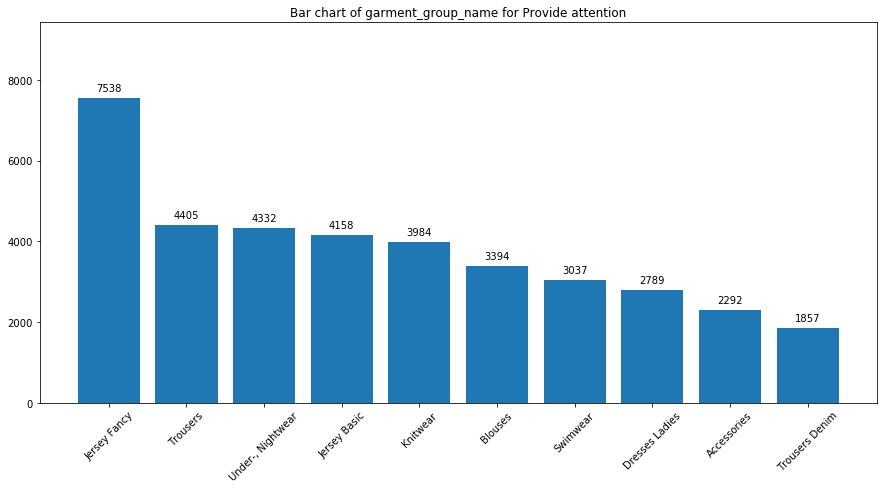



----- Variable: sales_channel_id -----
RFM Segment: Champions


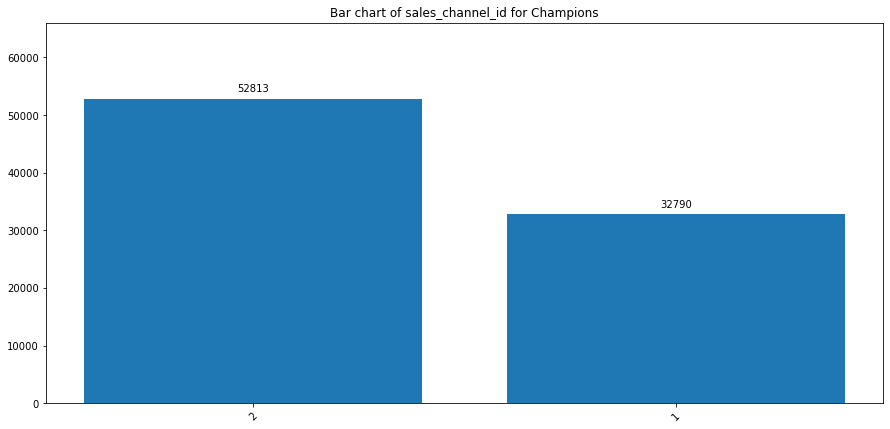



RFM Segment: Loyal


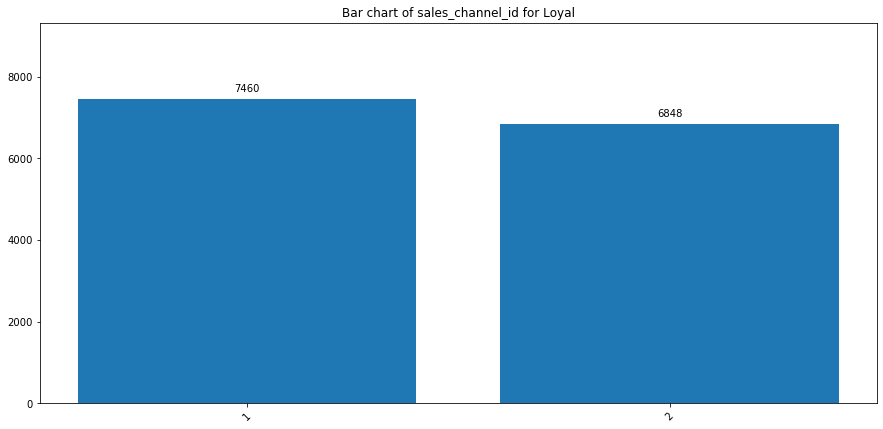



RFM Segment: Unprofitable


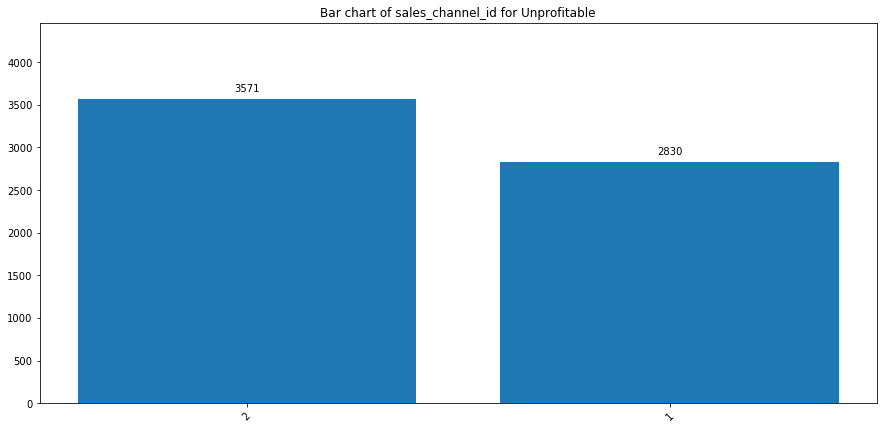



RFM Segment: Provide attention


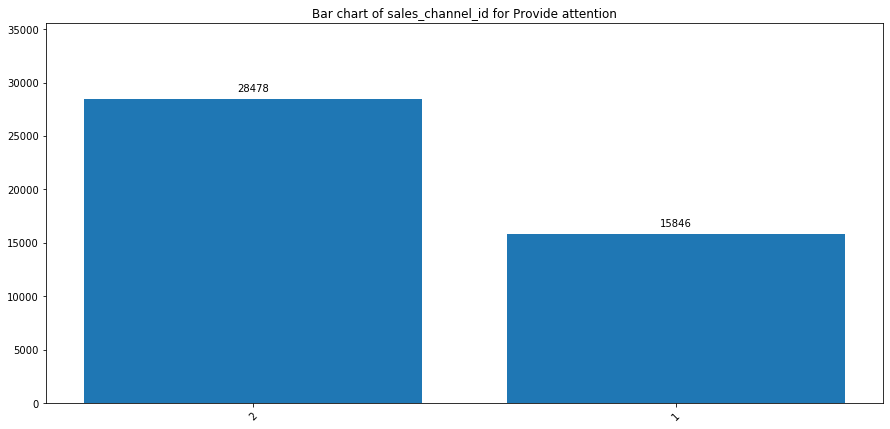

In [116]:
# Based on Top 10 categories in each column variable
labels = list(rfm_article_transact['rfm_label'].unique())
for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
           'perceived_colour_value_name','perceived_colour_master_name','department_name',
           'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
    print('----- Variable:',col,'-----')
    for label in labels:
        print('RFM Segment:',label)
        subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
        value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
        if len(value_counts) > 10:
            value_counts = value_counts[:10]
        barplot(value_counts, label, col, value_counts.index, rotate=True)
        print('\n')

#### Others

#### - Price analysis

In [117]:
rfm_article_transact['price'] *= 1000
rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,rfm_label
0,03de599982c9b24897413f3da2753e288f7605e52214a4...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,8.457627,2,Champions
1,03de599982c9b24897413f3da2753e288f7605e52214a4...,Skinny Ankle H.W,Trousers,Garment Lower body,Denim,White,Light,White,Denim Trousers,Divided,Divided,Ladies Denim,Trousers Denim,27.101695,2,Champions
2,03de599982c9b24897413f3da2753e288f7605e52214a4...,Spirit Split LS,Hoodie,Garment Upper body,Placement print,Black,Dark,Black,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,8.457627,2,Champions
3,03de599982c9b24897413f3da2753e288f7605e52214a4...,Dadi hood,Hoodie,Garment Upper body,Placement print,Black,Dark,Black,Tops Fancy Jersey,Divided,Divided,Divided Collection,Jersey Fancy,16.932203,2,Champions
4,03de599982c9b24897413f3da2753e288f7605e52214a4...,Jet tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,13.542373,2,Champions


--- OVERALL ANALYSIS ---

In [118]:
print('Overall total price:',rfm_article_transact['price'].sum())
print('Overall average price:',rfm_article_transact['price'].mean())
print('Overall median price:',rfm_article_transact['price'].median())

Overall total price: 3840310.084745756
Overall average price: 25.49397278701108
Overall median price: 23.9152542372881


--- ANALYSIS BY CLUSTERS ---

In [119]:
price_rfm = rfm_article_transact.loc[:,['price','rfm_label']]
price_rfm.head()

,price,rfm_label
0,8.457627,Champions
1,27.101695,Champions
2,8.457627,Champions
3,16.932203,Champions
4,13.542373,Champions


In [120]:
# price_rfm['price'] *= 1000
# price_rfm.head()

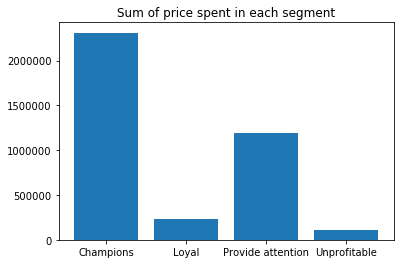

,rfm_label,price
0,Champions,2.310998e+06
1,Loyal,2.290289e+05
2,Provide attention,1.193937e+06
3,Unprofitable,1.063464e+05


In [121]:
price_sum = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].sum()).reset_index()
plt.bar(price_sum['rfm_label'],price_sum['price'])
plt.title('Sum of price spent in each segment')
plt.show()

price_sum

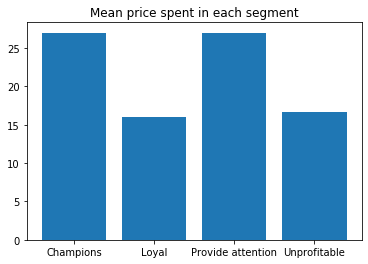

,rfm_label,price
0,Champions,26.996689
1,Loyal,16.007054
2,Provide attention,26.936584
3,Unprofitable,16.614035


In [122]:
price_mean = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].mean()).reset_index()
plt.bar(price_mean['rfm_label'],price_mean['price'])
plt.title('Mean price spent in each segment')
plt.show()

price_mean

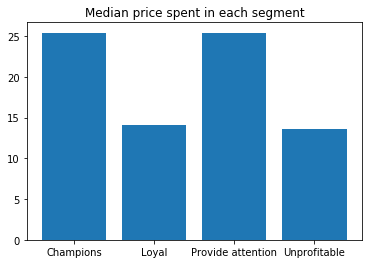

,rfm_label,price
0,Champions,25.406780
1,Loyal,14.059322
2,Provide attention,25.406780
3,Unprofitable,13.559322


In [123]:
price_median = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].median()).reset_index()
plt.bar(price_median['rfm_label'],price_median['price'])
plt.title('Median price spent in each segment')
plt.show()

price_median

#### - Age analysis

--- OVERALL ANALYSIS ---

In [124]:
print('Overall average age:',rfm_customers['age'].mean())
print('Overall median age:',rfm_customers['age'].median())

Overall average age: 36.54970986460348
Overall median age: 32.0


--- ANALYSIS BY CLUSTERS ---

In [125]:
age_rfm = rfm_customers.loc[:,['age','rfm_label']]
age_rfm.head()

,age,rfm_label
0,49,Champions
1,24,Champions
2,52,Champions
3,29,Champions
4,31,Unprofitable


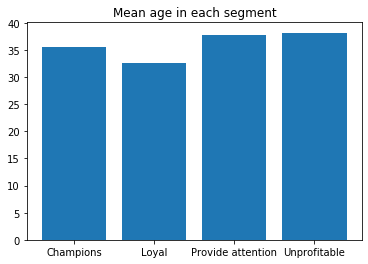

,rfm_label,age
0,Champions,35.494905
1,Loyal,32.559289
2,Provide attention,37.817362
3,Unprofitable,38.170870


In [126]:
age_mean = pd.DataFrame(age_rfm.groupby('rfm_label')['age'].mean()).reset_index()
plt.bar(age_mean['rfm_label'],age_mean['age'])
plt.title('Mean age in each segment')
plt.show()

age_mean

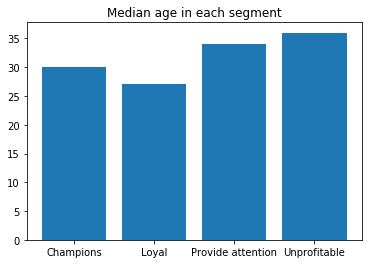

,rfm_label,age
0,Champions,30.0
1,Loyal,27.0
2,Provide attention,34.0
3,Unprofitable,36.0


In [127]:
age_median = pd.DataFrame(age_rfm.groupby('rfm_label')['age'].median()).reset_index()
plt.bar(age_median['rfm_label'],age_median['age'])
plt.title('Median age in each segment')
plt.show()

age_median

## 4 1-sample t-test: On Customers Data (Customer Demographics)
https://towardsdatascience.com/how-to-know-which-statistical-test-to-use-for-hypothesis-testing-744c91685a5d

In [128]:
import scipy.stats as stats
from scipy.stats import ttest_1samp

In [129]:
rfm_customers_OHE = pd.get_dummies(rfm_customers, columns = ['Active','club_member_status', 'fashion_news_frequency','age_bucket'])
rfm_customers_OHE.head()

,customer_id,age,postal_code,Recency,Frequency,Monetary,rfm_label,Active_0.0,Active_1.0,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NONE,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_None,fashion_news_frequency_Regularly,"age_bucket_(10,20)","age_bucket_(20,30)","age_bucket_(30,40)","age_bucket_(40,50)","age_bucket_(50,60)","age_bucket_(60,70)","age_bucket_(70,80)","age_bucket_(80,90)","age_bucket_(90,100)"
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,26,21,30.903955,Champions,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,16,18,39.154426,Champions,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,50,13,36.130378,Champions,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,29,d93e1aaecdebf9f71ab42cc0c5fdbb378514c94971ad1c...,72,3,31.056497,Champions,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,31,2c29ae653a9282cce4151bd87643c907644e09541abc28...,698,15,14.832768,Unprofitable,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [130]:
rfm_customers_OHE['rfm_label'].unique()

array(['Champions', 'Unprofitable', 'Provide attention', 'Loyal'],
      dtype=object)

### 4.1 Column: `Active`
Columns: 'Active_0.0', 'Active_1.0'

In [131]:
colname = 'Active'
for uniq_val in rfm_customers[colname].unique():
    print(f'----- {colname} = {uniq_val} -----')
    for label in rfm_customers['rfm_label'].unique():
        print(f'Segment: {label}')
        colname_full = colname + '_' + str(uniq_val)
        segment = np.array(rfm_customers_OHE[rfm_customers_OHE['rfm_label']==label][colname_full])
        overall = np.array(rfm_customers_OHE[colname_full])
        
        tscore, pvalue = ttest_1samp(segment, popmean=np.mean(overall))
        print("t-statistic: ", tscore)  
        print("p-value: ", pvalue, '\n')

----- Active = 0.0 -----
Segment: Champions
t-statistic:  -7.550824445293193
p-value:  5.1102168011942375e-14 

Segment: Unprofitable
t-statistic:  4.385827003744163
p-value:  1.231596222910172e-05 

Segment: Provide attention
t-statistic:  6.6745926701793215
p-value:  2.7313505396050918e-11 

Segment: Loyal
t-statistic:  -3.884167268762448
p-value:  0.00010935565357400026 

----- Active = 1.0 -----
Segment: Champions
t-statistic:  7.550824445293193
p-value:  5.1102168011942375e-14 

Segment: Unprofitable
t-statistic:  -4.385827003744159
p-value:  1.2315962229101951e-05 

Segment: Provide attention
t-statistic:  -6.6745926701793215
p-value:  2.7313505396050918e-11 

Segment: Loyal
t-statistic:  3.884167268762445
p-value:  0.0001093556535740017 



### 4.2 Column: `club_member_status`
Columns: 'club_member_status_ACTIVE', 'club_member_status_LEFT CLUB', 'club_member_status_NONE', 'club_member_status_PRE-CREATE'

In [132]:
colname = 'club_member_status'
for uniq_val in rfm_customers[colname].unique():
    print(f'----- {colname} = {uniq_val} -----')
    for label in rfm_customers['rfm_label'].unique():
        print(f'Segment: {label}')
        colname_full = colname + '_' + str(uniq_val)
        segment = np.array(rfm_customers_OHE[rfm_customers_OHE['rfm_label']==label][colname_full])
        overall = np.array(rfm_customers_OHE[colname_full])
        
        tscore, pvalue = ttest_1samp(segment, popmean=np.mean(overall))
        print("t-statistic: ", tscore)  
        print("p-value: ", pvalue, '\n')

----- club_member_status = ACTIVE -----
Segment: Champions
t-statistic:  13.5662501709766
p-value:  3.372147251612664e-41 

Segment: Unprofitable
t-statistic:  -6.057475621093915
p-value:  1.7237870472288473e-09 

Segment: Provide attention
t-statistic:  -6.466081012403906
p-value:  1.095634056469962e-10 

Segment: Loyal
t-statistic:  10.797058867764639
p-value:  8.520884691947509e-26 

----- club_member_status = PRE-CREATE -----
Segment: Champions
t-statistic:  -13.32836828803024
p-value:  7.51683023718336e-40 

Segment: Unprofitable
t-statistic:  5.747264837716161
p-value:  1.0857747370926462e-08 

Segment: Provide attention
t-statistic:  6.405266364005785
p-value:  1.6301320104928796e-10 

Segment: Loyal
t-statistic:  -10.145634293018487
p-value:  4.234156310356464e-23 

----- club_member_status = NONE -----
Segment: Champions
t-statistic:  -1.5996686244562455
p-value:  0.10973524570442751 

Segment: Unprofitable
t-statistic:  1.8184182131084465
p-value:  0.0691889000701536 

Segmen

### 4.3 Column: `fashion_news_frequency`
Columns: 'fashion_news_frequency_Monthly', 'fashion_news_frequency_None', 'fashion_news_frequency_Regularly'

In [133]:
colname = 'fashion_news_frequency'
for uniq_val in rfm_customers[colname].unique():
    print(f'----- {colname} = {uniq_val} -----')
    for label in rfm_customers['rfm_label'].unique():
        print(f'Segment: {label}')
        colname_full = colname + '_' + str(uniq_val)
        segment = np.array(rfm_customers_OHE[rfm_customers_OHE['rfm_label']==label][colname_full])
        overall = np.array(rfm_customers_OHE[colname_full])
        
        tscore, pvalue = ttest_1samp(segment, popmean=np.mean(overall))
        print("t-statistic: ", tscore)  
        print("p-value: ", pvalue, '\n')

----- fashion_news_frequency = None -----
Segment: Champions
t-statistic:  -7.446602513357221
p-value:  1.1216393599166193e-13 

Segment: Unprofitable
t-statistic:  4.040780548287456
p-value:  5.582514835700537e-05 

Segment: Provide attention
t-statistic:  6.691872326151859
p-value:  2.4298125620661017e-11 

Segment: Loyal
t-statistic:  -3.7832173768389357
p-value:  0.0001639039986604927 

----- fashion_news_frequency = Regularly -----
Segment: Champions
t-statistic:  7.516843490768279
p-value:  6.610708720034484e-14 

Segment: Unprofitable
t-statistic:  -4.138644218924222
p-value:  3.6772184507197565e-05 

Segment: Provide attention
t-statistic:  -6.7011457741953535
p-value:  2.281688924982176e-11 

Segment: Loyal
t-statistic:  3.7638527141059237
p-value:  0.00017694718210607002 

----- fashion_news_frequency = Monthly -----
Segment: Champions
t-statistic:  -2.485106382978723
p-value:  0.012983701341422599 

Segment: Unprofitable
t-statistic:  1.0951328515558478
p-value:  0.273624819

### 4.4 Column: `age_bucket`

In [134]:
colname = 'age_bucket'
for uniq_val in rfm_customers[colname].unique():
    print(f'----- {colname} = {uniq_val} -----')
    for label in rfm_customers['rfm_label'].unique():
        print(f'Segment: {label}')
        colname_full = colname + '_' + str(uniq_val)
        segment = np.array(rfm_customers_OHE[rfm_customers_OHE['rfm_label']==label][colname_full])
        overall = np.array(rfm_customers_OHE[colname_full])
        
        tscore, pvalue = ttest_1samp(segment, popmean=np.mean(overall))
        print("t-statistic: ", tscore)  
        print("p-value: ", pvalue, '\n')

----- age_bucket = (40,50) -----
Segment: Champions
t-statistic:  -3.341987948799281
p-value:  0.000837908978348311 

Segment: Unprofitable
t-statistic:  3.241158791713732
p-value:  0.0012151606087832578 

Segment: Provide attention
t-statistic:  2.143481771327855
p-value:  0.0321196348980342 

Segment: Loyal
t-statistic:  -2.5603432775073256
p-value:  0.01060122768377162 

----- age_bucket = (20,30) -----
Segment: Champions
t-statistic:  6.305621190643747
p-value:  3.1172003933924653e-10 

Segment: Unprofitable
t-statistic:  -4.4705727295734965
p-value:  8.355243120744503e-06 

Segment: Provide attention
t-statistic:  -5.369068127183487
p-value:  8.250367521349133e-08 

Segment: Loyal
t-statistic:  3.1420757795737915
p-value:  0.0017263432069767764 

----- age_bucket = (50,60) -----
Segment: Champions
t-statistic:  -0.8745268416591853
p-value:  0.38187337903728213 

Segment: Unprofitable
t-statistic:  -1.1638196878187634
p-value:  0.24467225244881 

Segment: Provide attention
t-statis

### 4.5 Column: `Age`

In [135]:
print('-------- Column: Age --------')
for label in rfm_customers['rfm_label'].unique():
    print(f'Segment: {label}')
    subset_age = np.array(rfm_customers_OHE[rfm_customers_OHE['rfm_label']==label]['age'])
    overall_age = np.array(rfm_customers_OHE['age'])

    tscore, pvalue = ttest_1samp(subset_age, popmean=np.mean(overall_age))
    print("t-statistic: ", tscore)  
    print("p-value: ", pvalue, '\n')

-------- Column: Age --------
Segment: Champions
t-statistic:  -5.0614249076441284
p-value:  4.310398713057079e-07 

Segment: Unprofitable
t-statistic:  4.429184132003824
p-value:  1.0106862051428723e-05 

Segment: Provide attention
t-statistic:  6.291746717876184
p-value:  3.390159148948134e-10 

Segment: Loyal
t-statistic:  -9.1645041500917
p-value:  2.705747698113263e-19 

